### Packages

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import scipy.stats as stats
import matplotlib.pyplot as plt

### Cournot

Dynamic Demand:
- $p_t = u_t - v \sum_i q_{it} + x_t$ 
- $x_t = \rho x_{t-1} + e_t, e_t \sim N(0,\sigma)$

Walrasian 
- $\pi_w = \max_{q_i}{(p - w) q_i}$ 
- $w = u - v Q$
- $Q_w = \frac{u-w}{v}$
- $P_w = w$
- $q_w \in [0,Q_w], \pi_w = 0, \Pi_w = 0$

Nash
- $\pi_c = \max_{q_i}{(p(Q) - w) q_i}$ 
- $p(Q) - w - v q_i = 0$
- $n p(Q) = n w + v Q = n u - n v Q$
- $Q_c = \frac{n(u-w)}{v(n+1)}$
- $P_c = u - v Q$
- $q_c = Q_c/n$

Monopoly
- $\pi_m = \max_{Q}{(p(Q) - w) Q}$ 
- $p(Q)=w+vQ=u-vQ$ 
- $Q_m =\frac{u-w}{2v}$ 
- $P_m =\frac{u-w}{2v}$


In [2]:
# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.05
rho = 0.1

In [6]:
def price(Q,u,v):
    return u-v*Q

def profit(P,Q):
    return
           
class cournot:
    def __init__(self,u,v,w,n):
        self.u=u
        self.v=v
        self.w=w
        self.n=n
        self.Qw=(u-w)/v
        self.Qc=n*(u-w)/v/(n+1)
        self.Qm=(u-w)/2*v
        self.Pw = price(self.Qw,u,v)
        self.Pc = price(self.Qc,u,v)
        self.Pm = price(self.Qm,u,v)
        self.Πw = 0
        self.Πc = (self.Pc-w)*self.Qc
        self.Πm = (self.Pm-w)*self.Qm
        self.qw = self.Qw/n
        self.qc = self.Qc/n
        self.qm = self.Qm/n
        self.πw = 0
        self.πc = self.Πc/n
        self.πm = self.Πm/n
    
    def price(self,Q):
        return self.u-v*(Q)
    
    def profit(self,Q):
        return (self.price(Q)-w)*Q
        
game1 = cournot(40,1,4,2)

In [14]:
game1.Qc, game1.qc, game1.Pc, game1.w, game1.Πc, game1.Πm, game1.profit(game1.Qm)

(24.0, 12.0, 16.0, 4, 288.0, 324.0, 324.0)

In [9]:
game1.Qm, game1.qm, game1.Pm, game1.w, game1.Πm, game1.profit(9)

(18.0, 9.0, 22.0, 4, 324.0, 243)

### Shocks

In [10]:
# Input: ρ, σ, K
# Output: KxK Transition Matrix
ρ, σ, K = 0.9, 1, 10
σy = σ/np.sqrt(1-ρ**2)

def tauchen(ρ, σ, K, m=3):
    Z = np.linspace(-m * σ/np.sqrt(1-ρ**2), m * σ/np.sqrt(1-ρ**2), K) # Shock Space
    F = lambda x: stats.norm.cdf(x, 0, σ) # CDF Function for Standard Normal
    α = Z[2] - Z[1] # Step Size
    P = np.zeros((K,K)) # Placeholder Transition Matrix
    # P[i,j] is probability of process going from Zi to Zj 
    for i in range(K):
        for j in range(K):
            if j == 1:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i])
            elif j == K:
                P[i, j] = 1 - F(Z[j]-α/2-ρ*Z[i])
            else:
                P[i, j] = F(Z[j]+α/2-ρ*Z[i]) - F(Z[j]-α/2-ρ*Z[i])
        P[i, :] = P[i, :]/sum(P[i, :])
    return Z, α, F, P
        
def whichidx(value, array):
    return np.argmin(np.abs(array-value))

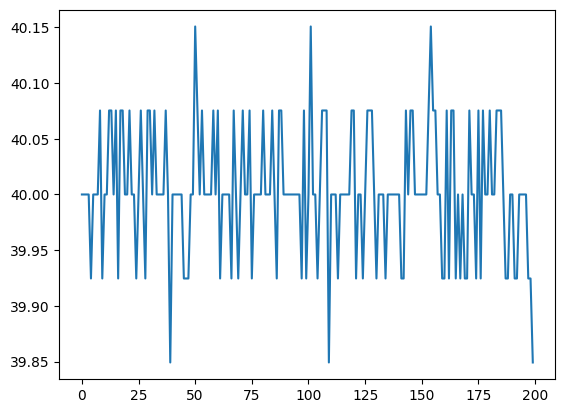

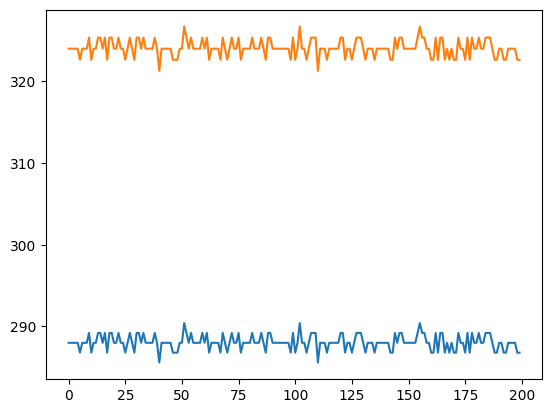

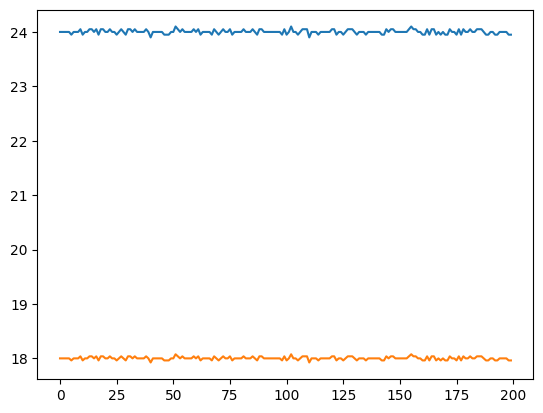

In [15]:
import numpy as np
e = np.random.normal(1)*sigma
K = 5
Z, α, F, P = tauchen(rho, sigma, K, m=3)
u_history=[]
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

uidx = 0
for t in range(200):
    # find competition level profit 
    qc_history.append(cournot(u,v,w,n).Qc)
    qm_history.append(cournot(u,v,w,n).Qm)
    pc_history.append(cournot(u,v,w,n).Πc)
    pm_history.append(cournot(u,v,w,n).Πm)
   
    # generate next shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    u_history.append(u)
    
plt.plot(u_history)
plt.show()

plt.plot(pc_history)
plt.plot(pm_history)
plt.show()

plt.plot(qc_history)
plt.plot(qm_history)
plt.show()

### Q-Learning

In [28]:
import random
import numpy as np

# define the Boltzmann action selection function
def boltzmann_action_selection(Q, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state2,:])
    logits = (Q[state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    action = np.random.choice(range(len(probs)), p=probs)
    return action


# initialize the state
state1 = 0
state2 = 0
u = 0
uidx = 0

# initialize the Q-table
game = game1
num_states1 = 25
num_states2 = 5
num_actions = 25
Z, α, F, P = tauchen(rho, sigma, num_states2, m=3)
uidx = int(round(num_states2/2))

# parameters of model
gamma = 0.9
u = 40
v = 1
w = 4
n = 2
sigma = 0.05
rho = 0.1

Q1 = np.random.uniform(cournot(u,v,w,n).Πc,cournot(u,v,w,n).Πm,(num_states2, num_actions))

# histories
q1_history = []
u_history = []
qc_history=[]
qm_history=[]
pc_history=[]
pm_history=[]

action2quantity = np.linspace(cournot(u,v,w,n).Qm*0.8,cournot(u,v,w,n).Qc*1.2,num_actions)
action2quantity

array([14.4, 15. , 15.6, 16.2, 16.8, 17.4, 18. , 18.6, 19.2, 19.8, 20.4,
       21. , 21.6, 22.2, 22.8, 23.4, 24. , 24.6, 25.2, 25.8, 26.4, 27. ,
       27.6, 28.2, 28.8])

In [29]:

# initialize Boltzmann Q-learning parameters
alpha = 0.01
initial_temperature = 1.0
temperature_decay = 0.9999
min_temperature = 0.1
temperature = initial_temperature
initial_eps = 1.0
eps_decay = 0.9999
min_eps = 0.05
eps = initial_eps
errors = []


In [63]:
alpha = 0.1
temperature_decay = 0.9999

# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 100000
for episode in range(num_episodes):

    if np.random.uniform()>eps:
        # select an action using Boltzmann action selection
        action1 = boltzmann_action_selection(Q1, uidx, temperature)
    else:
        action1 = np.random.choice(range(num_actions))

    quantity1 = action2quantity[action1]

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1)

    # update the Q-value for the selected action in the current state
    Q1[uidx][action1] =  (1-alpha)*Q1[uidx][action1] + alpha * (reward1 + gamma * np.max(np.average(Q1,axis=0,weights=P[uidx])))
    
    # generate shock
    uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]
    
    # update temperature
    temperature = max(min_temperature, temperature * temperature_decay)
    eps = max(min_eps, eps * eps_decay)
    error = reward1 + gamma * np.max(Q1[uidx])-Q1[uidx][action1] 
    errors.append(error)
    if num_episodes>1000:
        print(f'{episode},{np.mean(errors[-1000:]):0.2f},{uidx:0.2f}, {action1:0.2f}, {reward1:0.2f},  {temperature:0.2f}, {eps:0.2f}')
    
    u_history.append(u)
    q1_history.append(quantity1)
    qc_history.append(cournot(u,v,w,n).Qc)
    qm_history.append(cournot(u,v,w,n).Qm)
    pc_history.append(cournot(u,v,w,n).profit(quantity1))
  

0,5.54,3.00, 2.00, 317.06,  3.46, 0.05
1,5.44,1.00, 8.00, 324.01,  3.46, 0.05
2,5.44,1.00, 3.00, 319.54,  3.46, 0.05
3,5.44,2.00, 8.00, 321.11,  3.46, 0.05
4,5.44,2.00, 15.00, 294.84,  3.46, 0.05
5,5.44,2.00, 6.00, 324.00,  3.46, 0.05
6,5.44,2.00, 5.00, 323.64,  3.46, 0.05
7,5.44,2.00, 5.00, 323.64,  3.46, 0.05
8,5.44,1.00, 4.00, 322.56,  3.46, 0.05
9,5.44,2.00, 5.00, 322.33,  3.46, 0.05
10,5.44,3.00, 5.00, 323.64,  3.46, 0.05
11,5.44,2.00, 12.00, 312.67,  3.46, 0.05
12,5.44,1.00, 4.00, 322.56,  3.46, 0.05
13,5.44,3.00, 4.00, 321.29,  3.45, 0.05
14,5.44,2.00, 5.00, 324.95,  3.45, 0.05
15,5.44,2.00, 7.00, 323.64,  3.45, 0.05
16,5.44,3.00, 9.00, 320.76,  3.45, 0.05
17,5.44,2.00, 7.00, 325.04,  3.45, 0.05
18,5.45,2.00, 11.00, 315.00,  3.45, 0.05
19,5.45,3.00, 3.00, 320.76,  3.45, 0.05
20,5.45,2.00, 12.00, 312.67,  3.45, 0.05
21,5.45,2.00, 8.00, 322.56,  3.45, 0.05
22,5.45,2.00, 3.00, 320.76,  3.45, 0.05
23,5.45,3.00, 8.00, 322.56,  3.45, 0.05
24,5.45,1.00, 7.00, 325.04,  3.45, 0.05
25,5.4

444,5.19,2.00, 5.00, 323.64,  3.31, 0.05
445,5.19,3.00, 6.00, 324.00,  3.31, 0.05
446,5.19,2.00, 6.00, 325.36,  3.31, 0.05
447,5.19,2.00, 8.00, 322.56,  3.31, 0.05
448,5.19,2.00, 4.00, 322.56,  3.31, 0.05
449,5.19,1.00, 2.00, 318.24,  3.31, 0.05
450,5.19,2.00, 6.00, 322.64,  3.31, 0.05
451,5.19,2.00, 3.00, 320.76,  3.31, 0.05
452,5.19,2.00, 5.00, 323.64,  3.31, 0.05
453,5.19,2.00, 0.00, 311.04,  3.31, 0.05
454,5.19,2.00, 5.00, 323.64,  3.31, 0.05
455,5.19,2.00, 3.00, 320.76,  3.31, 0.05
456,5.19,2.00, 8.00, 322.56,  3.31, 0.05
457,5.19,1.00, 5.00, 323.64,  3.30, 0.05
458,5.19,1.00, 5.00, 322.33,  3.30, 0.05
459,5.19,1.00, 20.00, 251.45,  3.30, 0.05
460,5.19,2.00, 3.00, 319.54,  3.30, 0.05
461,5.19,2.00, 9.00, 320.76,  3.30, 0.05
462,5.14,3.00, 10.00, 318.24,  3.30, 0.05
463,5.15,1.00, 8.00, 324.01,  3.30, 0.05
464,5.14,3.00, 5.00, 322.33,  3.30, 0.05
465,5.15,3.00, 4.00, 323.83,  3.30, 0.05
466,5.15,3.00, 8.00, 324.01,  3.30, 0.05
467,5.15,3.00, 4.00, 323.83,  3.30, 0.05
468,5.15,2.00,

910,4.71,1.00, 5.00, 323.64,  3.16, 0.05
911,4.71,2.00, 4.00, 321.29,  3.16, 0.05
912,4.71,1.00, 4.00, 322.56,  3.16, 0.05
913,4.70,3.00, 6.00, 322.64,  3.16, 0.05
914,4.71,3.00, 4.00, 323.83,  3.16, 0.05
915,4.71,2.00, 8.00, 324.01,  3.16, 0.05
916,4.84,4.00, 3.00, 320.76,  3.16, 0.05
917,4.84,2.00, 2.00, 320.59,  3.16, 0.05
918,4.84,3.00, 6.00, 324.00,  3.16, 0.05
919,4.84,3.00, 9.00, 322.25,  3.16, 0.05
920,4.85,1.00, 3.00, 321.98,  3.16, 0.05
921,4.85,1.00, 7.00, 322.24,  3.15, 0.05
922,4.84,3.00, 4.00, 321.29,  3.15, 0.05
923,4.84,2.00, 8.00, 324.01,  3.15, 0.05
924,4.84,2.00, 6.00, 324.00,  3.15, 0.05
925,4.84,2.00, 6.00, 324.00,  3.15, 0.05
926,4.84,2.00, 8.00, 322.56,  3.15, 0.05
927,4.84,3.00, 6.00, 324.00,  3.15, 0.05
928,4.85,2.00, 4.00, 323.83,  3.15, 0.05
929,4.85,3.00, 3.00, 320.76,  3.15, 0.05
930,4.85,3.00, 5.00, 324.95,  3.15, 0.05
931,4.85,2.00, 6.00, 325.36,  3.15, 0.05
932,4.85,3.00, 4.00, 322.56,  3.15, 0.05
933,4.85,1.00, 7.00, 325.04,  3.15, 0.05
934,4.85,2.00, 3

1399,4.91,2.00, 9.00, 320.76,  3.01, 0.05
1400,4.91,2.00, 4.00, 322.56,  3.01, 0.05
1401,4.91,3.00, 5.00, 323.64,  3.01, 0.05
1402,4.91,2.00, 6.00, 325.36,  3.01, 0.05
1403,4.91,2.00, 10.00, 318.24,  3.01, 0.05
1404,4.91,2.00, 8.00, 322.56,  3.01, 0.05
1405,4.90,2.00, 8.00, 322.56,  3.01, 0.05
1406,4.90,1.00, 5.00, 323.64,  3.01, 0.05
1407,4.90,2.00, 7.00, 322.24,  3.01, 0.05
1408,4.90,2.00, 7.00, 323.64,  3.00, 0.05
1409,4.90,2.00, 7.00, 323.64,  3.00, 0.05
1410,4.90,2.00, 6.00, 324.00,  3.00, 0.05
1411,4.90,2.00, 5.00, 323.64,  3.00, 0.05
1412,4.90,3.00, 8.00, 322.56,  3.00, 0.05
1413,4.86,2.00, 4.00, 323.83,  3.00, 0.05
1414,4.86,2.00, 5.00, 323.64,  3.00, 0.05
1415,4.86,3.00, 4.00, 322.56,  3.00, 0.05
1416,4.86,2.00, 7.00, 325.04,  3.00, 0.05
1417,4.86,3.00, 5.00, 323.64,  3.00, 0.05
1418,4.86,2.00, 11.00, 316.58,  3.00, 0.05
1419,4.86,3.00, 3.00, 320.76,  3.00, 0.05
1420,4.86,2.00, 8.00, 324.01,  3.00, 0.05
1421,4.86,2.00, 4.00, 322.56,  3.00, 0.05
1422,4.86,1.00, 6.00, 324.00,  3

1880,4.45,2.00, 5.00, 324.95,  2.87, 0.05
1881,4.45,2.00, 5.00, 323.64,  2.87, 0.05
1882,4.45,3.00, 15.00, 294.84,  2.87, 0.05
1883,4.27,3.00, 8.00, 324.01,  2.87, 0.05
1884,4.27,1.00, 8.00, 324.01,  2.87, 0.05
1885,4.27,2.00, 5.00, 322.33,  2.86, 0.05
1886,4.45,4.00, 7.00, 323.64,  2.86, 0.05
1887,4.45,2.00, 2.00, 320.59,  2.86, 0.05
1888,4.45,3.00, 7.00, 323.64,  2.86, 0.05
1889,4.45,2.00, 8.00, 324.01,  2.86, 0.05
1890,4.45,3.00, 19.00, 263.16,  2.86, 0.05
1891,4.45,3.00, 5.00, 324.95,  2.86, 0.05
1892,4.45,2.00, 4.00, 323.83,  2.86, 0.05
1893,4.45,1.00, 4.00, 322.56,  2.86, 0.05
1894,4.45,1.00, 6.00, 322.64,  2.86, 0.05
1895,4.45,2.00, 5.00, 322.33,  2.86, 0.05
1896,4.45,2.00, 7.00, 323.64,  2.86, 0.05
1897,4.45,2.00, 4.00, 322.56,  2.86, 0.05
1898,4.45,2.00, 7.00, 323.64,  2.86, 0.05
1899,4.46,2.00, 7.00, 323.64,  2.86, 0.05
1900,4.46,2.00, 7.00, 323.64,  2.86, 0.05
1901,4.45,2.00, 3.00, 320.76,  2.86, 0.05
1902,4.45,1.00, 5.00, 323.64,  2.86, 0.05
1903,4.45,1.00, 7.00, 322.24,  2

2264,4.35,2.00, 2.00, 320.59,  2.76, 0.05
2265,4.35,2.00, 7.00, 323.64,  2.76, 0.05
2266,4.35,2.00, 2.00, 318.24,  2.76, 0.05
2267,4.35,3.00, 9.00, 320.76,  2.76, 0.05
2268,4.35,3.00, 3.00, 321.98,  2.76, 0.05
2269,4.35,2.00, 6.00, 325.36,  2.76, 0.05
2270,4.35,1.00, 11.00, 315.00,  2.76, 0.05
2271,4.35,3.00, 5.00, 322.33,  2.76, 0.05
2272,4.35,1.00, 6.00, 325.36,  2.76, 0.05
2273,4.35,2.00, 4.00, 321.29,  2.76, 0.05
2274,4.35,3.00, 9.00, 320.76,  2.76, 0.05
2275,4.35,3.00, 7.00, 325.04,  2.76, 0.05
2276,4.35,2.00, 3.00, 321.98,  2.76, 0.05
2277,4.35,1.00, 5.00, 323.64,  2.75, 0.05
2278,4.35,2.00, 2.00, 317.06,  2.75, 0.05
2279,4.35,2.00, 4.00, 322.56,  2.75, 0.05
2280,4.35,3.00, 9.00, 320.76,  2.75, 0.05
2281,4.23,2.00, 7.00, 325.04,  2.75, 0.05
2282,4.23,3.00, 21.00, 243.00,  2.75, 0.05
2283,4.23,3.00, 7.00, 325.04,  2.75, 0.05
2284,4.23,2.00, 8.00, 324.01,  2.75, 0.05
2285,4.23,2.00, 7.00, 323.64,  2.75, 0.05
2286,4.23,2.00, 8.00, 322.56,  2.75, 0.05
2287,4.23,1.00, 2.00, 318.24,  2

2646,4.25,1.00, 5.00, 324.95,  2.66, 0.05
2647,4.25,2.00, 6.00, 322.64,  2.65, 0.05
2648,4.25,3.00, 2.00, 318.24,  2.65, 0.05
2649,4.25,2.00, 4.00, 323.83,  2.65, 0.05
2650,4.25,2.00, 8.00, 322.56,  2.65, 0.05
2651,4.25,3.00, 6.00, 324.00,  2.65, 0.05
2652,4.25,3.00, 8.00, 324.01,  2.65, 0.05
2653,4.25,3.00, 4.00, 323.83,  2.65, 0.05
2654,4.25,2.00, 4.00, 323.83,  2.65, 0.05
2655,4.25,2.00, 6.00, 324.00,  2.65, 0.05
2656,4.25,1.00, 4.00, 322.56,  2.65, 0.05
2657,4.25,2.00, 6.00, 322.64,  2.65, 0.05
2658,4.25,3.00, 4.00, 322.56,  2.65, 0.05
2659,4.25,2.00, 19.00, 265.10,  2.65, 0.05
2660,4.25,2.00, 6.00, 324.00,  2.65, 0.05
2661,4.25,1.00, 9.00, 320.76,  2.65, 0.05
2662,4.25,2.00, 5.00, 322.33,  2.65, 0.05
2663,4.25,1.00, 8.00, 322.56,  2.65, 0.05
2664,4.25,2.00, 8.00, 321.11,  2.65, 0.05
2665,4.25,2.00, 7.00, 323.64,  2.65, 0.05
2666,4.25,3.00, 7.00, 323.64,  2.65, 0.05
2667,4.25,2.00, 6.00, 325.36,  2.65, 0.05
2668,4.25,2.00, 6.00, 324.00,  2.65, 0.05
2669,4.25,1.00, 7.00, 323.64,  2.

2994,4.85,3.00, 4.00, 322.56,  2.56, 0.05
2995,4.85,2.00, 3.00, 321.98,  2.56, 0.05
2996,4.85,2.00, 6.00, 324.00,  2.56, 0.05
2997,4.85,1.00, 7.00, 323.64,  2.56, 0.05
2998,4.85,2.00, 7.00, 322.24,  2.56, 0.05
2999,4.85,2.00, 3.00, 320.76,  2.56, 0.05
3000,4.85,1.00, 7.00, 323.64,  2.56, 0.05
3001,4.85,2.00, 6.00, 322.64,  2.56, 0.05
3002,4.85,1.00, 5.00, 323.64,  2.56, 0.05
3003,4.85,1.00, 3.00, 319.54,  2.56, 0.05
3004,4.85,3.00, 5.00, 322.33,  2.56, 0.05
3005,4.85,2.00, 4.00, 323.83,  2.56, 0.05
3006,4.85,2.00, 7.00, 323.64,  2.56, 0.05
3007,4.85,3.00, 10.00, 318.24,  2.56, 0.05
3008,4.85,3.00, 9.00, 322.25,  2.56, 0.05
3009,4.85,3.00, 4.00, 323.83,  2.56, 0.05
3010,4.85,1.00, 7.00, 325.04,  2.56, 0.05
3011,4.85,2.00, 6.00, 322.64,  2.56, 0.05
3012,4.85,1.00, 6.00, 324.00,  2.56, 0.05
3013,4.85,1.00, 5.00, 322.33,  2.56, 0.05
3014,4.85,2.00, 5.00, 322.33,  2.56, 0.05
3015,4.85,3.00, 3.00, 320.76,  2.56, 0.05
3016,4.78,2.00, 5.00, 324.95,  2.56, 0.05
3017,4.78,2.00, 5.00, 323.64,  2.

3425,4.92,2.00, 5.00, 322.33,  2.46, 0.05
3426,4.92,3.00, 6.00, 324.00,  2.46, 0.05
3427,4.92,2.00, 4.00, 323.83,  2.46, 0.05
3428,4.92,3.00, 6.00, 324.00,  2.46, 0.05
3429,4.93,2.00, 8.00, 324.01,  2.46, 0.05
3430,4.93,2.00, 6.00, 324.00,  2.45, 0.05
3431,4.93,1.00, 7.00, 323.64,  2.45, 0.05
3432,4.92,2.00, 7.00, 322.24,  2.45, 0.05
3433,4.92,1.00, 9.00, 320.76,  2.45, 0.05
3434,4.92,2.00, 4.00, 321.29,  2.45, 0.05
3435,4.92,2.00, 5.00, 323.64,  2.45, 0.05
3436,4.92,2.00, 5.00, 323.64,  2.45, 0.05
3437,4.92,3.00, 7.00, 323.64,  2.45, 0.05
3438,4.92,2.00, 14.00, 302.68,  2.45, 0.05
3439,4.92,2.00, 6.00, 324.00,  2.45, 0.05
3440,4.92,3.00, 7.00, 323.64,  2.45, 0.05
3441,4.92,2.00, 6.00, 325.36,  2.45, 0.05
3442,4.92,2.00, 6.00, 324.00,  2.45, 0.05
3443,4.92,2.00, 7.00, 323.64,  2.45, 0.05
3444,4.92,2.00, 6.00, 324.00,  2.45, 0.05
3445,4.92,2.00, 13.00, 306.36,  2.45, 0.05
3446,4.92,3.00, 7.00, 323.64,  2.45, 0.05
3447,4.92,1.00, 8.00, 324.01,  2.45, 0.05
3448,4.92,3.00, 6.00, 322.64,  2

3891,4.75,2.00, 5.00, 324.95,  2.34, 0.05
3892,4.75,2.00, 6.00, 324.00,  2.34, 0.05
3893,4.75,2.00, 5.00, 323.64,  2.34, 0.05
3894,4.75,2.00, 7.00, 323.64,  2.34, 0.05
3895,4.75,2.00, 6.00, 324.00,  2.34, 0.05
3896,4.75,2.00, 7.00, 323.64,  2.34, 0.05
3897,4.75,1.00, 4.00, 322.56,  2.34, 0.05
3898,4.75,1.00, 2.00, 317.06,  2.34, 0.05
3899,4.75,1.00, 4.00, 321.29,  2.34, 0.05
3900,4.75,2.00, 6.00, 322.64,  2.34, 0.05
3901,4.75,1.00, 4.00, 322.56,  2.34, 0.05
3902,4.74,2.00, 7.00, 322.24,  2.34, 0.05
3903,4.75,1.00, 6.00, 324.00,  2.34, 0.05
3904,4.75,2.00, 6.00, 322.64,  2.34, 0.05
3905,4.75,2.00, 5.00, 323.64,  2.34, 0.05
3906,4.75,2.00, 8.00, 322.56,  2.34, 0.05
3907,4.75,2.00, 6.00, 324.00,  2.34, 0.05
3908,4.75,1.00, 7.00, 323.64,  2.34, 0.05
3909,4.75,2.00, 7.00, 322.24,  2.34, 0.05
3910,4.74,2.00, 5.00, 323.64,  2.34, 0.05
3911,4.74,2.00, 7.00, 323.64,  2.34, 0.05
3912,4.74,3.00, 24.00, 207.36,  2.34, 0.05
3913,4.74,2.00, 7.00, 325.04,  2.34, 0.05
3914,4.75,1.00, 7.00, 323.64,  2.

4319,4.86,2.00, 7.00, 322.24,  2.25, 0.05
4320,4.86,2.00, 8.00, 322.56,  2.25, 0.05
4321,4.86,3.00, 5.00, 323.64,  2.25, 0.05
4322,4.86,2.00, 6.00, 325.36,  2.25, 0.05
4323,4.86,2.00, 7.00, 323.64,  2.25, 0.05
4324,4.86,1.00, 6.00, 324.00,  2.24, 0.05
4325,4.86,2.00, 8.00, 321.11,  2.24, 0.05
4326,4.86,1.00, 4.00, 322.56,  2.24, 0.05
4327,4.85,2.00, 7.00, 322.24,  2.24, 0.05
4328,4.85,2.00, 5.00, 323.64,  2.24, 0.05
4329,4.85,2.00, 6.00, 324.00,  2.24, 0.05
4330,4.85,2.00, 5.00, 323.64,  2.24, 0.05
4331,4.85,2.00, 8.00, 322.56,  2.24, 0.05
4332,4.85,3.00, 4.00, 322.56,  2.24, 0.05
4333,4.85,3.00, 7.00, 325.04,  2.24, 0.05
4334,4.86,2.00, 6.00, 325.36,  2.24, 0.05
4335,4.86,3.00, 9.00, 320.76,  2.24, 0.05
4336,4.86,2.00, 6.00, 325.36,  2.24, 0.05
4337,4.86,2.00, 6.00, 324.00,  2.24, 0.05
4338,4.86,3.00, 6.00, 324.00,  2.24, 0.05
4339,4.86,2.00, 7.00, 325.04,  2.24, 0.05
4340,4.86,2.00, 9.00, 320.76,  2.24, 0.05
4341,4.86,1.00, 5.00, 323.64,  2.24, 0.05
4342,4.86,1.00, 5.00, 322.33,  2.2

4777,4.98,2.00, 7.00, 323.64,  2.15, 0.05
4778,4.98,3.00, 7.00, 323.64,  2.15, 0.05
4779,4.98,1.00, 7.00, 325.04,  2.15, 0.05
4780,4.98,2.00, 5.00, 322.33,  2.14, 0.05
4781,4.98,2.00, 9.00, 320.76,  2.14, 0.05
4782,4.98,3.00, 18.00, 272.16,  2.14, 0.05
4783,4.98,2.00, 5.00, 324.95,  2.14, 0.05
4784,4.98,2.00, 8.00, 322.56,  2.14, 0.05
4785,4.98,2.00, 7.00, 323.64,  2.14, 0.05
4786,4.98,1.00, 7.00, 323.64,  2.14, 0.05
4787,4.98,3.00, 6.00, 322.64,  2.14, 0.05
4788,4.98,3.00, 5.00, 324.95,  2.14, 0.05
4789,4.99,2.00, 6.00, 325.36,  2.14, 0.05
4790,4.99,1.00, 3.00, 320.76,  2.14, 0.05
4791,4.99,1.00, 6.00, 322.64,  2.14, 0.05
4792,4.98,1.00, 5.00, 322.33,  2.14, 0.05
4793,4.98,1.00, 6.00, 322.64,  2.14, 0.05
4794,4.98,2.00, 7.00, 322.24,  2.14, 0.05
4795,4.98,2.00, 4.00, 322.56,  2.14, 0.05
4796,4.98,1.00, 8.00, 322.56,  2.14, 0.05
4797,4.92,3.00, 5.00, 322.33,  2.14, 0.05
4798,4.92,3.00, 6.00, 325.36,  2.14, 0.05
4799,4.92,2.00, 9.00, 322.25,  2.14, 0.05
4800,4.92,2.00, 8.00, 322.56,  2.

5258,5.07,2.00, 6.00, 324.00,  2.04, 0.05
5259,5.07,3.00, 7.00, 323.64,  2.04, 0.05
5260,5.07,1.00, 6.00, 325.36,  2.04, 0.05
5261,5.07,2.00, 8.00, 321.11,  2.04, 0.05
5262,5.07,2.00, 7.00, 323.64,  2.04, 0.05
5263,5.07,2.00, 3.00, 320.76,  2.04, 0.05
5264,5.07,3.00, 6.00, 324.00,  2.04, 0.05
5265,5.07,1.00, 6.00, 325.36,  2.04, 0.05
5266,5.07,2.00, 3.00, 319.54,  2.04, 0.05
5267,5.07,3.00, 8.00, 322.56,  2.04, 0.05
5268,5.07,2.00, 6.00, 325.36,  2.04, 0.05
5269,5.07,2.00, 6.00, 324.00,  2.04, 0.05
5270,4.90,2.00, 6.00, 324.00,  2.04, 0.05
5271,4.90,3.00, 5.00, 323.64,  2.04, 0.05
5272,4.90,2.00, 5.00, 324.95,  2.04, 0.05
5273,4.90,2.00, 9.00, 320.76,  2.04, 0.05
5274,4.90,3.00, 7.00, 323.64,  2.04, 0.05
5275,4.90,2.00, 8.00, 324.01,  2.04, 0.05
5276,4.90,1.00, 7.00, 323.64,  2.04, 0.05
5277,4.90,2.00, 6.00, 322.64,  2.04, 0.05
5278,4.90,2.00, 4.00, 322.56,  2.04, 0.05
5279,4.90,2.00, 5.00, 323.64,  2.04, 0.05
5280,4.90,3.00, 7.00, 323.64,  2.04, 0.05
5281,4.90,2.00, 8.00, 324.01,  2.0

5701,4.22,2.00, 7.00, 325.04,  1.96, 0.05
5702,4.22,2.00, 5.00, 323.64,  1.96, 0.05
5703,4.22,3.00, 3.00, 320.76,  1.96, 0.05
5704,4.22,3.00, 10.00, 319.78,  1.96, 0.05
5705,4.22,2.00, 4.00, 323.83,  1.96, 0.05
5706,4.22,1.00, 7.00, 323.64,  1.96, 0.05
5707,4.22,2.00, 6.00, 322.64,  1.95, 0.05
5708,4.22,1.00, 7.00, 323.64,  1.95, 0.05
5709,4.22,2.00, 6.00, 322.64,  1.95, 0.05
5710,4.22,2.00, 5.00, 323.64,  1.95, 0.05
5711,4.22,3.00, 8.00, 322.56,  1.95, 0.05
5712,4.22,3.00, 8.00, 324.01,  1.95, 0.05
5713,4.23,3.00, 10.00, 319.78,  1.95, 0.05
5714,4.23,2.00, 7.00, 325.04,  1.95, 0.05
5715,4.23,2.00, 8.00, 322.56,  1.95, 0.05
5716,4.23,3.00, 4.00, 322.56,  1.95, 0.05
5717,4.23,2.00, 7.00, 325.04,  1.95, 0.05
5718,4.23,2.00, 6.00, 324.00,  1.95, 0.05
5719,4.23,2.00, 7.00, 323.64,  1.95, 0.05
5720,4.23,2.00, 3.00, 320.76,  1.95, 0.05
5721,4.23,2.00, 3.00, 320.76,  1.95, 0.05
5722,4.23,1.00, 8.00, 322.56,  1.95, 0.05
5723,4.23,1.00, 6.00, 322.64,  1.95, 0.05
5724,4.22,2.00, 7.00, 322.24,  1

6040,4.10,1.00, 5.00, 322.33,  1.89, 0.05
6041,4.10,1.00, 7.00, 322.24,  1.89, 0.05
6042,4.10,3.00, 6.00, 322.64,  1.89, 0.05
6043,4.15,4.00, 9.00, 322.25,  1.89, 0.05
6044,4.15,3.00, 2.00, 320.59,  1.89, 0.05
6045,4.16,2.00, 6.00, 325.36,  1.89, 0.05
6046,4.16,1.00, 6.00, 324.00,  1.89, 0.05
6047,4.16,1.00, 9.00, 319.27,  1.89, 0.05
6048,4.16,1.00, 7.00, 322.24,  1.89, 0.05
6049,4.16,2.00, 9.00, 319.27,  1.89, 0.05
6050,4.16,3.00, 7.00, 323.64,  1.89, 0.05
6051,4.16,2.00, 5.00, 324.95,  1.89, 0.05
6052,4.16,1.00, 4.00, 322.56,  1.89, 0.05
6053,4.16,2.00, 7.00, 322.24,  1.89, 0.05
6054,4.16,2.00, 4.00, 322.56,  1.89, 0.05
6055,4.16,2.00, 9.00, 320.76,  1.89, 0.05
6056,4.16,2.00, 4.00, 322.56,  1.89, 0.05
6057,4.16,1.00, 9.00, 320.76,  1.89, 0.05
6058,4.16,2.00, 5.00, 322.33,  1.89, 0.05
6059,4.16,2.00, 8.00, 322.56,  1.89, 0.05
6060,4.16,2.00, 5.00, 323.64,  1.89, 0.05
6061,4.16,2.00, 8.00, 322.56,  1.89, 0.05
6062,4.16,3.00, 7.00, 323.64,  1.89, 0.05
6063,4.16,2.00, 6.00, 325.36,  1.8

6609,5.25,3.00, 7.00, 323.64,  1.79, 0.05
6610,5.25,3.00, 16.00, 289.81,  1.79, 0.05
6611,5.25,2.00, 4.00, 323.83,  1.79, 0.05
6612,5.25,1.00, 6.00, 324.00,  1.79, 0.05
6613,5.25,1.00, 8.00, 321.11,  1.79, 0.05
6614,5.25,1.00, 7.00, 322.24,  1.79, 0.05
6615,5.25,2.00, 6.00, 322.64,  1.79, 0.05
6616,5.25,1.00, 4.00, 322.56,  1.79, 0.05
6617,5.25,2.00, 8.00, 321.11,  1.78, 0.05
6618,5.25,3.00, 7.00, 323.64,  1.78, 0.05
6619,5.25,2.00, 7.00, 325.04,  1.78, 0.05
6620,5.25,2.00, 3.00, 320.76,  1.78, 0.05
6621,5.25,2.00, 5.00, 323.64,  1.78, 0.05
6622,5.25,2.00, 9.00, 320.76,  1.78, 0.05
6623,5.25,2.00, 5.00, 323.64,  1.78, 0.05
6624,5.25,2.00, 6.00, 324.00,  1.78, 0.05
6625,5.25,2.00, 5.00, 323.64,  1.78, 0.05
6626,5.25,3.00, 2.00, 318.24,  1.78, 0.05
6627,5.25,3.00, 6.00, 325.36,  1.78, 0.05
6628,5.25,2.00, 6.00, 325.36,  1.78, 0.05
6629,5.25,2.00, 6.00, 324.00,  1.78, 0.05
6630,5.25,2.00, 4.00, 322.56,  1.78, 0.05
6631,5.26,1.00, 9.00, 320.76,  1.78, 0.05
6632,5.25,2.00, 6.00, 322.64,  1.

6857,5.79,3.00, 7.00, 323.64,  1.74, 0.05
6858,5.79,1.00, 6.00, 325.36,  1.74, 0.05
6859,5.79,1.00, 10.00, 316.70,  1.74, 0.05
6860,5.79,2.00, 8.00, 321.11,  1.74, 0.05
6861,5.79,3.00, 6.00, 324.00,  1.74, 0.05
6862,5.79,2.00, 8.00, 324.01,  1.74, 0.05
6863,5.79,3.00, 5.00, 323.64,  1.74, 0.05
6864,5.79,2.00, 7.00, 325.04,  1.74, 0.05
6865,5.79,3.00, 4.00, 322.56,  1.74, 0.05
6866,5.80,3.00, 7.00, 325.04,  1.74, 0.05
6867,5.80,1.00, 7.00, 325.04,  1.74, 0.05
6868,5.80,2.00, 5.00, 322.33,  1.74, 0.05
6869,5.80,3.00, 7.00, 323.64,  1.74, 0.05
6870,5.80,3.00, 7.00, 325.04,  1.74, 0.05
6871,5.80,3.00, 7.00, 325.04,  1.74, 0.05
6872,5.80,2.00, 7.00, 325.04,  1.74, 0.05
6873,5.80,1.00, 7.00, 323.64,  1.74, 0.05
6874,5.80,2.00, 6.00, 322.64,  1.74, 0.05
6875,5.80,2.00, 5.00, 323.64,  1.74, 0.05
6876,5.80,2.00, 7.00, 323.64,  1.74, 0.05
6877,5.80,2.00, 4.00, 322.56,  1.74, 0.05
6878,5.80,3.00, 7.00, 323.64,  1.74, 0.05
6879,5.80,2.00, 6.00, 325.36,  1.74, 0.05
6880,5.80,2.00, 7.00, 323.64,  1.

7297,4.90,3.00, 8.00, 322.56,  1.67, 0.05
7298,4.90,2.00, 6.00, 325.36,  1.67, 0.05
7299,4.90,2.00, 7.00, 323.64,  1.67, 0.05
7300,4.90,1.00, 4.00, 322.56,  1.67, 0.05
7301,4.90,2.00, 6.00, 322.64,  1.67, 0.05
7302,5.06,4.00, 6.00, 324.00,  1.67, 0.05
7303,4.99,3.00, 2.00, 320.59,  1.67, 0.05
7304,5.00,2.00, 3.00, 321.98,  1.67, 0.05
7305,5.00,3.00, 6.00, 324.00,  1.67, 0.05
7306,5.00,2.00, 7.00, 325.04,  1.67, 0.05
7307,5.00,3.00, 4.00, 322.56,  1.67, 0.05
7308,5.00,1.00, 5.00, 324.95,  1.67, 0.05
7309,5.00,2.00, 4.00, 321.29,  1.67, 0.05
7310,5.00,2.00, 6.00, 324.00,  1.67, 0.05
7311,5.00,3.00, 6.00, 324.00,  1.67, 0.05
7312,5.00,2.00, 7.00, 325.04,  1.67, 0.05
7313,5.00,1.00, 6.00, 324.00,  1.66, 0.05
7314,5.00,1.00, 3.00, 319.54,  1.66, 0.05
7315,5.00,2.00, 3.00, 319.54,  1.66, 0.05
7316,5.00,3.00, 4.00, 322.56,  1.66, 0.05
7317,5.00,2.00, 7.00, 325.04,  1.66, 0.05
7318,5.00,3.00, 8.00, 322.56,  1.66, 0.05
7319,5.00,2.00, 6.00, 325.36,  1.66, 0.05
7320,5.00,2.00, 5.00, 323.64,  1.6

7716,4.46,2.00, 6.00, 322.64,  1.60, 0.05
7717,4.46,2.00, 5.00, 323.64,  1.60, 0.05
7718,4.46,1.00, 6.00, 324.00,  1.60, 0.05
7719,4.46,1.00, 7.00, 322.24,  1.60, 0.05
7720,4.46,2.00, 9.00, 319.27,  1.60, 0.05
7721,4.46,3.00, 8.00, 322.56,  1.60, 0.05
7722,4.46,2.00, 6.00, 325.36,  1.60, 0.05
7723,4.46,2.00, 7.00, 323.64,  1.60, 0.05
7724,4.46,2.00, 8.00, 322.56,  1.60, 0.05
7725,4.46,2.00, 6.00, 324.00,  1.60, 0.05
7726,4.46,1.00, 4.00, 322.56,  1.60, 0.05
7727,4.46,2.00, 5.00, 322.33,  1.60, 0.05
7728,4.46,2.00, 5.00, 323.64,  1.60, 0.05
7729,4.46,1.00, 5.00, 323.64,  1.60, 0.05
7730,4.46,2.00, 9.00, 319.27,  1.60, 0.05
7731,4.46,2.00, 6.00, 324.00,  1.60, 0.05
7732,4.46,2.00, 8.00, 322.56,  1.60, 0.05
7733,4.46,3.00, 6.00, 324.00,  1.60, 0.05
7734,4.46,1.00, 4.00, 323.83,  1.60, 0.05
7735,4.46,2.00, 5.00, 322.33,  1.60, 0.05
7736,4.46,2.00, 5.00, 323.64,  1.60, 0.05
7737,4.46,2.00, 6.00, 324.00,  1.60, 0.05
7738,4.46,3.00, 5.00, 323.64,  1.60, 0.05
7739,4.46,2.00, 3.00, 321.98,  1.6

8153,4.85,1.00, 6.00, 322.64,  1.53, 0.05
8154,4.85,1.00, 20.00, 251.45,  1.53, 0.05
8155,4.85,2.00, 7.00, 322.24,  1.53, 0.05
8156,4.92,0.00, 7.00, 323.64,  1.53, 0.05
8157,4.92,2.00, 4.00, 320.03,  1.53, 0.05
8158,4.92,2.00, 6.00, 324.00,  1.53, 0.05
8159,4.92,3.00, 6.00, 324.00,  1.53, 0.05
8160,4.92,2.00, 8.00, 324.01,  1.53, 0.05
8161,4.92,2.00, 7.00, 323.64,  1.53, 0.05
8162,4.92,1.00, 8.00, 322.56,  1.53, 0.05
8163,4.92,2.00, 17.00, 278.59,  1.53, 0.05
8164,4.92,2.00, 4.00, 322.56,  1.53, 0.05
8165,5.10,4.00, 7.00, 323.64,  1.53, 0.05
8166,5.10,3.00, 2.00, 320.59,  1.53, 0.05
8167,5.10,2.00, 4.00, 323.83,  1.53, 0.05
8168,5.10,2.00, 3.00, 320.76,  1.53, 0.05
8169,5.10,2.00, 8.00, 322.56,  1.53, 0.05
8170,5.10,2.00, 7.00, 323.64,  1.53, 0.05
8171,5.10,2.00, 7.00, 323.64,  1.53, 0.05
8172,5.10,2.00, 6.00, 324.00,  1.53, 0.05
8173,5.10,2.00, 9.00, 320.76,  1.53, 0.05
8174,5.10,2.00, 7.00, 323.64,  1.53, 0.05
8175,5.10,2.00, 6.00, 324.00,  1.53, 0.05
8176,5.10,2.00, 6.00, 324.00,  1

8600,4.83,2.00, 9.00, 320.76,  1.46, 0.05
8601,4.83,1.00, 5.00, 323.64,  1.46, 0.05
8602,4.83,2.00, 7.00, 322.24,  1.46, 0.05
8603,4.83,2.00, 3.00, 320.76,  1.46, 0.05
8604,4.83,2.00, 8.00, 322.56,  1.46, 0.05
8605,4.83,3.00, 5.00, 323.64,  1.46, 0.05
8606,4.83,1.00, 8.00, 324.01,  1.46, 0.05
8607,4.83,1.00, 8.00, 321.11,  1.46, 0.05
8608,4.83,2.00, 4.00, 321.29,  1.46, 0.05
8609,4.83,1.00, 6.00, 324.00,  1.46, 0.05
8610,4.83,3.00, 7.00, 322.24,  1.46, 0.05
8611,4.83,2.00, 7.00, 325.04,  1.46, 0.05
8612,4.83,3.00, 4.00, 322.56,  1.46, 0.05
8613,4.83,2.00, 4.00, 323.83,  1.46, 0.05
8614,4.83,1.00, 6.00, 324.00,  1.46, 0.05
8615,4.83,1.00, 6.00, 322.64,  1.46, 0.05
8616,4.83,1.00, 7.00, 322.24,  1.46, 0.05
8617,4.83,3.00, 5.00, 322.33,  1.46, 0.05
8618,4.83,2.00, 8.00, 324.01,  1.46, 0.05
8619,4.83,1.00, 8.00, 322.56,  1.46, 0.05
8620,4.83,2.00, 9.00, 319.27,  1.46, 0.05
8621,4.83,2.00, 5.00, 323.64,  1.46, 0.05
8622,4.83,2.00, 7.00, 323.64,  1.46, 0.05
8623,4.83,2.00, 5.00, 323.64,  1.4

9011,5.26,1.00, 6.00, 324.00,  1.40, 0.05
9012,5.26,1.00, 6.00, 322.64,  1.40, 0.05
9013,5.26,1.00, 4.00, 321.29,  1.40, 0.05
9014,5.25,3.00, 6.00, 322.64,  1.40, 0.05
9015,5.26,3.00, 6.00, 325.36,  1.40, 0.05
9016,5.26,1.00, 7.00, 325.04,  1.40, 0.05
9017,5.26,2.00, 5.00, 322.33,  1.40, 0.05
9018,5.26,2.00, 8.00, 322.56,  1.40, 0.05
9019,5.26,2.00, 6.00, 324.00,  1.40, 0.05
9020,5.26,2.00, 6.00, 324.00,  1.40, 0.05
9021,5.26,1.00, 5.00, 323.64,  1.40, 0.05
9022,5.26,2.00, 5.00, 322.33,  1.40, 0.05
9023,5.25,2.00, 5.00, 323.64,  1.40, 0.05
9024,5.25,1.00, 6.00, 324.00,  1.40, 0.05
9025,5.25,1.00, 6.00, 322.64,  1.40, 0.05
9026,5.25,3.00, 7.00, 322.24,  1.40, 0.05
9027,5.26,2.00, 8.00, 324.01,  1.40, 0.05
9028,5.26,1.00, 5.00, 323.64,  1.40, 0.05
9029,5.26,1.00, 4.00, 321.29,  1.40, 0.05
9030,5.26,2.00, 7.00, 322.24,  1.40, 0.05
9031,5.26,3.00, 4.00, 322.56,  1.40, 0.05
9032,5.26,1.00, 6.00, 325.36,  1.40, 0.05
9033,5.26,1.00, 7.00, 322.24,  1.40, 0.05
9034,5.25,1.00, 7.00, 322.24,  1.4

9471,5.47,2.00, 2.00, 320.59,  1.34, 0.05
9472,5.47,3.00, 7.00, 323.64,  1.34, 0.05
9473,5.48,2.00, 9.00, 322.25,  1.34, 0.05
9474,5.64,4.00, 6.00, 324.00,  1.34, 0.05
9475,5.48,2.00, 2.00, 320.59,  1.34, 0.05
9476,5.48,3.00, 4.00, 322.56,  1.34, 0.05
9477,5.48,1.00, 6.00, 325.36,  1.34, 0.05
9478,5.48,2.00, 4.00, 321.29,  1.34, 0.05
9479,5.48,2.00, 6.00, 324.00,  1.34, 0.05
9480,5.48,2.00, 4.00, 322.56,  1.34, 0.05
9481,5.48,2.00, 5.00, 323.64,  1.34, 0.05
9482,5.48,1.00, 5.00, 323.64,  1.34, 0.05
9483,5.47,2.00, 8.00, 321.11,  1.34, 0.05
9484,5.47,2.00, 5.00, 323.64,  1.34, 0.05
9485,5.47,1.00, 6.00, 324.00,  1.34, 0.05
9486,5.47,3.00, 8.00, 321.11,  1.34, 0.05
9487,5.47,3.00, 8.00, 324.01,  1.34, 0.05
9488,5.48,1.00, 8.00, 324.01,  1.34, 0.05
9489,5.48,1.00, 5.00, 322.33,  1.34, 0.05
9490,5.47,3.00, 6.00, 322.64,  1.34, 0.05
9491,5.48,2.00, 4.00, 323.83,  1.34, 0.05
9492,5.47,3.00, 6.00, 324.00,  1.34, 0.05
9493,5.48,3.00, 7.00, 325.04,  1.34, 0.05
9494,5.38,2.00, 6.00, 325.36,  1.3

9987,4.59,2.00, 9.00, 319.27,  1.27, 0.05
9988,4.43,3.00, 6.00, 324.00,  1.27, 0.05
9989,4.43,3.00, 7.00, 325.04,  1.27, 0.05
9990,4.43,1.00, 6.00, 325.36,  1.27, 0.05
9991,4.42,1.00, 7.00, 322.24,  1.27, 0.05
9992,4.42,1.00, 6.00, 322.64,  1.27, 0.05
9993,4.42,2.00, 5.00, 322.33,  1.27, 0.05
9994,4.42,2.00, 6.00, 324.00,  1.27, 0.05
9995,4.42,3.00, 6.00, 324.00,  1.27, 0.05
9996,4.43,2.00, 7.00, 325.04,  1.27, 0.05
9997,4.42,1.00, 5.00, 323.64,  1.27, 0.05
9998,4.42,2.00, 4.00, 321.29,  1.27, 0.05
9999,4.42,1.00, 8.00, 322.56,  1.27, 0.05
10000,4.42,1.00, 7.00, 322.24,  1.27, 0.05
10001,4.42,2.00, 5.00, 322.33,  1.27, 0.05
10002,4.42,2.00, 6.00, 324.00,  1.27, 0.05
10003,4.42,2.00, 6.00, 324.00,  1.27, 0.05
10004,4.42,1.00, 8.00, 322.56,  1.27, 0.05
10005,4.58,4.00, 6.00, 322.64,  1.27, 0.05
10006,4.59,3.00, 2.00, 320.59,  1.27, 0.05
10007,4.59,3.00, 5.00, 324.95,  1.27, 0.05
10008,4.59,2.00, 7.00, 325.04,  1.27, 0.05
10009,4.59,1.00, 6.00, 324.00,  1.27, 0.05
10010,4.59,3.00, 7.00, 3

10543,4.11,2.00, 5.00, 323.64,  1.21, 0.05
10544,4.11,3.00, 22.00, 231.84,  1.21, 0.05
10545,4.11,1.00, 6.00, 325.36,  1.21, 0.05
10546,4.11,2.00, 5.00, 322.33,  1.20, 0.05
10547,4.11,2.00, 6.00, 324.00,  1.20, 0.05
10548,4.11,1.00, 5.00, 323.64,  1.20, 0.05
10549,4.11,2.00, 6.00, 322.64,  1.20, 0.05
10550,4.11,1.00, 5.00, 323.64,  1.20, 0.05
10551,4.11,1.00, 7.00, 322.24,  1.20, 0.05
10552,4.16,0.00, 5.00, 322.33,  1.20, 0.05
10553,4.16,1.00, 4.00, 320.03,  1.20, 0.05
10554,4.15,2.00, 6.00, 322.64,  1.20, 0.05
10555,4.15,1.00, 9.00, 320.76,  1.20, 0.05
10556,4.15,2.00, 6.00, 322.64,  1.20, 0.05
10557,4.15,2.00, 9.00, 320.76,  1.20, 0.05
10558,4.15,2.00, 8.00, 322.56,  1.20, 0.05
10559,4.15,2.00, 5.00, 323.64,  1.20, 0.05
10560,4.15,2.00, 10.00, 318.24,  1.20, 0.05
10561,4.15,1.00, 6.00, 324.00,  1.20, 0.05
10562,4.15,2.00, 6.00, 322.64,  1.20, 0.05
10563,4.15,1.00, 7.00, 323.64,  1.20, 0.05
10564,4.15,2.00, 9.00, 319.27,  1.20, 0.05
10565,4.15,3.00, 4.00, 322.56,  1.20, 0.05
10566,4.1

10983,4.49,1.00, 7.00, 323.64,  1.15, 0.05
10984,4.49,2.00, 6.00, 322.64,  1.15, 0.05
10985,4.49,3.00, 23.00, 219.96,  1.15, 0.05
10986,4.49,2.00, 6.00, 325.36,  1.15, 0.05
10987,4.49,2.00, 6.00, 324.00,  1.15, 0.05
10988,4.49,2.00, 10.00, 318.24,  1.15, 0.05
10989,4.49,2.00, 8.00, 322.56,  1.15, 0.05
10990,4.49,2.00, 6.00, 324.00,  1.15, 0.05
10991,4.49,2.00, 7.00, 323.64,  1.15, 0.05
10992,4.57,0.00, 7.00, 323.64,  1.15, 0.05
10993,4.56,1.00, 4.00, 320.03,  1.15, 0.05
10994,4.56,3.00, 5.00, 322.33,  1.15, 0.05
10995,4.56,2.00, 5.00, 324.95,  1.15, 0.05
10996,4.56,2.00, 4.00, 322.56,  1.15, 0.05
10997,4.56,1.00, 5.00, 323.64,  1.15, 0.05
10998,4.56,1.00, 5.00, 322.33,  1.15, 0.05
10999,4.56,2.00, 8.00, 321.11,  1.15, 0.05
11000,4.56,2.00, 5.00, 323.64,  1.15, 0.05
11001,4.56,2.00, 8.00, 322.56,  1.15, 0.05
11002,4.56,2.00, 5.00, 323.64,  1.15, 0.05
11003,4.56,1.00, 6.00, 324.00,  1.15, 0.05
11004,4.63,0.00, 7.00, 322.24,  1.15, 0.05
11005,4.47,2.00, 4.00, 320.03,  1.15, 0.05
11006,4.4

11405,4.99,2.00, 5.00, 324.95,  1.11, 0.05
11406,4.99,2.00, 6.00, 324.00,  1.11, 0.05
11407,4.99,3.00, 6.00, 324.00,  1.11, 0.05
11408,4.99,2.00, 7.00, 325.04,  1.11, 0.05
11409,4.99,1.00, 5.00, 323.64,  1.11, 0.05
11410,4.99,3.00, 6.00, 322.64,  1.11, 0.05
11411,4.99,2.00, 6.00, 325.36,  1.11, 0.05
11412,4.99,2.00, 7.00, 323.64,  1.10, 0.05
11413,4.99,2.00, 5.00, 323.64,  1.10, 0.05
11414,4.99,2.00, 6.00, 324.00,  1.10, 0.05
11415,4.99,2.00, 7.00, 323.64,  1.10, 0.05
11416,4.99,1.00, 5.00, 323.64,  1.10, 0.05
11417,4.99,3.00, 4.00, 321.29,  1.10, 0.05
11418,4.99,3.00, 6.00, 325.36,  1.10, 0.05
11419,4.99,3.00, 5.00, 324.95,  1.10, 0.05
11420,4.99,3.00, 6.00, 325.36,  1.10, 0.05
11421,4.99,1.00, 7.00, 325.04,  1.10, 0.05
11422,4.99,2.00, 6.00, 322.64,  1.10, 0.05
11423,5.00,2.00, 7.00, 323.64,  1.10, 0.05
11424,5.00,2.00, 5.00, 323.64,  1.10, 0.05
11425,4.99,3.00, 6.00, 324.00,  1.10, 0.05
11426,5.00,2.00, 6.00, 325.36,  1.10, 0.05
11427,5.00,2.00, 8.00, 322.56,  1.10, 0.05
11428,5.00,

11870,4.56,3.00, 6.00, 324.00,  1.06, 0.05
11871,4.56,1.00, 4.00, 323.83,  1.06, 0.05
11872,4.47,1.00, 5.00, 322.33,  1.06, 0.05
11873,4.47,2.00, 4.00, 321.29,  1.06, 0.05
11874,4.47,2.00, 4.00, 322.56,  1.06, 0.05
11875,4.47,2.00, 7.00, 323.64,  1.05, 0.05
11876,4.47,2.00, 6.00, 324.00,  1.05, 0.05
11877,4.43,1.00, 7.00, 323.64,  1.05, 0.05
11878,4.43,2.00, 7.00, 322.24,  1.05, 0.05
11879,4.43,2.00, 11.00, 315.00,  1.05, 0.05
11880,4.43,2.00, 7.00, 323.64,  1.05, 0.05
11881,4.43,2.00, 5.00, 323.64,  1.05, 0.05
11882,4.43,2.00, 4.00, 322.56,  1.05, 0.05
11883,4.43,1.00, 7.00, 323.64,  1.05, 0.05
11884,4.43,1.00, 7.00, 322.24,  1.05, 0.05
11885,4.42,3.00, 7.00, 322.24,  1.05, 0.05
11886,4.43,3.00, 5.00, 324.95,  1.05, 0.05
11887,4.43,3.00, 8.00, 324.01,  1.05, 0.05
11888,4.43,2.00, 19.00, 265.10,  1.05, 0.05
11889,4.43,2.00, 8.00, 322.56,  1.05, 0.05
11890,4.43,2.00, 5.00, 323.64,  1.05, 0.05
11891,4.43,2.00, 7.00, 323.64,  1.05, 0.05
11892,4.43,2.00, 6.00, 324.00,  1.05, 0.05
11893,4.4

12325,4.41,2.00, 8.00, 322.56,  1.01, 0.05
12326,4.41,2.00, 6.00, 324.00,  1.01, 0.05
12327,4.41,2.00, 6.00, 324.00,  1.01, 0.05
12328,4.41,2.00, 4.00, 322.56,  1.01, 0.05
12329,4.41,2.00, 5.00, 323.64,  1.01, 0.05
12330,4.41,2.00, 7.00, 323.64,  1.01, 0.05
12331,4.41,1.00, 6.00, 324.00,  1.01, 0.05
12332,4.41,1.00, 6.00, 322.64,  1.01, 0.05
12333,4.41,1.00, 6.00, 322.64,  1.01, 0.05
12334,4.41,2.00, 5.00, 322.33,  1.01, 0.05
12335,4.41,1.00, 5.00, 323.64,  1.01, 0.05
12336,4.41,2.00, 7.00, 322.24,  1.01, 0.05
12337,4.41,3.00, 7.00, 323.64,  1.01, 0.05
12338,4.41,2.00, 5.00, 324.95,  1.01, 0.05
12339,4.41,2.00, 1.00, 315.00,  1.01, 0.05
12340,4.41,2.00, 4.00, 322.56,  1.01, 0.05
12341,4.41,1.00, 6.00, 324.00,  1.01, 0.05
12342,4.41,1.00, 7.00, 322.24,  1.01, 0.05
12343,4.41,2.00, 4.00, 321.29,  1.01, 0.05
12344,4.41,3.00, 7.00, 323.64,  1.01, 0.05
12345,4.41,2.00, 5.00, 324.95,  1.01, 0.05
12346,4.41,1.00, 7.00, 323.64,  1.01, 0.05
12347,4.41,2.00, 5.00, 322.33,  1.01, 0.05
12348,4.41,

12792,5.68,2.00, 15.00, 294.84,  0.96, 0.05
12793,5.68,3.00, 6.00, 324.00,  0.96, 0.05
12794,5.68,2.00, 5.00, 324.95,  0.96, 0.05
12795,5.68,2.00, 5.00, 323.64,  0.96, 0.05
12796,5.68,1.00, 6.00, 324.00,  0.96, 0.05
12797,5.67,2.00, 8.00, 321.11,  0.96, 0.05
12798,5.67,1.00, 4.00, 322.56,  0.96, 0.05
12799,5.67,1.00, 5.00, 322.33,  0.96, 0.05
12800,5.67,2.00, 5.00, 322.33,  0.96, 0.05
12801,5.67,1.00, 3.00, 320.76,  0.96, 0.05
12802,5.67,3.00, 5.00, 322.33,  0.96, 0.05
12803,5.67,3.00, 5.00, 324.95,  0.96, 0.05
12804,5.67,3.00, 5.00, 324.95,  0.96, 0.05
12805,5.67,1.00, 6.00, 325.36,  0.96, 0.05
12806,5.67,1.00, 8.00, 321.11,  0.96, 0.05
12807,5.67,2.00, 6.00, 322.64,  0.96, 0.05
12808,5.67,2.00, 4.00, 322.56,  0.96, 0.05
12809,5.67,3.00, 5.00, 323.64,  0.96, 0.05
12810,5.67,2.00, 6.00, 325.36,  0.96, 0.05
12811,5.67,1.00, 5.00, 323.64,  0.96, 0.05
12812,5.67,2.00, 4.00, 321.29,  0.96, 0.05
12813,5.67,1.00, 6.00, 324.00,  0.96, 0.05
12814,5.67,3.00, 5.00, 322.33,  0.96, 0.05
12815,5.67

13253,4.60,2.00, 5.00, 323.64,  0.92, 0.05
13254,4.60,2.00, 6.00, 324.00,  0.92, 0.05
13255,4.60,3.00, 6.00, 324.00,  0.92, 0.05
13256,4.60,2.00, 22.00, 233.92,  0.92, 0.05
13257,4.60,2.00, 3.00, 320.76,  0.92, 0.05
13258,4.60,2.00, 6.00, 324.00,  0.92, 0.05
13259,4.61,2.00, 6.00, 324.00,  0.92, 0.05
13260,4.61,3.00, 6.00, 324.00,  0.92, 0.05
13261,4.61,3.00, 7.00, 325.04,  0.92, 0.05
13262,4.61,2.00, 4.00, 323.83,  0.92, 0.05
13263,4.61,2.00, 6.00, 324.00,  0.92, 0.05
13264,4.61,2.00, 4.00, 322.56,  0.92, 0.05
13265,4.61,3.00, 4.00, 322.56,  0.92, 0.05
13266,4.61,2.00, 7.00, 325.04,  0.92, 0.05
13267,4.61,1.00, 4.00, 322.56,  0.92, 0.05
13268,4.61,2.00, 4.00, 321.29,  0.92, 0.05
13269,4.61,3.00, 8.00, 322.56,  0.92, 0.05
13270,4.61,1.00, 8.00, 324.01,  0.92, 0.05
13271,4.61,1.00, 8.00, 321.11,  0.92, 0.05
13272,4.61,2.00, 5.00, 322.33,  0.92, 0.05
13273,4.61,3.00, 6.00, 324.00,  0.92, 0.05
13274,4.61,3.00, 7.00, 325.04,  0.92, 0.05
13275,4.61,1.00, 6.00, 325.36,  0.92, 0.05
13276,4.61

13670,4.61,1.00, 5.00, 324.95,  0.88, 0.05
13671,4.71,0.00, 8.00, 321.11,  0.88, 0.05
13672,5.02,0.00, 20.00, 249.46,  0.88, 0.05
13673,5.01,2.00, 4.00, 320.03,  0.88, 0.05
13674,5.01,2.00, 6.00, 324.00,  0.88, 0.05
13675,4.91,1.00, 7.00, 323.64,  0.88, 0.05
13676,4.91,2.00, 6.00, 322.64,  0.88, 0.05
13677,4.91,1.00, 5.00, 323.64,  0.88, 0.05
13678,4.91,3.00, 5.00, 322.33,  0.88, 0.05
13679,4.92,3.00, 6.00, 325.36,  0.88, 0.05
13680,4.92,2.00, 6.00, 325.36,  0.88, 0.05
13681,4.92,1.00, 6.00, 324.00,  0.88, 0.05
13682,4.91,3.00, 7.00, 322.24,  0.88, 0.05
13683,4.92,2.00, 5.00, 324.95,  0.88, 0.05
13684,4.92,1.00, 5.00, 323.64,  0.88, 0.05
13685,4.92,2.00, 5.00, 322.33,  0.88, 0.05
13686,4.91,2.00, 5.00, 323.64,  0.88, 0.05
13687,4.92,2.00, 4.00, 322.56,  0.88, 0.05
13688,4.92,1.00, 6.00, 324.00,  0.88, 0.05
13689,4.91,2.00, 6.00, 322.64,  0.88, 0.05
13690,4.91,2.00, 6.00, 324.00,  0.88, 0.05
13691,4.91,3.00, 6.00, 324.00,  0.88, 0.05
13692,4.91,1.00, 6.00, 325.36,  0.88, 0.05
13693,4.91

14094,4.82,3.00, 6.00, 324.00,  0.85, 0.05
14095,4.82,3.00, 7.00, 325.04,  0.84, 0.05
14096,4.82,1.00, 7.00, 325.04,  0.84, 0.05
14097,4.82,3.00, 4.00, 321.29,  0.84, 0.05
14098,4.82,3.00, 5.00, 324.95,  0.84, 0.05
14099,4.83,2.00, 5.00, 324.95,  0.84, 0.05
14100,4.83,2.00, 7.00, 323.64,  0.84, 0.05
14101,4.83,2.00, 7.00, 323.64,  0.84, 0.05
14102,4.83,1.00, 6.00, 324.00,  0.84, 0.05
14103,4.82,2.00, 7.00, 322.24,  0.84, 0.05
14104,4.82,2.00, 5.00, 323.64,  0.84, 0.05
14105,4.82,2.00, 21.00, 243.00,  0.84, 0.05
14106,4.82,2.00, 6.00, 324.00,  0.84, 0.05
14107,4.82,3.00, 3.00, 320.76,  0.84, 0.05
14108,4.82,3.00, 7.00, 325.04,  0.84, 0.05
14109,4.83,2.00, 6.00, 325.36,  0.84, 0.05
14110,4.83,3.00, 6.00, 324.00,  0.84, 0.05
14111,4.83,3.00, 5.00, 324.95,  0.84, 0.05
14112,4.83,2.00, 5.00, 324.95,  0.84, 0.05
14113,4.83,2.00, 5.00, 323.64,  0.84, 0.05
14114,4.83,2.00, 5.00, 323.64,  0.84, 0.05
14115,4.83,2.00, 5.00, 323.64,  0.84, 0.05
14116,4.83,2.00, 6.00, 324.00,  0.84, 0.05
14117,4.83

14548,4.92,2.00, 5.00, 324.95,  0.81, 0.05
14549,4.92,1.00, 6.00, 324.00,  0.81, 0.05
14550,5.02,0.00, 8.00, 321.11,  0.81, 0.05
14551,5.02,2.00, 4.00, 320.03,  0.81, 0.05
14552,5.02,1.00, 6.00, 324.00,  0.81, 0.05
14553,5.02,2.00, 6.00, 322.64,  0.81, 0.05
14554,5.02,2.00, 7.00, 323.64,  0.81, 0.05
14555,5.02,2.00, 6.00, 324.00,  0.81, 0.05
14556,5.02,2.00, 4.00, 322.56,  0.81, 0.05
14557,5.02,3.00, 7.00, 323.64,  0.81, 0.05
14558,5.02,2.00, 6.00, 325.36,  0.81, 0.05
14559,5.02,3.00, 6.00, 324.00,  0.81, 0.05
14560,5.02,2.00, 7.00, 325.04,  0.81, 0.05
14561,5.02,3.00, 8.00, 322.56,  0.81, 0.05
14562,5.02,2.00, 6.00, 325.36,  0.81, 0.05
14563,5.06,0.00, 6.00, 324.00,  0.81, 0.05
14564,5.06,1.00, 4.00, 320.03,  0.81, 0.05
14565,5.06,2.00, 7.00, 322.24,  0.81, 0.05
14566,5.06,3.00, 5.00, 323.64,  0.81, 0.05
14567,5.06,2.00, 7.00, 325.04,  0.81, 0.05
14568,5.06,2.00, 6.00, 324.00,  0.81, 0.05
14569,5.06,2.00, 5.00, 323.64,  0.81, 0.05
14570,5.06,2.00, 6.00, 324.00,  0.81, 0.05
14571,5.06,

14979,5.11,3.00, 8.00, 322.56,  0.77, 0.05
14980,5.11,1.00, 7.00, 325.04,  0.77, 0.05
14981,5.11,2.00, 5.00, 322.33,  0.77, 0.05
14982,5.11,2.00, 7.00, 323.64,  0.77, 0.05
14983,5.11,2.00, 6.00, 324.00,  0.77, 0.05
14984,5.11,2.00, 7.00, 323.64,  0.77, 0.05
14985,5.11,1.00, 7.00, 323.64,  0.77, 0.05
14986,5.11,2.00, 6.00, 322.64,  0.77, 0.05
14987,5.11,2.00, 8.00, 322.56,  0.77, 0.05
14988,5.11,2.00, 6.00, 324.00,  0.77, 0.05
14989,5.11,1.00, 7.00, 323.64,  0.77, 0.05
14990,5.10,1.00, 5.00, 322.33,  0.77, 0.05
14991,5.10,2.00, 7.00, 322.24,  0.77, 0.05
14992,5.10,2.00, 4.00, 322.56,  0.77, 0.05
14993,5.11,1.00, 4.00, 322.56,  0.77, 0.05
14994,5.11,2.00, 6.00, 322.64,  0.77, 0.05
14995,5.11,1.00, 5.00, 323.64,  0.77, 0.05
14996,5.10,1.00, 5.00, 322.33,  0.77, 0.05
14997,5.10,1.00, 5.00, 322.33,  0.77, 0.05
14998,5.10,3.00, 4.00, 321.29,  0.77, 0.05
14999,5.10,2.00, 6.00, 325.36,  0.77, 0.05
15000,5.10,2.00, 5.00, 323.64,  0.77, 0.05
15001,5.10,2.00, 6.00, 324.00,  0.77, 0.05
15002,5.10,

15402,4.95,2.00, 7.00, 323.64,  0.74, 0.05
15403,4.95,1.00, 6.00, 324.00,  0.74, 0.05
15404,4.95,1.00, 6.00, 322.64,  0.74, 0.05
15405,4.95,3.00, 5.00, 322.33,  0.74, 0.05
15406,4.95,2.00, 6.00, 325.36,  0.74, 0.05
15407,4.95,3.00, 6.00, 324.00,  0.74, 0.05
15408,4.95,2.00, 6.00, 325.36,  0.74, 0.05
15409,4.95,3.00, 7.00, 323.64,  0.74, 0.05
15410,4.95,3.00, 7.00, 325.04,  0.74, 0.05
15411,4.95,2.00, 8.00, 324.01,  0.74, 0.05
15412,4.95,3.00, 5.00, 323.64,  0.74, 0.05
15413,4.96,2.00, 6.00, 325.36,  0.74, 0.05
15414,5.14,0.00, 11.00, 315.00,  0.74, 0.05
15415,5.13,2.00, 4.00, 320.03,  0.74, 0.05
15416,5.13,2.00, 6.00, 324.00,  0.74, 0.05
15417,5.13,2.00, 7.00, 323.64,  0.74, 0.05
15418,5.13,2.00, 7.00, 323.64,  0.74, 0.05
15419,5.13,2.00, 6.00, 324.00,  0.74, 0.05
15420,5.13,3.00, 5.00, 323.64,  0.74, 0.05
15421,5.13,1.00, 6.00, 325.36,  0.74, 0.05
15422,5.13,1.00, 6.00, 322.64,  0.74, 0.05
15423,5.13,1.00, 6.00, 322.64,  0.74, 0.05
15424,5.13,2.00, 7.00, 322.24,  0.74, 0.05
15425,4.96

15914,5.28,1.00, 5.00, 322.33,  0.70, 0.05
15915,5.10,3.00, 6.00, 322.64,  0.70, 0.05
15916,5.10,2.00, 4.00, 323.83,  0.70, 0.05
15917,5.10,2.00, 7.00, 323.64,  0.70, 0.05
15918,5.00,1.00, 6.00, 324.00,  0.70, 0.05
15919,4.99,2.00, 8.00, 321.11,  0.70, 0.05
15920,4.99,3.00, 6.00, 324.00,  0.70, 0.05
15921,4.93,1.00, 6.00, 325.36,  0.70, 0.05
15922,4.93,2.00, 15.00, 293.08,  0.70, 0.05
15923,4.93,2.00, 7.00, 323.64,  0.70, 0.05
15924,4.93,1.00, 5.00, 323.64,  0.70, 0.05
15925,4.93,2.00, 6.00, 322.64,  0.70, 0.05
15926,4.93,3.00, 5.00, 323.64,  0.70, 0.05
15927,4.93,1.00, 6.00, 325.36,  0.70, 0.05
15928,4.93,2.00, 5.00, 322.33,  0.70, 0.05
15929,4.93,2.00, 8.00, 322.56,  0.70, 0.05
15930,4.93,1.00, 8.00, 322.56,  0.70, 0.05
15931,4.93,1.00, 7.00, 322.24,  0.70, 0.05
15932,4.92,2.00, 6.00, 322.64,  0.70, 0.05
15933,4.92,2.00, 5.00, 323.64,  0.70, 0.05
15934,4.92,2.00, 6.00, 324.00,  0.70, 0.05
15935,4.92,1.00, 6.00, 324.00,  0.70, 0.05
15936,4.92,1.00, 8.00, 321.11,  0.70, 0.05
15937,4.92

16352,5.10,2.00, 3.00, 321.98,  0.67, 0.05
16353,5.10,2.00, 6.00, 324.00,  0.67, 0.05
16354,5.10,3.00, 6.00, 324.00,  0.67, 0.05
16355,5.11,2.00, 7.00, 325.04,  0.67, 0.05
16356,5.11,1.00, 6.00, 324.00,  0.67, 0.05
16357,5.11,3.00, 7.00, 322.24,  0.67, 0.05
16358,5.11,2.00, 7.00, 325.04,  0.67, 0.05
16359,5.11,2.00, 7.00, 323.64,  0.67, 0.05
16360,5.10,3.00, 7.00, 323.64,  0.67, 0.05
16361,5.28,4.00, 7.00, 325.04,  0.67, 0.05
16362,5.28,2.00, 2.00, 320.59,  0.67, 0.05
16363,5.28,2.00, 8.00, 322.56,  0.67, 0.05
16364,5.28,1.00, 6.00, 324.00,  0.67, 0.05
16365,5.28,3.00, 6.00, 322.64,  0.67, 0.05
16366,5.29,1.00, 6.00, 325.36,  0.67, 0.05
16367,5.29,3.00, 8.00, 321.11,  0.67, 0.05
16368,5.29,2.00, 16.00, 289.81,  0.67, 0.05
16369,5.29,1.00, 6.00, 324.00,  0.67, 0.05
16370,5.29,2.00, 6.00, 322.64,  0.67, 0.05
16371,5.29,2.00, 4.00, 322.56,  0.67, 0.05
16372,5.29,2.00, 5.00, 323.64,  0.67, 0.05
16373,5.29,1.00, 7.00, 323.64,  0.67, 0.05
16374,5.34,0.00, 5.00, 322.33,  0.67, 0.05
16375,5.34

16731,5.94,4.00, 7.00, 323.64,  0.65, 0.05
16732,5.94,3.00, 2.00, 320.59,  0.65, 0.05
16733,5.94,2.00, 8.00, 324.01,  0.65, 0.05
16734,5.94,1.00, 8.00, 322.56,  0.65, 0.05
16735,5.94,2.00, 17.00, 278.59,  0.65, 0.05
16736,5.94,1.00, 7.00, 323.64,  0.65, 0.05
16737,5.94,2.00, 5.00, 322.33,  0.65, 0.05
16738,5.94,2.00, 5.00, 323.64,  0.65, 0.05
16739,5.94,1.00, 7.00, 323.64,  0.65, 0.05
16740,5.94,2.00, 7.00, 322.24,  0.65, 0.05
16741,5.94,2.00, 5.00, 323.64,  0.65, 0.05
16742,5.93,1.00, 7.00, 323.64,  0.65, 0.05
16743,5.93,1.00, 7.00, 322.24,  0.65, 0.05
16744,5.93,2.00, 6.00, 322.64,  0.65, 0.05
16745,5.93,3.00, 6.00, 324.00,  0.65, 0.05
16746,5.93,2.00, 6.00, 325.36,  0.65, 0.05
16747,5.93,2.00, 6.00, 324.00,  0.65, 0.05
16748,5.93,1.00, 6.00, 324.00,  0.65, 0.05
16749,5.93,1.00, 6.00, 322.64,  0.65, 0.05
16750,5.71,2.00, 5.00, 322.33,  0.65, 0.05
16751,5.71,1.00, 6.00, 324.00,  0.65, 0.05
16752,5.71,2.00, 5.00, 322.33,  0.65, 0.05
16753,5.71,3.00, 6.00, 324.00,  0.65, 0.05
16754,5.71

17158,5.09,3.00, 5.00, 323.64,  0.62, 0.05
17159,5.10,2.00, 6.00, 325.36,  0.62, 0.05
17160,5.10,1.00, 6.00, 324.00,  0.62, 0.05
17161,5.09,3.00, 5.00, 322.33,  0.62, 0.05
17162,5.09,2.00, 6.00, 325.36,  0.62, 0.05
17163,5.09,2.00, 5.00, 323.64,  0.62, 0.05
17164,5.09,2.00, 6.00, 324.00,  0.62, 0.05
17165,5.09,2.00, 7.00, 323.64,  0.62, 0.05
17166,5.09,3.00, 4.00, 322.56,  0.62, 0.05
17167,5.10,2.00, 6.00, 325.36,  0.62, 0.05
17168,5.09,3.00, 12.00, 311.04,  0.62, 0.05
17169,5.09,1.00, 5.00, 324.95,  0.62, 0.05
17170,5.09,1.00, 5.00, 322.33,  0.62, 0.05
17171,5.09,1.00, 7.00, 322.24,  0.62, 0.05
17172,5.09,2.00, 7.00, 322.24,  0.62, 0.05
17173,5.09,1.00, 6.00, 324.00,  0.62, 0.05
17174,5.09,2.00, 6.00, 322.64,  0.62, 0.05
17175,5.09,3.00, 7.00, 323.64,  0.62, 0.05
17176,5.09,3.00, 5.00, 324.95,  0.62, 0.05
17177,5.09,1.00, 6.00, 325.36,  0.62, 0.05
17178,5.09,3.00, 7.00, 322.24,  0.62, 0.05
17179,5.09,3.00, 5.00, 324.95,  0.62, 0.05
17180,5.09,2.00, 5.00, 324.95,  0.62, 0.05
17181,5.09

17594,4.20,3.00, 6.00, 324.00,  0.60, 0.05
17595,4.20,2.00, 7.00, 325.04,  0.60, 0.05
17596,4.20,2.00, 5.00, 323.64,  0.60, 0.05
17597,4.20,2.00, 5.00, 323.64,  0.60, 0.05
17598,4.20,2.00, 6.00, 324.00,  0.60, 0.05
17599,4.20,2.00, 6.00, 324.00,  0.60, 0.05
17600,4.20,2.00, 6.00, 324.00,  0.60, 0.05
17601,4.20,3.00, 6.00, 324.00,  0.60, 0.05
17602,4.20,1.00, 6.00, 325.36,  0.59, 0.05
17603,4.20,3.00, 5.00, 322.33,  0.59, 0.05
17604,4.21,1.00, 7.00, 325.04,  0.59, 0.05
17605,4.21,2.00, 8.00, 321.11,  0.59, 0.05
17606,4.20,2.00, 6.00, 324.00,  0.59, 0.05
17607,4.20,3.00, 4.00, 322.56,  0.59, 0.05
17608,4.21,2.00, 4.00, 323.83,  0.59, 0.05
17609,4.21,1.00, 6.00, 324.00,  0.59, 0.05
17610,4.21,2.00, 5.00, 322.33,  0.59, 0.05
17611,4.21,2.00, 7.00, 323.64,  0.59, 0.05
17612,4.21,2.00, 10.00, 318.24,  0.59, 0.05
17613,4.21,3.00, 15.00, 294.84,  0.59, 0.05
17614,4.21,1.00, 6.00, 325.36,  0.59, 0.05
17615,4.21,1.00, 6.00, 322.64,  0.59, 0.05
17616,4.21,2.00, 5.00, 322.33,  0.59, 0.05
17617,4.2

18096,4.58,1.00, 5.00, 323.64,  0.57, 0.05
18097,4.58,2.00, 8.00, 321.11,  0.57, 0.05
18098,4.52,2.00, 7.00, 323.64,  0.57, 0.05
18099,4.52,3.00, 6.00, 324.00,  0.57, 0.05
18100,4.52,1.00, 5.00, 324.95,  0.57, 0.05
18101,4.59,0.00, 7.00, 322.24,  0.57, 0.05
18102,4.58,1.00, 4.00, 320.03,  0.57, 0.05
18103,4.58,2.00, 7.00, 322.24,  0.57, 0.05
18104,4.58,3.00, 6.00, 324.00,  0.57, 0.05
18105,4.45,1.00, 6.00, 325.36,  0.57, 0.05
18106,4.45,1.00, 6.00, 322.64,  0.57, 0.05
18107,4.45,2.00, 6.00, 322.64,  0.57, 0.05
18108,4.45,2.00, 8.00, 322.56,  0.57, 0.05
18109,4.45,2.00, 5.00, 323.64,  0.57, 0.05
18110,4.45,1.00, 5.00, 323.64,  0.57, 0.05
18111,4.45,1.00, 6.00, 322.64,  0.57, 0.05
18112,4.45,2.00, 5.00, 322.33,  0.57, 0.05
18113,4.45,2.00, 6.00, 324.00,  0.57, 0.05
18114,4.45,2.00, 6.00, 324.00,  0.57, 0.05
18115,4.45,2.00, 7.00, 323.64,  0.57, 0.05
18116,4.45,2.00, 7.00, 323.64,  0.57, 0.05
18117,4.45,3.00, 7.00, 323.64,  0.57, 0.05
18118,4.45,2.00, 6.00, 325.36,  0.57, 0.05
18119,4.45,

18519,4.75,3.00, 5.00, 323.64,  0.54, 0.05
18520,4.75,2.00, 5.00, 324.95,  0.54, 0.05
18521,4.75,2.00, 5.00, 323.64,  0.54, 0.05
18522,4.75,2.00, 5.00, 323.64,  0.54, 0.05
18523,4.75,1.00, 3.00, 320.76,  0.54, 0.05
18524,4.75,2.00, 7.00, 322.24,  0.54, 0.05
18525,4.75,1.00, 7.00, 323.64,  0.54, 0.05
18526,4.75,1.00, 6.00, 322.64,  0.54, 0.05
18527,4.75,2.00, 5.00, 322.33,  0.54, 0.05
18528,4.75,3.00, 4.00, 322.56,  0.54, 0.05
18529,4.75,1.00, 6.00, 325.36,  0.54, 0.05
18530,4.75,2.00, 6.00, 322.64,  0.54, 0.05
18531,4.75,2.00, 5.00, 323.64,  0.54, 0.05
18532,4.75,1.00, 4.00, 322.56,  0.54, 0.05
18533,4.75,3.00, 7.00, 322.24,  0.54, 0.05
18534,4.92,4.00, 7.00, 325.04,  0.54, 0.05
18535,4.92,2.00, 2.00, 320.59,  0.54, 0.05
18536,4.92,2.00, 5.00, 323.64,  0.54, 0.05
18537,4.92,1.00, 7.00, 323.64,  0.54, 0.05
18538,4.92,1.00, 4.00, 321.29,  0.54, 0.05
18539,4.92,2.00, 6.00, 322.64,  0.54, 0.05
18540,4.92,3.00, 5.00, 323.64,  0.54, 0.05
18541,4.92,2.00, 5.00, 324.95,  0.54, 0.05
18542,4.92,

18968,4.75,2.00, 7.00, 322.24,  0.52, 0.05
18969,4.75,2.00, 5.00, 323.64,  0.52, 0.05
18970,4.75,2.00, 8.00, 322.56,  0.52, 0.05
18971,4.75,3.00, 5.00, 323.64,  0.52, 0.05
18972,4.75,2.00, 4.00, 323.83,  0.52, 0.05
18973,4.75,3.00, 7.00, 323.64,  0.52, 0.05
18974,4.75,2.00, 6.00, 325.36,  0.52, 0.05
18975,4.75,2.00, 6.00, 324.00,  0.52, 0.05
18976,4.76,2.00, 6.00, 324.00,  0.52, 0.05
18977,4.76,1.00, 7.00, 323.64,  0.52, 0.05
18978,4.75,2.00, 7.00, 322.24,  0.52, 0.05
18979,4.75,1.00, 7.00, 323.64,  0.52, 0.05
18980,4.75,3.00, 5.00, 322.33,  0.52, 0.05
18981,4.75,3.00, 5.00, 324.95,  0.52, 0.05
18982,4.75,1.00, 7.00, 325.04,  0.52, 0.05
18983,4.75,1.00, 6.00, 322.64,  0.52, 0.05
18984,4.75,2.00, 6.00, 322.64,  0.52, 0.05
18985,4.75,3.00, 6.00, 324.00,  0.52, 0.05
18986,4.76,3.00, 6.00, 325.36,  0.52, 0.05
18987,4.76,3.00, 5.00, 324.95,  0.52, 0.05
18988,4.76,2.00, 6.00, 325.36,  0.52, 0.05
18989,4.76,1.00, 5.00, 323.64,  0.52, 0.05
18990,4.76,1.00, 6.00, 322.64,  0.52, 0.05
18991,4.76,

19412,4.46,2.00, 6.00, 324.00,  0.50, 0.05
19413,4.46,2.00, 5.00, 323.64,  0.50, 0.05
19414,4.46,3.00, 5.00, 323.64,  0.50, 0.05
19415,4.46,2.00, 5.00, 324.95,  0.50, 0.05
19416,4.46,2.00, 6.00, 324.00,  0.50, 0.05
19417,4.46,2.00, 6.00, 324.00,  0.50, 0.05
19418,4.46,2.00, 7.00, 323.64,  0.50, 0.05
19419,4.46,3.00, 7.00, 323.64,  0.50, 0.05
19420,4.46,2.00, 6.00, 325.36,  0.50, 0.05
19421,4.46,3.00, 6.00, 324.00,  0.50, 0.05
19422,4.46,2.00, 7.00, 325.04,  0.50, 0.05
19423,4.46,1.00, 5.00, 323.64,  0.50, 0.05
19424,4.46,2.00, 5.00, 322.33,  0.50, 0.05
19425,4.46,2.00, 16.00, 288.00,  0.50, 0.05
19426,4.46,2.00, 6.00, 324.00,  0.50, 0.05
19427,4.46,2.00, 5.00, 323.64,  0.50, 0.05
19428,4.46,2.00, 5.00, 323.64,  0.50, 0.05
19429,4.46,2.00, 6.00, 324.00,  0.50, 0.05
19430,4.46,2.00, 6.00, 324.00,  0.50, 0.05
19431,4.50,0.00, 6.00, 324.00,  0.50, 0.05
19432,4.50,1.00, 15.00, 291.31,  0.50, 0.05
19433,4.50,1.00, 6.00, 322.64,  0.50, 0.05
19434,4.50,2.00, 7.00, 322.24,  0.50, 0.05
19435,4.5

19847,5.24,2.00, 6.00, 325.36,  0.48, 0.05
19848,5.24,2.00, 7.00, 323.64,  0.48, 0.05
19849,5.24,2.00, 6.00, 324.00,  0.48, 0.05
19850,5.24,2.00, 6.00, 324.00,  0.48, 0.05
19851,5.24,1.00, 6.00, 324.00,  0.48, 0.05
19852,5.24,2.00, 5.00, 322.33,  0.48, 0.05
19853,5.24,1.00, 1.00, 315.00,  0.48, 0.05
19854,5.24,2.00, 5.00, 322.33,  0.48, 0.05
19855,5.24,2.00, 5.00, 323.64,  0.47, 0.05
19856,5.24,2.00, 6.00, 324.00,  0.47, 0.05
19857,5.24,1.00, 4.00, 322.56,  0.47, 0.05
19858,5.24,1.00, 6.00, 322.64,  0.47, 0.05
19859,5.24,2.00, 6.00, 322.64,  0.47, 0.05
19860,5.24,1.00, 6.00, 324.00,  0.47, 0.05
19861,5.07,1.00, 7.00, 322.24,  0.47, 0.05
19862,5.07,3.00, 8.00, 321.11,  0.47, 0.05
19863,5.07,2.00, 6.00, 325.36,  0.47, 0.05
19864,5.07,2.00, 6.00, 324.00,  0.47, 0.05
19865,5.07,3.00, 6.00, 324.00,  0.47, 0.05
19866,5.07,2.00, 6.00, 325.36,  0.47, 0.05
19867,5.07,1.00, 5.00, 323.64,  0.47, 0.05
19868,5.07,1.00, 5.00, 322.33,  0.47, 0.05
19869,5.07,1.00, 5.00, 322.33,  0.47, 0.05
19870,5.07,

20312,4.92,1.00, 5.00, 323.64,  0.45, 0.05
20313,4.92,2.00, 6.00, 322.64,  0.45, 0.05
20314,4.92,2.00, 5.00, 323.64,  0.45, 0.05
20315,4.92,1.00, 5.00, 323.64,  0.45, 0.05
20316,4.92,2.00, 6.00, 322.64,  0.45, 0.05
20317,4.92,1.00, 5.00, 323.64,  0.45, 0.05
20318,4.91,1.00, 6.00, 322.64,  0.45, 0.05
20319,4.91,2.00, 6.00, 322.64,  0.45, 0.05
20320,4.91,2.00, 5.00, 323.64,  0.45, 0.05
20321,4.91,3.00, 5.00, 323.64,  0.45, 0.05
20322,4.96,0.00, 6.00, 325.36,  0.45, 0.05
20323,4.96,2.00, 4.00, 320.03,  0.45, 0.05
20324,4.96,1.00, 7.00, 323.64,  0.45, 0.05
20325,4.96,2.00, 7.00, 322.24,  0.45, 0.05
20326,4.96,2.00, 7.00, 323.64,  0.45, 0.05
20327,4.96,2.00, 6.00, 324.00,  0.45, 0.05
20328,4.96,3.00, 21.00, 243.00,  0.45, 0.05
20329,4.96,2.00, 5.00, 324.95,  0.45, 0.05
20330,4.96,2.00, 7.00, 323.64,  0.45, 0.05
20331,4.96,2.00, 6.00, 324.00,  0.45, 0.05
20332,4.96,1.00, 6.00, 324.00,  0.45, 0.05
20333,4.95,1.00, 5.00, 322.33,  0.45, 0.05
20334,4.95,1.00, 6.00, 322.64,  0.45, 0.05
20335,4.95

20796,5.39,2.00, 6.00, 324.00,  0.43, 0.05
20797,5.39,2.00, 6.00, 324.00,  0.43, 0.05
20798,5.39,2.00, 6.00, 324.00,  0.43, 0.05
20799,5.39,2.00, 6.00, 324.00,  0.43, 0.05
20800,5.39,3.00, 5.00, 323.64,  0.43, 0.05
20801,5.39,2.00, 6.00, 325.36,  0.43, 0.05
20802,5.39,2.00, 5.00, 323.64,  0.43, 0.05
20803,5.39,2.00, 5.00, 323.64,  0.43, 0.05
20804,5.39,3.00, 7.00, 323.64,  0.43, 0.05
20805,5.39,2.00, 7.00, 325.04,  0.43, 0.05
20806,5.39,2.00, 9.00, 320.76,  0.43, 0.05
20807,5.39,2.00, 6.00, 324.00,  0.43, 0.05
20808,5.39,2.00, 5.00, 323.64,  0.43, 0.05
20809,5.39,3.00, 7.00, 323.64,  0.43, 0.05
20810,5.40,2.00, 7.00, 325.04,  0.43, 0.05
20811,5.40,2.00, 6.00, 324.00,  0.43, 0.05
20812,5.40,2.00, 5.00, 323.64,  0.43, 0.05
20813,5.40,2.00, 6.00, 324.00,  0.43, 0.05
20814,5.40,1.00, 6.00, 324.00,  0.43, 0.05
20815,5.40,2.00, 6.00, 322.64,  0.43, 0.05
20816,5.40,3.00, 4.00, 322.56,  0.43, 0.05
20817,5.40,2.00, 6.00, 325.36,  0.43, 0.05
20818,5.40,2.00, 7.00, 323.64,  0.43, 0.05
20819,5.40,

21240,5.29,1.00, 7.00, 323.64,  0.41, 0.05
21241,5.29,1.00, 5.00, 322.33,  0.41, 0.05
21242,5.29,2.00, 5.00, 322.33,  0.41, 0.05
21243,5.28,3.00, 7.00, 323.64,  0.41, 0.05
21244,5.29,3.00, 7.00, 325.04,  0.41, 0.05
21245,5.29,3.00, 7.00, 325.04,  0.41, 0.05
21246,5.29,3.00, 3.00, 321.98,  0.41, 0.05
21247,5.29,3.00, 7.00, 325.04,  0.41, 0.05
21248,5.29,2.00, 7.00, 325.04,  0.41, 0.05
21249,5.29,1.00, 7.00, 323.64,  0.41, 0.05
21250,5.29,2.00, 6.00, 322.64,  0.41, 0.05
21251,5.08,1.00, 7.00, 323.64,  0.41, 0.05
21252,5.07,2.00, 7.00, 322.24,  0.41, 0.05
21253,5.07,2.00, 5.00, 323.64,  0.41, 0.05
21254,5.07,2.00, 6.00, 324.00,  0.41, 0.05
21255,5.07,2.00, 6.00, 324.00,  0.41, 0.05
21256,5.07,2.00, 6.00, 324.00,  0.41, 0.05
21257,5.07,1.00, 7.00, 323.64,  0.41, 0.05
21258,5.07,3.00, 6.00, 322.64,  0.41, 0.05
21259,5.07,3.00, 8.00, 324.01,  0.41, 0.05
21260,5.07,2.00, 7.00, 325.04,  0.41, 0.05
21261,5.07,2.00, 6.00, 324.00,  0.41, 0.05
21262,5.07,3.00, 7.00, 323.64,  0.41, 0.05
21263,5.07,

21742,3.82,3.00, 6.00, 325.36,  0.39, 0.05
21743,3.82,2.00, 7.00, 325.04,  0.39, 0.05
21744,3.82,3.00, 6.00, 324.00,  0.39, 0.05
21745,3.82,2.00, 9.00, 322.25,  0.39, 0.05
21746,3.83,2.00, 6.00, 324.00,  0.39, 0.05
21747,3.83,1.00, 6.00, 324.00,  0.39, 0.05
21748,3.83,2.00, 8.00, 321.11,  0.39, 0.05
21749,3.82,2.00, 6.00, 324.00,  0.39, 0.05
21750,3.82,2.00, 5.00, 323.64,  0.39, 0.05
21751,3.82,3.00, 7.00, 323.64,  0.39, 0.05
21752,3.83,2.00, 5.00, 324.95,  0.39, 0.05
21753,3.83,2.00, 7.00, 323.64,  0.39, 0.05
21754,3.83,2.00, 5.00, 323.64,  0.39, 0.05
21755,3.83,1.00, 6.00, 324.00,  0.39, 0.05
21756,3.82,1.00, 12.00, 309.41,  0.39, 0.05
21757,3.82,1.00, 6.00, 322.64,  0.39, 0.05
21758,3.82,2.00, 5.00, 322.33,  0.39, 0.05
21759,3.82,2.00, 7.00, 323.64,  0.39, 0.05
21760,3.82,3.00, 5.00, 323.64,  0.39, 0.05
21761,3.82,3.00, 7.00, 325.04,  0.39, 0.05
21762,3.83,1.00, 6.00, 325.36,  0.39, 0.05
21763,3.83,2.00, 6.00, 322.64,  0.39, 0.05
21764,3.78,1.00, 6.00, 324.00,  0.39, 0.05
21765,3.78

22257,5.13,2.00, 2.00, 320.59,  0.37, 0.05
22258,5.13,2.00, 5.00, 323.64,  0.37, 0.05
22259,5.13,2.00, 5.00, 323.64,  0.37, 0.05
22260,5.13,3.00, 5.00, 323.64,  0.37, 0.05
22261,5.13,3.00, 7.00, 325.04,  0.37, 0.05
22262,5.13,1.00, 6.00, 325.36,  0.37, 0.05
22263,5.13,1.00, 6.00, 322.64,  0.37, 0.05
22264,5.13,1.00, 6.00, 322.64,  0.37, 0.05
22265,5.13,2.00, 7.00, 322.24,  0.37, 0.05
22266,5.13,2.00, 6.00, 324.00,  0.37, 0.05
22267,5.13,2.00, 16.00, 288.00,  0.37, 0.05
22268,5.13,2.00, 5.00, 323.64,  0.37, 0.05
22269,5.13,2.00, 6.00, 324.00,  0.37, 0.05
22270,5.13,1.00, 6.00, 324.00,  0.37, 0.05
22271,5.13,2.00, 7.00, 322.24,  0.37, 0.05
22272,5.13,1.00, 6.00, 324.00,  0.37, 0.05
22273,5.13,1.00, 6.00, 322.64,  0.37, 0.05
22274,5.13,1.00, 5.00, 322.33,  0.37, 0.05
22275,5.13,2.00, 5.00, 322.33,  0.37, 0.05
22276,5.13,1.00, 6.00, 324.00,  0.37, 0.05
22277,5.13,3.00, 6.00, 322.64,  0.37, 0.05
22278,5.13,3.00, 8.00, 324.01,  0.37, 0.05
22279,5.13,1.00, 7.00, 325.04,  0.37, 0.05
22280,5.13

22717,5.66,3.00, 5.00, 323.64,  0.36, 0.05
22718,5.67,2.00, 6.00, 325.36,  0.36, 0.05
22719,5.67,2.00, 12.00, 311.04,  0.36, 0.05
22720,5.66,3.00, 6.00, 324.00,  0.36, 0.05
22721,5.67,2.00, 6.00, 325.36,  0.36, 0.05
22722,5.67,2.00, 6.00, 324.00,  0.36, 0.05
22723,5.67,2.00, 6.00, 324.00,  0.36, 0.05
22724,5.67,3.00, 6.00, 324.00,  0.36, 0.05
22725,5.67,2.00, 8.00, 324.01,  0.36, 0.05
22726,5.67,2.00, 5.00, 323.64,  0.36, 0.05
22727,5.67,3.00, 16.00, 288.00,  0.36, 0.05
22728,5.67,2.00, 7.00, 325.04,  0.36, 0.05
22729,5.67,1.00, 7.00, 323.64,  0.36, 0.05
22730,5.67,2.00, 6.00, 322.64,  0.36, 0.05
22731,5.67,1.00, 7.00, 323.64,  0.36, 0.05
22732,5.67,1.00, 6.00, 322.64,  0.36, 0.05
22733,5.67,2.00, 6.00, 322.64,  0.36, 0.05
22734,5.67,3.00, 6.00, 324.00,  0.36, 0.05
22735,5.67,1.00, 6.00, 325.36,  0.36, 0.05
22736,5.67,3.00, 5.00, 322.33,  0.36, 0.05
22737,5.67,1.00, 6.00, 325.36,  0.36, 0.05
22738,5.67,1.00, 7.00, 322.24,  0.36, 0.05
22739,5.67,1.00, 6.00, 322.64,  0.36, 0.05
22740,5.7

23121,5.28,1.00, 7.00, 325.04,  0.34, 0.05
23122,5.27,2.00, 6.00, 322.64,  0.34, 0.05
23123,5.27,2.00, 5.00, 323.64,  0.34, 0.05
23124,5.27,1.00, 6.00, 324.00,  0.34, 0.05
23125,5.22,1.00, 6.00, 322.64,  0.34, 0.05
23126,5.23,2.00, 6.00, 322.64,  0.34, 0.05
23127,5.23,1.00, 7.00, 323.64,  0.34, 0.05
23128,5.22,2.00, 6.00, 322.64,  0.34, 0.05
23129,5.06,2.00, 5.00, 323.64,  0.34, 0.05
23130,5.06,1.00, 6.00, 324.00,  0.34, 0.05
23131,5.06,2.00, 6.00, 322.64,  0.34, 0.05
23132,5.06,1.00, 10.00, 318.24,  0.34, 0.05
23133,5.06,2.00, 6.00, 322.64,  0.34, 0.05
23134,5.06,2.00, 5.00, 323.64,  0.34, 0.05
23135,5.06,2.00, 6.00, 324.00,  0.34, 0.05
23136,5.06,2.00, 6.00, 324.00,  0.34, 0.05
23137,5.06,2.00, 5.00, 323.64,  0.34, 0.05
23138,5.06,2.00, 6.00, 324.00,  0.34, 0.05
23139,5.06,2.00, 6.00, 324.00,  0.34, 0.05
23140,5.06,2.00, 6.00, 324.00,  0.34, 0.05
23141,5.06,2.00, 6.00, 324.00,  0.34, 0.05
23142,5.06,1.00, 6.00, 324.00,  0.34, 0.05
23143,5.06,2.00, 7.00, 322.24,  0.34, 0.05
23144,5.06

23587,5.33,3.00, 6.00, 325.36,  0.33, 0.05
23588,5.33,1.00, 7.00, 325.04,  0.33, 0.05
23589,5.33,2.00, 6.00, 322.64,  0.33, 0.05
23590,5.33,1.00, 5.00, 323.64,  0.33, 0.05
23591,5.33,1.00, 6.00, 322.64,  0.33, 0.05
23592,5.33,2.00, 5.00, 322.33,  0.33, 0.05
23593,5.33,2.00, 6.00, 324.00,  0.33, 0.05
23594,5.32,1.00, 7.00, 323.64,  0.33, 0.05
23595,5.32,2.00, 5.00, 322.33,  0.33, 0.05
23596,5.32,3.00, 5.00, 323.64,  0.33, 0.05
23597,5.32,2.00, 5.00, 324.95,  0.33, 0.05
23598,5.32,1.00, 5.00, 323.64,  0.33, 0.05
23599,5.32,2.00, 5.00, 322.33,  0.33, 0.05
23600,5.32,2.00, 7.00, 323.64,  0.33, 0.05
23601,5.32,2.00, 6.00, 324.00,  0.33, 0.05
23602,5.36,0.00, 6.00, 324.00,  0.33, 0.05
23603,5.36,2.00, 4.00, 320.03,  0.33, 0.05
23604,5.36,2.00, 6.00, 324.00,  0.33, 0.05
23605,5.36,3.00, 6.00, 324.00,  0.33, 0.05
23606,5.36,2.00, 6.00, 325.36,  0.33, 0.05
23607,5.36,1.00, 7.00, 323.64,  0.33, 0.05
23608,5.36,1.00, 5.00, 322.33,  0.33, 0.05
23609,5.16,1.00, 7.00, 322.24,  0.33, 0.05
23610,5.16,

24016,5.63,1.00, 7.00, 323.64,  0.31, 0.05
24017,5.63,2.00, 6.00, 322.64,  0.31, 0.05
24018,5.63,3.00, 5.00, 323.64,  0.31, 0.05
24019,5.63,2.00, 6.00, 325.36,  0.31, 0.05
24020,5.63,2.00, 6.00, 324.00,  0.31, 0.05
24021,5.63,2.00, 7.00, 323.64,  0.31, 0.05
24022,5.63,2.00, 6.00, 324.00,  0.31, 0.05
24023,5.63,1.00, 6.00, 324.00,  0.31, 0.05
24024,5.63,3.00, 7.00, 322.24,  0.31, 0.05
24025,5.63,2.00, 6.00, 325.36,  0.31, 0.05
24026,5.63,3.00, 6.00, 324.00,  0.31, 0.05
24027,5.63,3.00, 6.00, 325.36,  0.31, 0.05
24028,5.63,2.00, 7.00, 325.04,  0.31, 0.05
24029,5.83,4.00, 5.00, 323.64,  0.31, 0.05
24030,5.83,3.00, 2.00, 320.59,  0.31, 0.05
24031,5.83,2.00, 7.00, 325.04,  0.31, 0.05
24032,5.83,2.00, 6.00, 324.00,  0.31, 0.05
24033,5.83,2.00, 5.00, 323.64,  0.31, 0.05
24034,5.83,2.00, 5.00, 323.64,  0.31, 0.05
24035,5.83,2.00, 5.00, 323.64,  0.31, 0.05
24036,5.83,2.00, 6.00, 324.00,  0.31, 0.05
24037,5.83,1.00, 5.00, 323.64,  0.31, 0.05
24038,5.66,2.00, 7.00, 322.24,  0.31, 0.05
24039,5.66,

24499,5.19,2.00, 6.00, 325.36,  0.30, 0.05
24500,5.19,2.00, 6.00, 324.00,  0.30, 0.05
24501,5.19,2.00, 6.00, 324.00,  0.30, 0.05
24502,5.19,1.00, 5.00, 323.64,  0.30, 0.05
24503,5.03,2.00, 6.00, 322.64,  0.30, 0.05
24504,5.02,2.00, 6.00, 324.00,  0.30, 0.05
24505,4.83,2.00, 7.00, 323.64,  0.30, 0.05
24506,4.83,1.00, 6.00, 324.00,  0.30, 0.05
24507,4.83,2.00, 17.00, 278.59,  0.30, 0.05
24508,4.82,1.00, 6.00, 324.00,  0.30, 0.05
24509,4.82,3.00, 6.00, 322.64,  0.30, 0.05
24510,4.82,2.00, 5.00, 324.95,  0.30, 0.05
24511,4.83,3.00, 6.00, 324.00,  0.30, 0.05
24512,4.83,2.00, 6.00, 325.36,  0.30, 0.05
24513,4.87,0.00, 6.00, 324.00,  0.30, 0.05
24514,4.87,2.00, 4.00, 320.03,  0.30, 0.05
24515,4.87,2.00, 6.00, 324.00,  0.30, 0.05
24516,4.87,3.00, 7.00, 323.64,  0.30, 0.05
24517,4.87,3.00, 6.00, 325.36,  0.30, 0.05
24518,4.87,2.00, 7.00, 325.04,  0.30, 0.05
24519,4.87,2.00, 6.00, 324.00,  0.30, 0.05
24520,4.87,2.00, 6.00, 324.00,  0.30, 0.05
24521,4.87,1.00, 7.00, 323.64,  0.30, 0.05
24522,4.87

24991,5.97,2.00, 6.00, 324.00,  0.28, 0.05
24992,5.97,2.00, 6.00, 324.00,  0.28, 0.05
24993,5.97,2.00, 6.00, 324.00,  0.28, 0.05
24994,6.02,0.00, 6.00, 324.00,  0.28, 0.05
24995,6.01,2.00, 4.00, 320.03,  0.28, 0.05
24996,6.01,3.00, 7.00, 323.64,  0.28, 0.05
24997,6.01,2.00, 5.00, 324.95,  0.28, 0.05
24998,6.01,1.00, 5.00, 323.64,  0.28, 0.05
24999,6.01,1.00, 5.00, 322.33,  0.28, 0.05
25000,6.01,3.00, 6.00, 322.64,  0.28, 0.05
25001,5.84,3.00, 7.00, 325.04,  0.28, 0.05
25002,5.84,2.00, 6.00, 325.36,  0.28, 0.05
25003,5.84,2.00, 6.00, 324.00,  0.28, 0.05
25004,5.84,1.00, 6.00, 324.00,  0.28, 0.05
25005,5.84,2.00, 6.00, 322.64,  0.28, 0.05
25006,5.84,2.00, 6.00, 324.00,  0.28, 0.05
25007,5.84,3.00, 6.00, 324.00,  0.28, 0.05
25008,5.84,2.00, 6.00, 325.36,  0.28, 0.05
25009,5.84,3.00, 7.00, 323.64,  0.28, 0.05
25010,5.85,1.00, 8.00, 324.01,  0.28, 0.05
25011,5.85,3.00, 6.00, 322.64,  0.28, 0.05
25012,5.85,1.00, 6.00, 325.36,  0.28, 0.05
25013,5.85,1.00, 6.00, 322.64,  0.28, 0.05
25014,5.84,

25471,5.93,3.00, 6.00, 324.00,  0.27, 0.05
25472,5.93,3.00, 6.00, 325.36,  0.27, 0.05
25473,5.93,2.00, 6.00, 325.36,  0.27, 0.05
25474,5.93,1.00, 6.00, 324.00,  0.27, 0.05
25475,5.93,2.00, 5.00, 322.33,  0.27, 0.05
25476,5.93,2.00, 7.00, 323.64,  0.27, 0.05
25477,5.93,2.00, 6.00, 324.00,  0.27, 0.05
25478,5.93,3.00, 6.00, 324.00,  0.27, 0.05
25479,5.93,2.00, 6.00, 325.36,  0.27, 0.05
25480,5.93,3.00, 5.00, 323.64,  0.27, 0.05
25481,5.93,2.00, 6.00, 325.36,  0.27, 0.05
25482,5.93,2.00, 6.00, 324.00,  0.27, 0.05
25483,5.93,2.00, 14.00, 300.96,  0.27, 0.05
25484,5.93,2.00, 6.00, 324.00,  0.27, 0.05
25485,5.93,2.00, 6.00, 324.00,  0.27, 0.05
25486,5.93,3.00, 7.00, 323.64,  0.27, 0.05
25487,5.93,2.00, 7.00, 325.04,  0.27, 0.05
25488,5.93,2.00, 7.00, 323.64,  0.27, 0.05
25489,5.93,1.00, 6.00, 324.00,  0.27, 0.05
25490,5.93,1.00, 6.00, 322.64,  0.27, 0.05
25491,5.93,2.00, 7.00, 322.24,  0.27, 0.05
25492,5.93,3.00, 6.00, 324.00,  0.27, 0.05
25493,5.93,2.00, 7.00, 325.04,  0.27, 0.05
25494,5.93

25903,5.49,2.00, 6.00, 324.00,  0.26, 0.05
25904,5.49,2.00, 6.00, 324.00,  0.26, 0.05
25905,5.49,1.00, 5.00, 323.64,  0.26, 0.05
25906,5.49,2.00, 5.00, 322.33,  0.26, 0.05
25907,5.49,1.00, 6.00, 324.00,  0.26, 0.05
25908,5.49,1.00, 5.00, 322.33,  0.26, 0.05
25909,5.49,2.00, 6.00, 322.64,  0.26, 0.05
25910,5.49,2.00, 6.00, 324.00,  0.26, 0.05
25911,5.49,2.00, 7.00, 323.64,  0.26, 0.05
25912,5.49,3.00, 6.00, 324.00,  0.26, 0.05
25913,5.49,3.00, 6.00, 325.36,  0.26, 0.05
25914,5.49,1.00, 5.00, 324.95,  0.26, 0.05
25915,5.48,4.00, 6.00, 322.64,  0.26, 0.05
25916,5.48,2.00, 2.00, 320.59,  0.26, 0.05
25917,5.48,1.00, 5.00, 323.64,  0.26, 0.05
25918,5.48,2.00, 6.00, 322.64,  0.26, 0.05
25919,5.64,4.00, 6.00, 324.00,  0.26, 0.05
25920,5.64,3.00, 2.00, 320.59,  0.26, 0.05
25921,5.65,2.00, 6.00, 325.36,  0.26, 0.05
25922,5.65,2.00, 7.00, 323.64,  0.26, 0.05
25923,5.65,2.00, 6.00, 324.00,  0.26, 0.05
25924,5.65,2.00, 6.00, 324.00,  0.26, 0.05
25925,5.65,3.00, 5.00, 323.64,  0.26, 0.05
25926,5.65,

26344,5.73,3.00, 6.00, 324.00,  0.25, 0.05
26345,5.73,2.00, 5.00, 324.95,  0.25, 0.05
26346,5.73,1.00, 6.00, 324.00,  0.25, 0.05
26347,5.73,2.00, 6.00, 322.64,  0.25, 0.05
26348,5.73,1.00, 6.00, 324.00,  0.25, 0.05
26349,5.73,2.00, 6.00, 322.64,  0.25, 0.05
26350,5.73,3.00, 7.00, 323.64,  0.25, 0.05
26351,5.73,2.00, 6.00, 325.36,  0.25, 0.05
26352,5.73,2.00, 6.00, 324.00,  0.25, 0.05
26353,5.73,2.00, 6.00, 324.00,  0.25, 0.05
26354,5.73,2.00, 6.00, 324.00,  0.25, 0.05
26355,5.73,1.00, 6.00, 324.00,  0.25, 0.05
26356,5.73,2.00, 5.00, 322.33,  0.25, 0.05
26357,5.73,2.00, 6.00, 324.00,  0.25, 0.05
26358,5.53,3.00, 6.00, 324.00,  0.25, 0.05
26359,5.53,2.00, 5.00, 324.95,  0.25, 0.05
26360,5.53,2.00, 5.00, 323.64,  0.25, 0.05
26361,5.53,1.00, 6.00, 324.00,  0.25, 0.05
26362,5.36,2.00, 7.00, 322.24,  0.25, 0.05
26363,5.36,2.00, 6.00, 324.00,  0.25, 0.05
26364,5.36,1.00, 6.00, 324.00,  0.25, 0.05
26365,5.36,2.00, 6.00, 322.64,  0.25, 0.05
26366,5.36,1.00, 6.00, 324.00,  0.25, 0.05
26367,5.36,

26805,5.24,2.00, 6.00, 324.00,  0.24, 0.05
26806,5.23,2.00, 7.00, 323.64,  0.24, 0.05
26807,5.23,3.00, 6.00, 324.00,  0.24, 0.05
26808,5.23,2.00, 6.00, 325.36,  0.24, 0.05
26809,5.23,2.00, 6.00, 324.00,  0.24, 0.05
26810,5.23,2.00, 6.00, 324.00,  0.24, 0.05
26811,5.38,4.00, 6.00, 324.00,  0.24, 0.05
26812,5.39,2.00, 2.00, 320.59,  0.24, 0.05
26813,5.39,1.00, 5.00, 323.64,  0.24, 0.05
26814,5.39,2.00, 6.00, 322.64,  0.24, 0.05
26815,5.39,2.00, 6.00, 324.00,  0.24, 0.05
26816,5.39,1.00, 6.00, 324.00,  0.24, 0.05
26817,5.38,2.00, 7.00, 322.24,  0.24, 0.05
26818,5.39,2.00, 6.00, 324.00,  0.24, 0.05
26819,5.39,3.00, 6.00, 324.00,  0.24, 0.05
26820,5.56,4.00, 7.00, 325.04,  0.24, 0.05
26821,5.57,2.00, 2.00, 320.59,  0.24, 0.05
26822,5.57,2.00, 6.00, 324.00,  0.24, 0.05
26823,5.56,1.00, 6.00, 324.00,  0.24, 0.05
26824,5.56,2.00, 6.00, 322.64,  0.24, 0.05
26825,5.56,1.00, 6.00, 324.00,  0.24, 0.05
26826,5.56,1.00, 6.00, 322.64,  0.24, 0.05
26827,5.56,2.00, 6.00, 322.64,  0.24, 0.05
26828,5.56,

27264,4.89,1.00, 6.00, 324.00,  0.23, 0.05
27265,4.89,2.00, 6.00, 322.64,  0.23, 0.05
27266,4.88,3.00, 6.00, 324.00,  0.23, 0.05
27267,4.88,2.00, 6.00, 325.36,  0.23, 0.05
27268,4.88,1.00, 6.00, 324.00,  0.23, 0.05
27269,4.88,3.00, 6.00, 322.64,  0.23, 0.05
27270,4.88,2.00, 6.00, 325.36,  0.23, 0.05
27271,4.88,3.00, 6.00, 324.00,  0.23, 0.05
27272,5.03,4.00, 6.00, 325.36,  0.23, 0.05
27273,4.86,1.00, 2.00, 320.59,  0.23, 0.05
27274,4.86,1.00, 6.00, 322.64,  0.23, 0.05
27275,4.86,2.00, 6.00, 322.64,  0.23, 0.05
27276,4.86,3.00, 6.00, 324.00,  0.23, 0.05
27277,4.86,2.00, 0.00, 312.13,  0.23, 0.05
27278,4.86,2.00, 6.00, 324.00,  0.23, 0.05
27279,4.86,3.00, 6.00, 324.00,  0.23, 0.05
27280,4.91,0.00, 6.00, 325.36,  0.23, 0.05
27281,4.90,2.00, 4.00, 320.03,  0.23, 0.05
27282,4.90,2.00, 6.00, 324.00,  0.23, 0.05
27283,4.90,2.00, 6.00, 324.00,  0.23, 0.05
27284,4.90,2.00, 6.00, 324.00,  0.23, 0.05
27285,4.90,3.00, 5.00, 323.64,  0.23, 0.05
27286,4.91,2.00, 6.00, 325.36,  0.23, 0.05
27287,4.91,

27626,5.21,3.00, 6.00, 324.00,  0.22, 0.05
27627,5.22,1.00, 12.00, 312.67,  0.22, 0.05
27628,5.21,1.00, 6.00, 322.64,  0.22, 0.05
27629,5.21,1.00, 6.00, 322.64,  0.22, 0.05
27630,5.21,1.00, 6.00, 322.64,  0.22, 0.05
27631,5.21,1.00, 6.00, 322.64,  0.22, 0.05
27632,5.21,2.00, 6.00, 322.64,  0.22, 0.05
27633,5.21,2.00, 6.00, 324.00,  0.22, 0.05
27634,5.21,3.00, 6.00, 324.00,  0.22, 0.05
27635,5.21,2.00, 6.00, 325.36,  0.22, 0.05
27636,5.21,1.00, 6.00, 324.00,  0.22, 0.05
27637,5.21,2.00, 6.00, 322.64,  0.22, 0.05
27638,5.21,3.00, 6.00, 324.00,  0.22, 0.05
27639,5.21,2.00, 6.00, 325.36,  0.22, 0.05
27640,5.21,2.00, 6.00, 324.00,  0.22, 0.05
27641,5.21,1.00, 19.00, 263.16,  0.22, 0.05
27642,5.21,2.00, 6.00, 322.64,  0.22, 0.05
27643,5.21,2.00, 6.00, 324.00,  0.22, 0.05
27644,5.21,1.00, 6.00, 324.00,  0.22, 0.05
27645,5.21,2.00, 0.00, 309.95,  0.22, 0.05
27646,5.21,2.00, 6.00, 324.00,  0.22, 0.05
27647,5.21,2.00, 6.00, 324.00,  0.22, 0.05
27648,5.21,2.00, 6.00, 324.00,  0.22, 0.05
27649,5.2

27927,5.01,2.00, 6.00, 324.00,  0.21, 0.05
27928,5.01,2.00, 18.00, 272.16,  0.21, 0.05
27929,4.87,1.00, 6.00, 324.00,  0.21, 0.05
27930,4.86,3.00, 6.00, 322.64,  0.21, 0.05
27931,4.86,1.00, 6.00, 325.36,  0.21, 0.05
27932,4.86,3.00, 6.00, 322.64,  0.21, 0.05
27933,4.86,2.00, 17.00, 282.29,  0.21, 0.05
27934,4.86,2.00, 6.00, 324.00,  0.21, 0.05
27935,4.86,1.00, 6.00, 324.00,  0.21, 0.05
27936,4.86,2.00, 6.00, 322.64,  0.21, 0.05
27937,4.86,2.00, 6.00, 324.00,  0.21, 0.05
27938,4.86,3.00, 6.00, 324.00,  0.21, 0.05
27939,4.86,1.00, 6.00, 325.36,  0.21, 0.05
27940,4.86,2.00, 6.00, 322.64,  0.21, 0.05
27941,4.86,2.00, 6.00, 324.00,  0.21, 0.05
27942,4.86,3.00, 6.00, 324.00,  0.21, 0.05
27943,4.86,2.00, 6.00, 325.36,  0.21, 0.05
27944,4.86,1.00, 6.00, 324.00,  0.21, 0.05
27945,4.86,1.00, 6.00, 322.64,  0.21, 0.05
27946,4.86,2.00, 6.00, 322.64,  0.21, 0.05
27947,4.86,2.00, 6.00, 324.00,  0.21, 0.05
27948,4.86,1.00, 6.00, 324.00,  0.21, 0.05
27949,4.85,2.00, 6.00, 322.64,  0.21, 0.05
27950,4.8

28407,4.46,1.00, 19.00, 263.16,  0.20, 0.05
28408,4.41,3.00, 6.00, 322.64,  0.20, 0.05
28409,4.41,2.00, 6.00, 325.36,  0.20, 0.05
28410,4.41,2.00, 6.00, 324.00,  0.20, 0.05
28411,4.41,1.00, 6.00, 324.00,  0.20, 0.05
28412,4.41,3.00, 6.00, 322.64,  0.20, 0.05
28413,4.41,2.00, 6.00, 325.36,  0.20, 0.05
28414,4.41,2.00, 6.00, 324.00,  0.20, 0.05
28415,4.41,2.00, 6.00, 324.00,  0.20, 0.05
28416,4.41,2.00, 6.00, 324.00,  0.20, 0.05
28417,4.41,3.00, 6.00, 324.00,  0.20, 0.05
28418,4.41,2.00, 6.00, 325.36,  0.20, 0.05
28419,4.41,1.00, 6.00, 324.00,  0.20, 0.05
28420,4.41,3.00, 6.00, 322.64,  0.20, 0.05
28421,4.41,2.00, 6.00, 325.36,  0.20, 0.05
28422,4.41,3.00, 6.00, 324.00,  0.20, 0.05
28423,4.42,2.00, 21.00, 245.04,  0.20, 0.05
28424,4.42,1.00, 6.00, 324.00,  0.20, 0.05
28425,4.41,3.00, 6.00, 322.64,  0.20, 0.05
28426,4.42,2.00, 6.00, 325.36,  0.20, 0.05
28427,4.42,1.00, 6.00, 324.00,  0.20, 0.05
28428,4.42,2.00, 6.00, 322.64,  0.20, 0.05
28429,4.42,3.00, 6.00, 324.00,  0.20, 0.05
28430,4.5

28820,4.11,1.00, 6.00, 325.36,  0.19, 0.05
28821,4.11,2.00, 6.00, 322.64,  0.19, 0.05
28822,4.11,1.00, 6.00, 324.00,  0.19, 0.05
28823,4.10,2.00, 6.00, 322.64,  0.19, 0.05
28824,4.10,1.00, 6.00, 324.00,  0.19, 0.05
28825,4.10,3.00, 6.00, 322.64,  0.19, 0.05
28826,4.10,3.00, 6.00, 325.36,  0.19, 0.05
28827,4.10,2.00, 6.00, 325.36,  0.19, 0.05
28828,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28829,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28830,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28831,3.95,3.00, 6.00, 324.00,  0.19, 0.05
28832,3.95,2.00, 6.00, 325.36,  0.19, 0.05
28833,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28834,3.95,3.00, 6.00, 324.00,  0.19, 0.05
28835,3.95,2.00, 6.00, 325.36,  0.19, 0.05
28836,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28837,3.95,3.00, 6.00, 324.00,  0.19, 0.05
28838,3.95,2.00, 6.00, 325.36,  0.19, 0.05
28839,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28840,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28841,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28842,3.95,2.00, 6.00, 324.00,  0.19, 0.05
28843,3.95,

29262,4.21,2.00, 6.00, 324.00,  0.19, 0.05
29263,4.21,2.00, 6.00, 324.00,  0.19, 0.05
29264,4.20,2.00, 6.00, 324.00,  0.19, 0.05
29265,4.20,3.00, 6.00, 324.00,  0.19, 0.05
29266,4.21,1.00, 6.00, 325.36,  0.19, 0.05
29267,4.21,1.00, 6.00, 322.64,  0.19, 0.05
29268,4.20,3.00, 6.00, 322.64,  0.19, 0.05
29269,4.21,2.00, 6.00, 325.36,  0.19, 0.05
29270,4.21,2.00, 6.00, 324.00,  0.19, 0.05
29271,4.21,2.00, 6.00, 324.00,  0.19, 0.05
29272,4.21,2.00, 6.00, 324.00,  0.19, 0.05
29273,4.21,1.00, 6.00, 324.00,  0.19, 0.05
29274,4.21,3.00, 18.00, 270.26,  0.19, 0.05
29275,4.21,2.00, 6.00, 325.36,  0.19, 0.05
29276,4.21,1.00, 6.00, 324.00,  0.19, 0.05
29277,4.21,2.00, 6.00, 322.64,  0.19, 0.05
29278,4.21,2.00, 7.00, 323.64,  0.19, 0.05
29279,4.21,3.00, 6.00, 324.00,  0.19, 0.05
29280,4.21,1.00, 6.00, 325.36,  0.19, 0.05
29281,4.21,2.00, 6.00, 322.64,  0.19, 0.05
29282,4.21,3.00, 6.00, 324.00,  0.19, 0.05
29283,4.21,2.00, 23.00, 222.09,  0.19, 0.05
29284,4.21,2.00, 6.00, 324.00,  0.18, 0.05
29285,4.2

29691,4.44,2.00, 6.00, 325.36,  0.18, 0.05
29692,4.44,2.00, 6.00, 324.00,  0.18, 0.05
29693,4.44,3.00, 6.00, 324.00,  0.18, 0.05
29694,4.44,3.00, 6.00, 325.36,  0.18, 0.05
29695,4.44,2.00, 6.00, 325.36,  0.18, 0.05
29696,4.44,2.00, 6.00, 324.00,  0.18, 0.05
29697,4.44,3.00, 6.00, 324.00,  0.18, 0.05
29698,4.44,3.00, 6.00, 325.36,  0.18, 0.05
29699,4.44,2.00, 6.00, 325.36,  0.18, 0.05
29700,4.44,1.00, 6.00, 324.00,  0.18, 0.05
29701,4.29,2.00, 6.00, 322.64,  0.18, 0.05
29702,4.29,2.00, 6.00, 324.00,  0.18, 0.05
29703,4.28,2.00, 6.00, 324.00,  0.18, 0.05
29704,4.28,2.00, 6.00, 324.00,  0.18, 0.05
29705,4.28,3.00, 10.00, 318.24,  0.18, 0.05
29706,4.28,1.00, 6.00, 325.36,  0.18, 0.05
29707,4.33,0.00, 6.00, 322.64,  0.18, 0.05
29708,4.33,2.00, 4.00, 320.03,  0.18, 0.05
29709,4.33,2.00, 6.00, 324.00,  0.18, 0.05
29710,4.37,0.00, 6.00, 324.00,  0.18, 0.05
29711,4.37,2.00, 22.00, 227.68,  0.18, 0.05
29712,4.37,3.00, 6.00, 324.00,  0.18, 0.05
29713,4.37,2.00, 6.00, 325.36,  0.18, 0.05
29714,4.3

30220,4.38,1.00, 6.00, 322.64,  0.17, 0.05
30221,4.38,2.00, 6.00, 322.64,  0.17, 0.05
30222,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30223,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30224,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30225,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30226,4.38,1.00, 6.00, 324.00,  0.17, 0.05
30227,4.38,2.00, 6.00, 322.64,  0.17, 0.05
30228,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30229,4.38,1.00, 6.00, 324.00,  0.17, 0.05
30230,4.38,1.00, 6.00, 322.64,  0.17, 0.05
30231,4.38,2.00, 6.00, 322.64,  0.17, 0.05
30232,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30233,4.38,2.00, 6.00, 324.00,  0.17, 0.05
30234,4.38,1.00, 6.00, 324.00,  0.17, 0.05
30235,4.37,2.00, 6.00, 322.64,  0.17, 0.05
30236,4.37,2.00, 6.00, 324.00,  0.17, 0.05
30237,4.37,1.00, 6.00, 324.00,  0.17, 0.05
30238,4.37,2.00, 6.00, 322.64,  0.17, 0.05
30239,4.37,2.00, 6.00, 324.00,  0.17, 0.05
30240,4.37,1.00, 6.00, 324.00,  0.17, 0.05
30241,4.37,2.00, 6.00, 322.64,  0.17, 0.05
30242,4.37,3.00, 6.00, 324.00,  0.17, 0.05
30243,4.37,

30655,4.24,1.00, 6.00, 324.00,  0.16, 0.05
30656,4.24,3.00, 6.00, 322.64,  0.16, 0.05
30657,4.24,1.00, 6.00, 325.36,  0.16, 0.05
30658,4.25,1.00, 6.00, 322.64,  0.16, 0.05
30659,4.24,1.00, 6.00, 322.64,  0.16, 0.05
30660,4.24,1.00, 9.00, 319.27,  0.16, 0.05
30661,4.24,2.00, 6.00, 322.64,  0.16, 0.05
30662,4.24,2.00, 21.00, 243.00,  0.16, 0.05
30663,4.24,3.00, 6.00, 324.00,  0.16, 0.05
30664,4.24,3.00, 6.00, 325.36,  0.16, 0.05
30665,4.24,3.00, 5.00, 324.95,  0.16, 0.05
30666,4.25,3.00, 6.00, 325.36,  0.16, 0.05
30667,4.25,2.00, 23.00, 222.09,  0.16, 0.05
30668,4.25,3.00, 6.00, 324.00,  0.16, 0.05
30669,4.25,1.00, 6.00, 325.36,  0.16, 0.05
30670,4.25,2.00, 6.00, 322.64,  0.16, 0.05
30671,4.25,1.00, 6.00, 324.00,  0.16, 0.05
30672,4.25,2.00, 6.00, 322.64,  0.16, 0.05
30673,4.25,1.00, 6.00, 324.00,  0.16, 0.05
30674,4.25,1.00, 6.00, 322.64,  0.16, 0.05
30675,4.25,2.00, 6.00, 322.64,  0.16, 0.05
30676,4.25,2.00, 6.00, 324.00,  0.16, 0.05
30677,4.25,2.00, 6.00, 324.00,  0.16, 0.05
30678,4.2

31085,4.36,1.00, 5.00, 322.33,  0.15, 0.05
31086,4.35,3.00, 6.00, 322.64,  0.15, 0.05
31087,4.35,3.00, 6.00, 325.36,  0.15, 0.05
31088,4.36,3.00, 6.00, 325.36,  0.15, 0.05
31089,4.36,2.00, 6.00, 325.36,  0.15, 0.05
31090,4.36,3.00, 7.00, 323.64,  0.15, 0.05
31091,4.36,1.00, 6.00, 325.36,  0.15, 0.05
31092,4.36,3.00, 6.00, 322.64,  0.15, 0.05
31093,4.36,2.00, 6.00, 325.36,  0.15, 0.05
31094,4.36,2.00, 6.00, 324.00,  0.15, 0.05
31095,4.36,2.00, 6.00, 324.00,  0.15, 0.05
31096,4.36,3.00, 6.00, 324.00,  0.15, 0.05
31097,4.36,2.00, 6.00, 325.36,  0.15, 0.05
31098,4.36,2.00, 6.00, 324.00,  0.15, 0.05
31099,4.36,3.00, 8.00, 322.56,  0.15, 0.05
31100,4.36,3.00, 6.00, 325.36,  0.15, 0.05
31101,4.37,3.00, 6.00, 325.36,  0.15, 0.05
31102,4.37,2.00, 6.00, 325.36,  0.15, 0.05
31103,4.37,2.00, 6.00, 324.00,  0.15, 0.05
31104,4.37,2.00, 6.00, 324.00,  0.15, 0.05
31105,4.37,1.00, 6.00, 324.00,  0.15, 0.05
31106,4.36,1.00, 6.00, 322.64,  0.15, 0.05
31107,4.36,3.00, 6.00, 322.64,  0.15, 0.05
31108,4.36,

31600,4.60,2.00, 6.00, 324.00,  0.15, 0.05
31601,4.45,2.00, 6.00, 324.00,  0.15, 0.05
31602,4.45,1.00, 6.00, 324.00,  0.15, 0.05
31603,4.44,3.00, 6.00, 322.64,  0.15, 0.05
31604,4.45,1.00, 6.00, 325.36,  0.15, 0.05
31605,4.44,2.00, 6.00, 322.64,  0.15, 0.05
31606,4.44,3.00, 6.00, 324.00,  0.15, 0.05
31607,4.44,1.00, 6.00, 325.36,  0.15, 0.05
31608,4.44,3.00, 21.00, 240.96,  0.15, 0.05
31609,4.44,2.00, 6.00, 325.36,  0.15, 0.05
31610,4.44,3.00, 6.00, 324.00,  0.15, 0.05
31611,4.44,3.00, 6.00, 325.36,  0.15, 0.05
31612,4.44,3.00, 6.00, 325.36,  0.15, 0.05
31613,4.44,2.00, 6.00, 325.36,  0.15, 0.05
31614,4.44,2.00, 6.00, 324.00,  0.15, 0.05
31615,4.45,1.00, 6.00, 324.00,  0.15, 0.05
31616,4.45,1.00, 6.00, 322.64,  0.15, 0.05
31617,4.45,2.00, 6.00, 322.64,  0.15, 0.05
31618,4.45,1.00, 1.00, 315.00,  0.15, 0.05
31619,4.45,1.00, 6.00, 322.64,  0.15, 0.05
31620,4.45,1.00, 6.00, 322.64,  0.15, 0.05
31621,4.45,1.00, 6.00, 322.64,  0.15, 0.05
31622,4.45,2.00, 6.00, 322.64,  0.15, 0.05
31623,4.44

32053,4.44,2.00, 6.00, 324.00,  0.14, 0.05
32054,4.44,1.00, 6.00, 324.00,  0.14, 0.05
32055,4.44,2.00, 6.00, 322.64,  0.14, 0.05
32056,4.44,2.00, 12.00, 311.04,  0.14, 0.05
32057,4.44,2.00, 6.00, 324.00,  0.14, 0.05
32058,4.44,2.00, 6.00, 324.00,  0.14, 0.05
32059,4.44,1.00, 6.00, 324.00,  0.14, 0.05
32060,4.44,2.00, 6.00, 322.64,  0.14, 0.05
32061,4.44,2.00, 6.00, 324.00,  0.14, 0.05
32062,4.44,2.00, 6.00, 324.00,  0.14, 0.05
32063,4.44,2.00, 6.00, 324.00,  0.14, 0.05
32064,4.48,0.00, 6.00, 324.00,  0.14, 0.05
32065,4.48,2.00, 4.00, 320.03,  0.14, 0.05
32066,4.43,2.00, 6.00, 324.00,  0.14, 0.05
32067,4.43,1.00, 6.00, 324.00,  0.14, 0.05
32068,4.43,2.00, 6.00, 322.64,  0.14, 0.05
32069,4.43,1.00, 6.00, 324.00,  0.14, 0.05
32070,4.43,1.00, 6.00, 322.64,  0.14, 0.05
32071,4.43,3.00, 6.00, 322.64,  0.14, 0.05
32072,4.28,1.00, 6.00, 325.36,  0.14, 0.05
32073,4.28,2.00, 6.00, 322.64,  0.14, 0.05
32074,4.20,2.00, 6.00, 324.00,  0.14, 0.05
32075,4.21,1.00, 6.00, 324.00,  0.14, 0.05
32076,4.20

32350,4.10,2.00, 6.00, 325.36,  0.14, 0.05
32351,4.10,2.00, 6.00, 324.00,  0.14, 0.05
32352,4.10,2.00, 6.00, 324.00,  0.14, 0.05
32353,4.10,2.00, 6.00, 324.00,  0.14, 0.05
32354,4.10,3.00, 6.00, 324.00,  0.14, 0.05
32355,4.10,3.00, 6.00, 325.36,  0.14, 0.05
32356,3.95,3.00, 6.00, 325.36,  0.14, 0.05
32357,3.95,3.00, 6.00, 325.36,  0.14, 0.05
32358,4.09,4.00, 6.00, 325.36,  0.14, 0.05
32359,4.09,2.00, 2.00, 320.59,  0.14, 0.05
32360,4.09,3.00, 20.00, 253.44,  0.14, 0.05
32361,4.09,3.00, 6.00, 325.36,  0.14, 0.05
32362,4.09,3.00, 6.00, 325.36,  0.14, 0.05
32363,4.09,3.00, 6.00, 325.36,  0.14, 0.05
32364,4.09,2.00, 6.00, 325.36,  0.14, 0.05
32365,4.10,2.00, 6.00, 324.00,  0.14, 0.05
32366,4.10,3.00, 6.00, 324.00,  0.14, 0.05
32367,4.10,2.00, 6.00, 325.36,  0.14, 0.05
32368,4.10,2.00, 6.00, 324.00,  0.14, 0.05
32369,4.10,3.00, 6.00, 324.00,  0.14, 0.05
32370,4.10,1.00, 6.00, 325.36,  0.14, 0.05
32371,4.10,2.00, 24.00, 205.19,  0.14, 0.05
32372,4.10,2.00, 6.00, 324.00,  0.14, 0.05
32373,4.1

32594,4.16,2.00, 6.00, 325.36,  0.13, 0.05
32595,4.17,2.00, 6.00, 324.00,  0.13, 0.05
32596,4.17,3.00, 6.00, 324.00,  0.13, 0.05
32597,4.21,0.00, 6.00, 325.36,  0.13, 0.05
32598,4.21,3.00, 4.00, 320.03,  0.13, 0.05
32599,4.21,2.00, 6.00, 325.36,  0.13, 0.05
32600,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32601,4.21,1.00, 6.00, 324.00,  0.13, 0.05
32602,4.21,3.00, 6.00, 322.64,  0.13, 0.05
32603,4.22,2.00, 6.00, 325.36,  0.13, 0.05
32604,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32605,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32606,4.21,3.00, 6.00, 324.00,  0.13, 0.05
32607,4.21,3.00, 6.00, 325.36,  0.13, 0.05
32608,4.22,2.00, 10.00, 319.78,  0.13, 0.05
32609,4.22,2.00, 6.00, 324.00,  0.13, 0.05
32610,4.22,1.00, 6.00, 324.00,  0.13, 0.05
32611,4.21,2.00, 6.00, 322.64,  0.13, 0.05
32612,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32613,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32614,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32615,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32616,4.21,2.00, 6.00, 324.00,  0.13, 0.05
32617,4.21

33025,4.39,2.00, 6.00, 324.00,  0.13, 0.05
33026,4.39,1.00, 6.00, 324.00,  0.13, 0.05
33027,4.39,2.00, 6.00, 322.64,  0.13, 0.05
33028,4.39,2.00, 6.00, 324.00,  0.13, 0.05
33029,4.39,1.00, 6.00, 324.00,  0.13, 0.05
33030,4.39,2.00, 6.00, 322.64,  0.13, 0.05
33031,4.39,2.00, 6.00, 324.00,  0.13, 0.05
33032,4.39,1.00, 6.00, 324.00,  0.13, 0.05
33033,4.39,2.00, 6.00, 322.64,  0.13, 0.05
33034,4.38,2.00, 6.00, 324.00,  0.13, 0.05
33035,4.38,1.00, 6.00, 324.00,  0.13, 0.05
33036,4.38,3.00, 6.00, 322.64,  0.13, 0.05
33037,4.38,3.00, 6.00, 325.36,  0.13, 0.05
33038,4.39,3.00, 6.00, 325.36,  0.13, 0.05
33039,4.39,1.00, 6.00, 325.36,  0.13, 0.05
33040,4.52,4.00, 6.00, 322.64,  0.13, 0.05
33041,4.53,1.00, 2.00, 320.59,  0.13, 0.05
33042,4.52,2.00, 6.00, 322.64,  0.13, 0.05
33043,4.53,2.00, 6.00, 324.00,  0.13, 0.05
33044,4.53,2.00, 6.00, 324.00,  0.13, 0.05
33045,4.53,2.00, 6.00, 324.00,  0.13, 0.05
33046,4.53,2.00, 6.00, 324.00,  0.13, 0.05
33047,4.53,1.00, 6.00, 324.00,  0.13, 0.05
33048,4.53,

33472,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33473,4.88,1.00, 6.00, 324.00,  0.12, 0.05
33474,4.88,2.00, 19.00, 261.22,  0.12, 0.05
33475,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33476,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33477,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33478,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33479,4.88,1.00, 6.00, 324.00,  0.12, 0.05
33480,4.88,2.00, 6.00, 322.64,  0.12, 0.05
33481,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33482,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33483,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33484,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33485,4.75,2.00, 6.00, 324.00,  0.12, 0.05
33486,4.75,2.00, 6.00, 324.00,  0.12, 0.05
33487,4.75,2.00, 6.00, 324.00,  0.12, 0.05
33488,4.88,4.00, 6.00, 324.00,  0.12, 0.05
33489,4.89,3.00, 2.00, 320.59,  0.12, 0.05
33490,4.89,1.00, 6.00, 325.36,  0.12, 0.05
33491,4.88,1.00, 6.00, 322.64,  0.12, 0.05
33492,4.88,2.00, 6.00, 322.64,  0.12, 0.05
33493,4.88,2.00, 6.00, 324.00,  0.12, 0.05
33494,4.88,3.00, 6.00, 324.00,  0.12, 0.05
33495,4.88

33925,5.56,2.00, 6.00, 325.36,  0.12, 0.05
33926,5.56,2.00, 6.00, 324.00,  0.12, 0.05
33927,5.56,2.00, 6.00, 324.00,  0.12, 0.05
33928,5.56,2.00, 6.00, 324.00,  0.12, 0.05
33929,5.56,2.00, 6.00, 324.00,  0.12, 0.05
33930,5.56,3.00, 6.00, 324.00,  0.12, 0.05
33931,5.61,0.00, 6.00, 325.36,  0.12, 0.05
33932,5.61,1.00, 4.00, 320.03,  0.12, 0.05
33933,5.60,2.00, 6.00, 322.64,  0.12, 0.05
33934,5.60,3.00, 6.00, 324.00,  0.12, 0.05
33935,5.60,2.00, 6.00, 325.36,  0.12, 0.05
33936,5.61,3.00, 24.00, 207.36,  0.12, 0.05
33937,5.61,2.00, 6.00, 325.36,  0.12, 0.05
33938,5.61,2.00, 6.00, 324.00,  0.12, 0.05
33939,5.61,1.00, 6.00, 324.00,  0.12, 0.05
33940,5.61,2.00, 6.00, 322.64,  0.12, 0.05
33941,5.61,2.00, 6.00, 324.00,  0.12, 0.05
33942,5.61,2.00, 6.00, 324.00,  0.12, 0.05
33943,5.61,2.00, 6.00, 324.00,  0.12, 0.05
33944,5.75,4.00, 6.00, 324.00,  0.12, 0.05
33945,5.75,2.00, 2.00, 320.59,  0.12, 0.05
33946,5.75,2.00, 6.00, 324.00,  0.12, 0.05
33947,5.75,3.00, 6.00, 324.00,  0.12, 0.05
33948,5.75

34251,5.27,1.00, 6.00, 324.00,  0.11, 0.05
34252,5.27,2.00, 6.00, 322.64,  0.11, 0.05
34253,5.27,1.00, 6.00, 324.00,  0.11, 0.05
34254,5.26,2.00, 6.00, 322.64,  0.11, 0.05
34255,5.27,2.00, 6.00, 324.00,  0.11, 0.05
34256,5.27,2.00, 21.00, 243.00,  0.11, 0.05
34257,5.27,3.00, 6.00, 324.00,  0.11, 0.05
34258,5.27,1.00, 6.00, 325.36,  0.11, 0.05
34259,5.27,1.00, 6.00, 322.64,  0.11, 0.05
34260,5.26,3.00, 6.00, 322.64,  0.11, 0.05
34261,5.27,3.00, 6.00, 325.36,  0.11, 0.05
34262,5.27,2.00, 6.00, 325.36,  0.11, 0.05
34263,5.27,2.00, 6.00, 324.00,  0.11, 0.05
34264,5.14,1.00, 15.00, 294.84,  0.11, 0.05
34265,5.13,2.00, 6.00, 322.64,  0.11, 0.05
34266,5.13,3.00, 6.00, 324.00,  0.11, 0.05
34267,5.13,3.00, 6.00, 325.36,  0.11, 0.05
34268,5.13,3.00, 6.00, 325.36,  0.11, 0.05
34269,5.13,2.00, 6.00, 325.36,  0.11, 0.05
34270,5.13,2.00, 6.00, 324.00,  0.11, 0.05
34271,5.13,2.00, 6.00, 324.00,  0.11, 0.05
34272,5.13,2.00, 6.00, 324.00,  0.11, 0.05
34273,5.13,2.00, 6.00, 324.00,  0.11, 0.05
34274,5.1

34508,4.77,3.00, 6.00, 322.64,  0.11, 0.05
34509,4.77,3.00, 6.00, 325.36,  0.11, 0.05
34510,4.77,3.00, 6.00, 325.36,  0.11, 0.05
34511,4.77,2.00, 6.00, 325.36,  0.11, 0.05
34512,4.77,2.00, 6.00, 324.00,  0.11, 0.05
34513,4.77,2.00, 6.00, 324.00,  0.11, 0.05
34514,4.73,2.00, 6.00, 324.00,  0.11, 0.05
34515,4.73,2.00, 4.00, 322.56,  0.11, 0.05
34516,4.73,3.00, 6.00, 324.00,  0.11, 0.05
34517,4.73,1.00, 6.00, 325.36,  0.11, 0.05
34518,4.73,1.00, 6.00, 322.64,  0.11, 0.05
34519,4.73,3.00, 6.00, 322.64,  0.11, 0.05
34520,4.73,3.00, 6.00, 325.36,  0.11, 0.05
34521,4.73,2.00, 6.00, 325.36,  0.11, 0.05
34522,4.73,1.00, 6.00, 324.00,  0.11, 0.05
34523,4.73,2.00, 6.00, 322.64,  0.11, 0.05
34524,4.73,2.00, 6.00, 324.00,  0.11, 0.05
34525,4.73,1.00, 6.00, 324.00,  0.11, 0.05
34526,4.73,2.00, 6.00, 322.64,  0.11, 0.05
34527,4.73,2.00, 6.00, 324.00,  0.11, 0.05
34528,4.72,3.00, 6.00, 324.00,  0.11, 0.05
34529,4.73,3.00, 6.00, 325.36,  0.11, 0.05
34530,4.73,2.00, 6.00, 325.36,  0.11, 0.05
34531,4.73,

34966,4.42,2.00, 6.00, 325.36,  0.10, 0.05
34967,4.43,3.00, 6.00, 324.00,  0.10, 0.05
34968,4.43,3.00, 6.00, 325.36,  0.10, 0.05
34969,4.43,1.00, 6.00, 325.36,  0.10, 0.05
34970,4.43,1.00, 6.00, 322.64,  0.10, 0.05
34971,4.43,2.00, 6.00, 322.64,  0.10, 0.05
34972,4.43,2.00, 6.00, 324.00,  0.10, 0.05
34973,4.42,2.00, 6.00, 324.00,  0.10, 0.05
34974,4.42,3.00, 6.00, 324.00,  0.10, 0.05
34975,4.43,3.00, 6.00, 325.36,  0.10, 0.05
34976,4.43,2.00, 6.00, 325.36,  0.10, 0.05
34977,4.43,2.00, 6.00, 324.00,  0.10, 0.05
34978,4.43,1.00, 6.00, 324.00,  0.10, 0.05
34979,4.43,2.00, 6.00, 322.64,  0.10, 0.05
34980,4.43,1.00, 6.00, 324.00,  0.10, 0.05
34981,4.43,2.00, 6.00, 322.64,  0.10, 0.05
34982,4.43,1.00, 6.00, 324.00,  0.10, 0.05
34983,4.56,4.00, 6.00, 322.64,  0.10, 0.05
34984,4.56,2.00, 2.00, 320.59,  0.10, 0.05
34985,4.56,3.00, 6.00, 324.00,  0.10, 0.05
34986,4.56,2.00, 6.00, 325.36,  0.10, 0.05
34987,4.56,3.00, 6.00, 324.00,  0.10, 0.05
34988,4.56,3.00, 6.00, 325.36,  0.10, 0.05
34989,4.56,

35504,4.32,2.00, 6.00, 324.00,  0.10, 0.05
35505,4.32,2.00, 6.00, 324.00,  0.10, 0.05
35506,4.32,1.00, 6.00, 324.00,  0.10, 0.05
35507,4.32,1.00, 6.00, 322.64,  0.10, 0.05
35508,4.32,1.00, 6.00, 322.64,  0.10, 0.05
35509,4.37,0.00, 6.00, 322.64,  0.10, 0.05
35510,4.37,2.00, 4.00, 320.03,  0.10, 0.05
35511,4.37,1.00, 6.00, 324.00,  0.10, 0.05
35512,4.37,1.00, 6.00, 322.64,  0.10, 0.05
35513,4.36,1.00, 6.00, 322.64,  0.10, 0.05
35514,4.36,2.00, 6.00, 322.64,  0.10, 0.05
35515,4.36,2.00, 14.00, 300.96,  0.10, 0.05
35516,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35517,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35518,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35519,4.36,3.00, 6.00, 324.00,  0.10, 0.05
35520,4.36,1.00, 6.00, 325.36,  0.10, 0.05
35521,4.36,1.00, 6.00, 322.64,  0.10, 0.05
35522,4.36,2.00, 6.00, 322.64,  0.10, 0.05
35523,4.36,3.00, 6.00, 324.00,  0.10, 0.05
35524,4.36,2.00, 6.00, 325.36,  0.10, 0.05
35525,4.36,3.00, 6.00, 324.00,  0.10, 0.05
35526,4.37,3.00, 6.00, 325.36,  0.10, 0.05
35527,4.37

35900,4.50,2.00, 6.00, 324.00,  0.10, 0.05
35901,4.50,3.00, 6.00, 324.00,  0.10, 0.05
35902,4.50,2.00, 6.00, 325.36,  0.10, 0.05
35903,4.50,1.00, 6.00, 324.00,  0.10, 0.05
35904,4.50,1.00, 6.00, 322.64,  0.10, 0.05
35905,4.36,2.00, 6.00, 322.64,  0.10, 0.05
35906,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35907,4.36,3.00, 6.00, 324.00,  0.10, 0.05
35908,4.36,3.00, 6.00, 325.36,  0.10, 0.05
35909,4.36,2.00, 6.00, 325.36,  0.10, 0.05
35910,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35911,4.36,1.00, 6.00, 324.00,  0.10, 0.05
35912,4.36,2.00, 6.00, 322.64,  0.10, 0.05
35913,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35914,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35915,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35916,4.36,1.00, 6.00, 324.00,  0.10, 0.05
35917,4.36,1.00, 6.00, 322.64,  0.10, 0.05
35918,4.35,3.00, 6.00, 322.64,  0.10, 0.05
35919,4.35,2.00, 6.00, 325.36,  0.10, 0.05
35920,4.36,2.00, 10.00, 318.24,  0.10, 0.05
35921,4.36,2.00, 6.00, 324.00,  0.10, 0.05
35922,4.36,3.00, 6.00, 324.00,  0.10, 0.05
35923,4.36

36312,3.76,2.00, 6.00, 324.00,  0.10, 0.05
36313,3.76,1.00, 6.00, 324.00,  0.10, 0.05
36314,3.80,0.00, 6.00, 322.64,  0.10, 0.05
36315,3.81,2.00, 4.00, 320.03,  0.10, 0.05
36316,3.80,3.00, 6.00, 324.00,  0.10, 0.05
36317,3.81,1.00, 6.00, 325.36,  0.10, 0.05
36318,3.80,2.00, 6.00, 322.64,  0.10, 0.05
36319,3.80,2.00, 6.00, 324.00,  0.10, 0.05
36320,3.85,0.00, 6.00, 324.00,  0.10, 0.05
36321,3.85,3.00, 4.00, 320.03,  0.10, 0.05
36322,3.85,2.00, 6.00, 325.36,  0.10, 0.05
36323,3.85,2.00, 6.00, 324.00,  0.10, 0.05
36324,3.85,2.00, 6.00, 324.00,  0.10, 0.05
36325,3.85,2.00, 6.00, 324.00,  0.10, 0.05
36326,3.85,2.00, 6.00, 324.00,  0.10, 0.05
36327,3.85,2.00, 6.00, 324.00,  0.10, 0.05
36328,3.99,4.00, 6.00, 324.00,  0.10, 0.05
36329,3.99,1.00, 2.00, 320.59,  0.10, 0.05
36330,3.99,2.00, 6.00, 322.64,  0.10, 0.05
36331,3.99,2.00, 6.00, 324.00,  0.10, 0.05
36332,3.99,2.00, 6.00, 324.00,  0.10, 0.05
36333,3.99,3.00, 6.00, 324.00,  0.10, 0.05
36334,3.99,1.00, 6.00, 325.36,  0.10, 0.05
36335,3.99,

36748,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36749,4.16,3.00, 6.00, 324.00,  0.10, 0.05
36750,4.16,1.00, 6.00, 325.36,  0.10, 0.05
36751,4.16,2.00, 6.00, 322.64,  0.10, 0.05
36752,4.16,3.00, 0.00, 311.04,  0.10, 0.05
36753,4.16,2.00, 6.00, 325.36,  0.10, 0.05
36754,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36755,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36756,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36757,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36758,4.16,1.00, 6.00, 324.00,  0.10, 0.05
36759,4.16,2.00, 6.00, 322.64,  0.10, 0.05
36760,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36761,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36762,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36763,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36764,4.16,3.00, 6.00, 324.00,  0.10, 0.05
36765,4.16,2.00, 6.00, 325.36,  0.10, 0.05
36766,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36767,4.16,1.00, 6.00, 324.00,  0.10, 0.05
36768,4.16,1.00, 6.00, 322.64,  0.10, 0.05
36769,4.16,2.00, 6.00, 322.64,  0.10, 0.05
36770,4.16,2.00, 6.00, 324.00,  0.10, 0.05
36771,4.11,

37237,4.58,3.00, 6.00, 324.00,  0.10, 0.05
37238,4.58,2.00, 6.00, 325.36,  0.10, 0.05
37239,4.72,4.00, 6.00, 324.00,  0.10, 0.05
37240,4.72,2.00, 2.00, 320.59,  0.10, 0.05
37241,4.72,3.00, 6.00, 324.00,  0.10, 0.05
37242,4.72,2.00, 6.00, 325.36,  0.10, 0.05
37243,4.72,2.00, 6.00, 324.00,  0.10, 0.05
37244,4.72,1.00, 6.00, 324.00,  0.10, 0.05
37245,4.72,2.00, 6.00, 322.64,  0.10, 0.05
37246,4.72,3.00, 6.00, 324.00,  0.10, 0.05
37247,4.72,2.00, 6.00, 325.36,  0.10, 0.05
37248,4.72,2.00, 6.00, 324.00,  0.10, 0.05
37249,4.72,2.00, 6.00, 324.00,  0.10, 0.05
37250,4.72,1.00, 6.00, 324.00,  0.10, 0.05
37251,4.72,1.00, 6.00, 322.64,  0.10, 0.05
37252,4.72,2.00, 6.00, 322.64,  0.10, 0.05
37253,4.72,1.00, 6.00, 324.00,  0.10, 0.05
37254,4.72,2.00, 6.00, 322.64,  0.10, 0.05
37255,4.72,3.00, 6.00, 324.00,  0.10, 0.05
37256,4.72,2.00, 6.00, 325.36,  0.10, 0.05
37257,4.72,2.00, 6.00, 324.00,  0.10, 0.05
37258,4.72,2.00, 6.00, 324.00,  0.10, 0.05
37259,4.72,3.00, 6.00, 324.00,  0.10, 0.05
37260,4.72,

37687,5.06,2.00, 6.00, 324.00,  0.10, 0.05
37688,5.06,2.00, 6.00, 324.00,  0.10, 0.05
37689,5.06,2.00, 6.00, 324.00,  0.10, 0.05
37690,5.05,2.00, 6.00, 324.00,  0.10, 0.05
37691,5.19,4.00, 6.00, 324.00,  0.10, 0.05
37692,5.19,2.00, 2.00, 320.59,  0.10, 0.05
37693,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37694,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37695,5.19,3.00, 6.00, 324.00,  0.10, 0.05
37696,5.19,1.00, 6.00, 325.36,  0.10, 0.05
37697,5.19,2.00, 6.00, 322.64,  0.10, 0.05
37698,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37699,5.19,3.00, 6.00, 324.00,  0.10, 0.05
37700,5.19,2.00, 6.00, 325.36,  0.10, 0.05
37701,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37702,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37703,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37704,5.19,1.00, 6.00, 324.00,  0.10, 0.05
37705,5.19,1.00, 6.00, 322.64,  0.10, 0.05
37706,5.19,2.00, 6.00, 322.64,  0.10, 0.05
37707,5.19,1.00, 6.00, 324.00,  0.10, 0.05
37708,5.19,2.00, 6.00, 322.64,  0.10, 0.05
37709,5.19,2.00, 6.00, 324.00,  0.10, 0.05
37710,5.19,

38099,4.91,2.00, 6.00, 324.00,  0.10, 0.05
38100,4.92,1.00, 6.00, 324.00,  0.10, 0.05
38101,4.91,2.00, 6.00, 322.64,  0.10, 0.05
38102,4.91,3.00, 6.00, 324.00,  0.10, 0.05
38103,4.91,2.00, 6.00, 325.36,  0.10, 0.05
38104,4.92,2.00, 6.00, 324.00,  0.10, 0.05
38105,4.92,2.00, 6.00, 324.00,  0.10, 0.05
38106,4.92,2.00, 6.00, 324.00,  0.10, 0.05
38107,4.92,3.00, 6.00, 324.00,  0.10, 0.05
38108,4.92,2.00, 6.00, 325.36,  0.10, 0.05
38109,4.92,2.00, 24.00, 207.36,  0.10, 0.05
38110,4.92,1.00, 6.00, 324.00,  0.10, 0.05
38111,4.91,2.00, 6.00, 322.64,  0.10, 0.05
38112,4.91,2.00, 6.00, 324.00,  0.10, 0.05
38113,4.91,1.00, 6.00, 324.00,  0.10, 0.05
38114,4.91,2.00, 6.00, 322.64,  0.10, 0.05
38115,4.91,2.00, 11.00, 315.00,  0.10, 0.05
38116,4.87,2.00, 6.00, 324.00,  0.10, 0.05
38117,4.87,2.00, 6.00, 324.00,  0.10, 0.05
38118,4.87,2.00, 6.00, 324.00,  0.10, 0.05
38119,4.87,1.00, 6.00, 324.00,  0.10, 0.05
38120,4.87,2.00, 6.00, 322.64,  0.10, 0.05
38121,4.87,1.00, 6.00, 324.00,  0.10, 0.05
38122,4.8

38430,4.12,1.00, 6.00, 324.00,  0.10, 0.05
38431,4.11,3.00, 6.00, 322.64,  0.10, 0.05
38432,4.12,2.00, 6.00, 325.36,  0.10, 0.05
38433,4.12,3.00, 6.00, 324.00,  0.10, 0.05
38434,4.12,1.00, 15.00, 296.60,  0.10, 0.05
38435,4.12,2.00, 6.00, 322.64,  0.10, 0.05
38436,4.12,2.00, 6.00, 324.00,  0.10, 0.05
38437,4.12,3.00, 6.00, 324.00,  0.10, 0.05
38438,4.12,2.00, 6.00, 325.36,  0.10, 0.05
38439,4.12,1.00, 6.00, 324.00,  0.10, 0.05
38440,4.12,1.00, 6.00, 322.64,  0.10, 0.05
38441,4.12,1.00, 6.00, 322.64,  0.10, 0.05
38442,4.12,2.00, 6.00, 322.64,  0.10, 0.05
38443,4.12,3.00, 6.00, 324.00,  0.10, 0.05
38444,4.12,2.00, 6.00, 325.36,  0.10, 0.05
38445,4.12,3.00, 6.00, 324.00,  0.10, 0.05
38446,4.12,3.00, 6.00, 325.36,  0.10, 0.05
38447,4.12,1.00, 6.00, 325.36,  0.10, 0.05
38448,4.12,3.00, 6.00, 322.64,  0.10, 0.05
38449,4.12,2.00, 6.00, 325.36,  0.10, 0.05
38450,4.12,2.00, 6.00, 324.00,  0.10, 0.05
38451,4.12,2.00, 6.00, 324.00,  0.10, 0.05
38452,4.12,1.00, 6.00, 324.00,  0.10, 0.05
38453,4.12

38880,3.76,3.00, 6.00, 324.00,  0.10, 0.05
38881,3.76,3.00, 6.00, 325.36,  0.10, 0.05
38882,3.76,2.00, 6.00, 325.36,  0.10, 0.05
38883,3.76,1.00, 6.00, 324.00,  0.10, 0.05
38884,3.76,3.00, 6.00, 322.64,  0.10, 0.05
38885,3.76,1.00, 6.00, 325.36,  0.10, 0.05
38886,3.76,2.00, 6.00, 322.64,  0.10, 0.05
38887,3.76,3.00, 6.00, 324.00,  0.10, 0.05
38888,3.76,2.00, 6.00, 325.36,  0.10, 0.05
38889,3.76,2.00, 6.00, 324.00,  0.10, 0.05
38890,3.76,1.00, 6.00, 324.00,  0.10, 0.05
38891,3.76,3.00, 6.00, 322.64,  0.10, 0.05
38892,3.76,2.00, 6.00, 325.36,  0.10, 0.05
38893,3.76,3.00, 6.00, 324.00,  0.10, 0.05
38894,3.76,2.00, 6.00, 325.36,  0.10, 0.05
38895,3.77,2.00, 6.00, 324.00,  0.10, 0.05
38896,3.77,2.00, 6.00, 324.00,  0.10, 0.05
38897,3.77,1.00, 6.00, 324.00,  0.10, 0.05
38898,3.76,2.00, 6.00, 322.64,  0.10, 0.05
38899,3.77,2.00, 6.00, 324.00,  0.10, 0.05
38900,3.77,2.00, 6.00, 324.00,  0.10, 0.05
38901,3.77,2.00, 6.00, 324.00,  0.10, 0.05
38902,3.77,3.00, 6.00, 324.00,  0.10, 0.05
38903,3.77,

39373,3.61,3.00, 6.00, 324.00,  0.10, 0.05
39374,3.62,3.00, 6.00, 325.36,  0.10, 0.05
39375,3.62,2.00, 19.00, 265.10,  0.10, 0.05
39376,3.62,3.00, 6.00, 324.00,  0.10, 0.05
39377,3.62,2.00, 6.00, 325.36,  0.10, 0.05
39378,3.62,2.00, 6.00, 324.00,  0.10, 0.05
39379,3.62,3.00, 6.00, 324.00,  0.10, 0.05
39380,3.62,2.00, 6.00, 325.36,  0.10, 0.05
39381,3.62,1.00, 6.00, 324.00,  0.10, 0.05
39382,3.62,1.00, 6.00, 322.64,  0.10, 0.05
39383,3.62,3.00, 6.00, 322.64,  0.10, 0.05
39384,3.62,2.00, 6.00, 325.36,  0.10, 0.05
39385,3.62,1.00, 6.00, 324.00,  0.10, 0.05
39386,3.62,1.00, 6.00, 322.64,  0.10, 0.05
39387,3.62,3.00, 6.00, 322.64,  0.10, 0.05
39388,3.62,3.00, 6.00, 325.36,  0.10, 0.05
39389,3.62,1.00, 6.00, 325.36,  0.10, 0.05
39390,3.61,2.00, 6.00, 322.64,  0.10, 0.05
39391,3.61,3.00, 6.00, 324.00,  0.10, 0.05
39392,3.61,3.00, 6.00, 325.36,  0.10, 0.05
39393,3.61,1.00, 6.00, 325.36,  0.10, 0.05
39394,3.61,1.00, 6.00, 322.64,  0.10, 0.05
39395,3.61,1.00, 6.00, 322.64,  0.10, 0.05
39396,3.61

39800,4.05,2.00, 6.00, 324.00,  0.10, 0.05
39801,4.05,2.00, 6.00, 324.00,  0.10, 0.05
39802,4.00,2.00, 6.00, 324.00,  0.10, 0.05
39803,4.00,1.00, 6.00, 324.00,  0.10, 0.05
39804,4.00,1.00, 6.00, 322.64,  0.10, 0.05
39805,4.00,2.00, 6.00, 322.64,  0.10, 0.05
39806,4.00,2.00, 6.00, 324.00,  0.10, 0.05
39807,4.00,2.00, 6.00, 324.00,  0.10, 0.05
39808,4.00,2.00, 6.00, 324.00,  0.10, 0.05
39809,4.00,2.00, 6.00, 324.00,  0.10, 0.05
39810,4.00,3.00, 6.00, 324.00,  0.10, 0.05
39811,4.00,2.00, 6.00, 325.36,  0.10, 0.05
39812,4.00,2.00, 6.00, 324.00,  0.10, 0.05
39813,4.00,3.00, 6.00, 324.00,  0.10, 0.05
39814,4.00,2.00, 3.00, 321.98,  0.10, 0.05
39815,4.00,2.00, 20.00, 253.44,  0.10, 0.05
39816,4.00,3.00, 6.00, 324.00,  0.10, 0.05
39817,4.00,1.00, 6.00, 325.36,  0.10, 0.05
39818,3.99,1.00, 6.00, 322.64,  0.10, 0.05
39819,3.99,1.00, 6.00, 322.64,  0.10, 0.05
39820,3.99,2.00, 6.00, 322.64,  0.10, 0.05
39821,3.99,1.00, 6.00, 324.00,  0.10, 0.05
39822,4.00,3.00, 4.00, 321.29,  0.10, 0.05
39823,4.00

40233,3.60,2.00, 6.00, 322.64,  0.10, 0.05
40234,3.60,2.00, 6.00, 324.00,  0.10, 0.05
40235,3.55,3.00, 6.00, 324.00,  0.10, 0.05
40236,3.55,3.00, 6.00, 325.36,  0.10, 0.05
40237,3.55,2.00, 6.00, 325.36,  0.10, 0.05
40238,3.55,1.00, 6.00, 324.00,  0.10, 0.05
40239,3.55,2.00, 6.00, 322.64,  0.10, 0.05
40240,3.55,3.00, 6.00, 324.00,  0.10, 0.05
40241,3.55,2.00, 6.00, 325.36,  0.10, 0.05
40242,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40243,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40244,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40245,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40246,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40247,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40248,3.56,3.00, 8.00, 322.56,  0.10, 0.05
40249,3.56,3.00, 6.00, 325.36,  0.10, 0.05
40250,3.56,3.00, 6.00, 325.36,  0.10, 0.05
40251,3.56,2.00, 6.00, 325.36,  0.10, 0.05
40252,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40253,3.56,1.00, 6.00, 324.00,  0.10, 0.05
40254,3.55,2.00, 6.00, 322.64,  0.10, 0.05
40255,3.56,2.00, 6.00, 324.00,  0.10, 0.05
40256,3.55,

40624,3.82,2.00, 6.00, 322.64,  0.10, 0.05
40625,3.82,1.00, 6.00, 324.00,  0.10, 0.05
40626,3.82,2.00, 6.00, 322.64,  0.10, 0.05
40627,3.82,1.00, 6.00, 324.00,  0.10, 0.05
40628,3.82,1.00, 6.00, 322.64,  0.10, 0.05
40629,3.68,3.00, 6.00, 322.64,  0.10, 0.05
40630,3.68,2.00, 6.00, 325.36,  0.10, 0.05
40631,3.68,2.00, 6.00, 324.00,  0.10, 0.05
40632,3.68,3.00, 6.00, 324.00,  0.10, 0.05
40633,3.68,2.00, 6.00, 325.36,  0.10, 0.05
40634,3.68,2.00, 6.00, 324.00,  0.10, 0.05
40635,3.68,1.00, 6.00, 324.00,  0.10, 0.05
40636,3.68,2.00, 6.00, 322.64,  0.10, 0.05
40637,3.68,1.00, 6.00, 324.00,  0.10, 0.05
40638,3.68,2.00, 6.00, 322.64,  0.10, 0.05
40639,3.68,1.00, 6.00, 324.00,  0.10, 0.05
40640,3.67,3.00, 6.00, 322.64,  0.10, 0.05
40641,3.68,2.00, 6.00, 325.36,  0.10, 0.05
40642,3.67,2.00, 6.00, 324.00,  0.10, 0.05
40643,3.67,2.00, 6.00, 324.00,  0.10, 0.05
40644,3.67,2.00, 6.00, 324.00,  0.10, 0.05
40645,3.67,2.00, 6.00, 324.00,  0.10, 0.05
40646,3.67,1.00, 6.00, 324.00,  0.10, 0.05
40647,3.67,

41076,3.92,1.00, 6.00, 322.64,  0.10, 0.05
41077,3.92,2.00, 6.00, 322.64,  0.10, 0.05
41078,3.92,2.00, 6.00, 324.00,  0.10, 0.05
41079,3.92,2.00, 22.00, 231.84,  0.10, 0.05
41080,3.92,2.00, 6.00, 324.00,  0.10, 0.05
41081,3.87,2.00, 6.00, 324.00,  0.10, 0.05
41082,3.87,1.00, 6.00, 324.00,  0.10, 0.05
41083,3.87,3.00, 6.00, 322.64,  0.10, 0.05
41084,3.87,1.00, 6.00, 325.36,  0.10, 0.05
41085,3.87,3.00, 6.00, 322.64,  0.10, 0.05
41086,3.87,2.00, 6.00, 325.36,  0.10, 0.05
41087,3.87,2.00, 6.00, 324.00,  0.10, 0.05
41088,3.87,2.00, 6.00, 324.00,  0.10, 0.05
41089,3.87,1.00, 6.00, 324.00,  0.10, 0.05
41090,3.87,2.00, 6.00, 322.64,  0.10, 0.05
41091,3.87,2.00, 6.00, 324.00,  0.10, 0.05
41092,3.73,2.00, 6.00, 324.00,  0.10, 0.05
41093,3.73,2.00, 6.00, 324.00,  0.10, 0.05
41094,3.73,2.00, 6.00, 324.00,  0.10, 0.05
41095,3.73,2.00, 6.00, 324.00,  0.10, 0.05
41096,3.73,3.00, 6.00, 324.00,  0.10, 0.05
41097,3.73,2.00, 6.00, 325.36,  0.10, 0.05
41098,3.73,1.00, 12.00, 311.04,  0.10, 0.05
41099,3.7

41577,4.08,2.00, 6.00, 324.00,  0.10, 0.05
41578,4.08,3.00, 6.00, 324.00,  0.10, 0.05
41579,4.08,2.00, 6.00, 325.36,  0.10, 0.05
41580,4.08,2.00, 6.00, 324.00,  0.10, 0.05
41581,4.08,3.00, 6.00, 324.00,  0.10, 0.05
41582,4.21,4.00, 6.00, 325.36,  0.10, 0.05
41583,4.22,2.00, 2.00, 320.59,  0.10, 0.05
41584,4.22,2.00, 6.00, 324.00,  0.10, 0.05
41585,4.22,1.00, 6.00, 324.00,  0.10, 0.05
41586,4.22,2.00, 6.00, 322.64,  0.10, 0.05
41587,4.22,1.00, 6.00, 324.00,  0.10, 0.05
41588,4.22,2.00, 6.00, 322.64,  0.10, 0.05
41589,4.22,2.00, 19.00, 263.16,  0.10, 0.05
41590,4.22,2.00, 6.00, 324.00,  0.10, 0.05
41591,4.22,1.00, 6.00, 324.00,  0.10, 0.05
41592,4.21,2.00, 6.00, 322.64,  0.10, 0.05
41593,4.21,3.00, 6.00, 324.00,  0.10, 0.05
41594,4.22,3.00, 6.00, 325.36,  0.10, 0.05
41595,4.22,2.00, 6.00, 325.36,  0.10, 0.05
41596,4.21,2.00, 6.00, 324.00,  0.10, 0.05
41597,4.21,1.00, 6.00, 324.00,  0.10, 0.05
41598,4.21,3.00, 6.00, 322.64,  0.10, 0.05
41599,4.21,2.00, 6.00, 325.36,  0.10, 0.05
41600,4.21

42046,4.44,2.00, 6.00, 325.36,  0.10, 0.05
42047,4.44,3.00, 6.00, 324.00,  0.10, 0.05
42048,4.44,2.00, 6.00, 325.36,  0.10, 0.05
42049,4.44,1.00, 6.00, 324.00,  0.10, 0.05
42050,4.44,3.00, 6.00, 322.64,  0.10, 0.05
42051,4.44,2.00, 6.00, 325.36,  0.10, 0.05
42052,4.44,2.00, 6.00, 324.00,  0.10, 0.05
42053,4.44,2.00, 15.00, 294.84,  0.10, 0.05
42054,4.44,1.00, 6.00, 324.00,  0.10, 0.05
42055,4.44,3.00, 6.00, 322.64,  0.10, 0.05
42056,4.44,3.00, 6.00, 325.36,  0.10, 0.05
42057,4.45,2.00, 6.00, 325.36,  0.10, 0.05
42058,4.45,3.00, 6.00, 324.00,  0.10, 0.05
42059,4.45,2.00, 6.00, 325.36,  0.10, 0.05
42060,4.45,3.00, 6.00, 324.00,  0.10, 0.05
42061,4.45,1.00, 6.00, 325.36,  0.10, 0.05
42062,4.45,1.00, 6.00, 322.64,  0.10, 0.05
42063,4.45,1.00, 6.00, 322.64,  0.10, 0.05
42064,4.45,2.00, 6.00, 322.64,  0.10, 0.05
42065,4.45,2.00, 6.00, 324.00,  0.10, 0.05
42066,4.45,2.00, 6.00, 324.00,  0.10, 0.05
42067,4.45,2.00, 6.00, 324.00,  0.10, 0.05
42068,4.45,3.00, 6.00, 324.00,  0.10, 0.05
42069,4.45

42483,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42484,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42485,4.22,3.00, 6.00, 324.00,  0.10, 0.05
42486,4.22,2.00, 6.00, 325.36,  0.10, 0.05
42487,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42488,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42489,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42490,4.22,1.00, 6.00, 324.00,  0.10, 0.05
42491,4.22,2.00, 6.00, 322.64,  0.10, 0.05
42492,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42493,4.22,2.00, 6.00, 324.00,  0.10, 0.05
42494,4.21,3.00, 6.00, 324.00,  0.10, 0.05
42495,4.21,1.00, 6.00, 325.36,  0.10, 0.05
42496,4.08,1.00, 6.00, 322.64,  0.10, 0.05
42497,4.12,0.00, 6.00, 322.64,  0.10, 0.05
42498,4.12,2.00, 4.00, 320.03,  0.10, 0.05
42499,4.12,1.00, 6.00, 324.00,  0.10, 0.05
42500,4.12,2.00, 6.00, 322.64,  0.10, 0.05
42501,4.12,3.00, 6.00, 324.00,  0.10, 0.05
42502,4.12,3.00, 6.00, 325.36,  0.10, 0.05
42503,4.12,2.00, 6.00, 325.36,  0.10, 0.05
42504,4.12,1.00, 6.00, 324.00,  0.10, 0.05
42505,4.12,3.00, 6.00, 322.64,  0.10, 0.05
42506,4.12,

42916,3.82,2.00, 6.00, 325.36,  0.10, 0.05
42917,3.82,2.00, 6.00, 324.00,  0.10, 0.05
42918,3.77,3.00, 6.00, 324.00,  0.10, 0.05
42919,3.77,2.00, 6.00, 325.36,  0.10, 0.05
42920,3.77,3.00, 6.00, 324.00,  0.10, 0.05
42921,3.77,1.00, 6.00, 325.36,  0.10, 0.05
42922,3.77,2.00, 6.00, 322.64,  0.10, 0.05
42923,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42924,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42925,3.77,3.00, 6.00, 324.00,  0.10, 0.05
42926,3.77,2.00, 6.00, 325.36,  0.10, 0.05
42927,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42928,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42929,3.77,1.00, 6.00, 324.00,  0.10, 0.05
42930,3.77,2.00, 6.00, 322.64,  0.10, 0.05
42931,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42932,3.77,3.00, 6.00, 324.00,  0.10, 0.05
42933,3.77,3.00, 6.00, 325.36,  0.10, 0.05
42934,3.78,2.00, 6.00, 325.36,  0.10, 0.05
42935,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42936,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42937,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42938,3.77,2.00, 6.00, 324.00,  0.10, 0.05
42939,3.77,

43385,4.20,3.00, 6.00, 324.00,  0.10, 0.05
43386,4.20,2.00, 6.00, 325.36,  0.10, 0.05
43387,4.20,2.00, 6.00, 324.00,  0.10, 0.05
43388,4.20,2.00, 6.00, 324.00,  0.10, 0.05
43389,4.20,2.00, 6.00, 324.00,  0.10, 0.05
43390,4.20,2.00, 6.00, 324.00,  0.10, 0.05
43391,4.20,1.00, 6.00, 324.00,  0.10, 0.05
43392,4.20,3.00, 6.00, 322.64,  0.10, 0.05
43393,4.21,3.00, 5.00, 324.95,  0.10, 0.05
43394,4.07,2.00, 6.00, 325.36,  0.10, 0.05
43395,4.07,1.00, 6.00, 324.00,  0.10, 0.05
43396,4.07,2.00, 6.00, 322.64,  0.10, 0.05
43397,4.07,2.00, 6.00, 324.00,  0.10, 0.05
43398,4.07,2.00, 6.00, 324.00,  0.10, 0.05
43399,4.12,0.00, 6.00, 324.00,  0.10, 0.05
43400,4.12,1.00, 4.00, 320.03,  0.10, 0.05
43401,4.12,1.00, 6.00, 322.64,  0.10, 0.05
43402,4.11,2.00, 22.00, 229.76,  0.10, 0.05
43403,4.11,2.00, 6.00, 324.00,  0.10, 0.05
43404,4.11,1.00, 6.00, 324.00,  0.10, 0.05
43405,4.11,1.00, 6.00, 322.64,  0.10, 0.05
43406,4.11,1.00, 6.00, 322.64,  0.10, 0.05
43407,4.11,2.00, 6.00, 322.64,  0.10, 0.05
43408,4.11

43825,3.88,3.00, 6.00, 324.00,  0.10, 0.05
43826,3.89,3.00, 6.00, 325.36,  0.10, 0.05
43827,3.89,3.00, 6.00, 325.36,  0.10, 0.05
43828,3.89,3.00, 22.00, 233.92,  0.10, 0.05
43829,3.89,1.00, 6.00, 325.36,  0.10, 0.05
43830,3.89,2.00, 6.00, 322.64,  0.10, 0.05
43831,3.89,3.00, 6.00, 324.00,  0.10, 0.05
43832,3.89,2.00, 6.00, 325.36,  0.10, 0.05
43833,3.90,2.00, 6.00, 324.00,  0.10, 0.05
43834,3.90,1.00, 6.00, 324.00,  0.10, 0.05
43835,3.89,3.00, 6.00, 322.64,  0.10, 0.05
43836,3.90,1.00, 6.00, 325.36,  0.10, 0.05
43837,3.90,2.00, 6.00, 322.64,  0.10, 0.05
43838,3.90,3.00, 6.00, 324.00,  0.10, 0.05
43839,3.90,3.00, 6.00, 325.36,  0.10, 0.05
43840,3.90,2.00, 6.00, 325.36,  0.10, 0.05
43841,3.90,2.00, 6.00, 324.00,  0.10, 0.05
43842,3.90,2.00, 6.00, 324.00,  0.10, 0.05
43843,3.90,1.00, 6.00, 324.00,  0.10, 0.05
43844,3.90,1.00, 6.00, 322.64,  0.10, 0.05
43845,3.90,1.00, 6.00, 322.64,  0.10, 0.05
43846,3.90,2.00, 6.00, 322.64,  0.10, 0.05
43847,3.90,2.00, 6.00, 324.00,  0.10, 0.05
43848,3.90

44258,3.75,3.00, 6.00, 324.00,  0.10, 0.05
44259,3.75,2.00, 6.00, 325.36,  0.10, 0.05
44260,3.75,2.00, 6.00, 324.00,  0.10, 0.05
44261,3.75,2.00, 6.00, 324.00,  0.10, 0.05
44262,3.75,1.00, 6.00, 324.00,  0.10, 0.05
44263,3.75,3.00, 6.00, 322.64,  0.10, 0.05
44264,3.75,1.00, 6.00, 325.36,  0.10, 0.05
44265,3.80,0.00, 6.00, 322.64,  0.10, 0.05
44266,3.80,3.00, 17.00, 276.73,  0.10, 0.05
44267,3.80,2.00, 6.00, 325.36,  0.10, 0.05
44268,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44269,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44270,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44271,3.80,3.00, 6.00, 324.00,  0.10, 0.05
44272,3.80,2.00, 6.00, 325.36,  0.10, 0.05
44273,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44274,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44275,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44276,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44277,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44278,3.80,2.00, 6.00, 324.00,  0.10, 0.05
44279,3.75,1.00, 1.00, 315.00,  0.10, 0.05
44280,3.75,2.00, 6.00, 322.64,  0.10, 0.05
44281,3.76

44701,3.65,2.00, 6.00, 324.00,  0.10, 0.05
44702,3.65,1.00, 6.00, 324.00,  0.10, 0.05
44703,3.65,2.00, 6.00, 322.64,  0.10, 0.05
44704,3.65,2.00, 6.00, 324.00,  0.10, 0.05
44705,3.65,2.00, 6.00, 324.00,  0.10, 0.05
44706,3.60,2.00, 6.00, 324.00,  0.10, 0.05
44707,3.60,2.00, 6.00, 324.00,  0.10, 0.05
44708,3.60,2.00, 6.00, 324.00,  0.10, 0.05
44709,3.47,3.00, 6.00, 324.00,  0.10, 0.05
44710,3.47,2.00, 6.00, 325.36,  0.10, 0.05
44711,3.47,2.00, 6.00, 324.00,  0.10, 0.05
44712,3.46,2.00, 6.00, 324.00,  0.10, 0.05
44713,3.47,2.00, 6.00, 324.00,  0.10, 0.05
44714,3.46,3.00, 6.00, 324.00,  0.10, 0.05
44715,3.47,3.00, 6.00, 325.36,  0.10, 0.05
44716,3.47,2.00, 6.00, 325.36,  0.10, 0.05
44717,3.47,3.00, 6.00, 324.00,  0.10, 0.05
44718,3.47,3.00, 6.00, 325.36,  0.10, 0.05
44719,3.47,3.00, 6.00, 325.36,  0.10, 0.05
44720,3.47,2.00, 6.00, 325.36,  0.10, 0.05
44721,3.47,2.00, 6.00, 324.00,  0.10, 0.05
44722,3.47,1.00, 6.00, 324.00,  0.10, 0.05
44723,3.46,2.00, 6.00, 322.64,  0.10, 0.05
44724,3.46,

45143,4.22,3.00, 6.00, 322.64,  0.10, 0.05
45144,4.22,1.00, 6.00, 325.36,  0.10, 0.05
45145,4.22,2.00, 6.00, 322.64,  0.10, 0.05
45146,4.22,2.00, 6.00, 324.00,  0.10, 0.05
45147,4.22,3.00, 6.00, 324.00,  0.10, 0.05
45148,4.22,3.00, 6.00, 325.36,  0.10, 0.05
45149,4.22,1.00, 6.00, 325.36,  0.10, 0.05
45150,4.22,1.00, 6.00, 322.64,  0.10, 0.05
45151,4.22,1.00, 6.00, 322.64,  0.10, 0.05
45152,4.08,1.00, 6.00, 322.64,  0.10, 0.05
45153,4.08,3.00, 6.00, 322.64,  0.10, 0.05
45154,4.08,2.00, 6.00, 325.36,  0.10, 0.05
45155,4.08,2.00, 6.00, 324.00,  0.10, 0.05
45156,4.08,2.00, 6.00, 324.00,  0.10, 0.05
45157,4.08,3.00, 6.00, 324.00,  0.10, 0.05
45158,4.08,2.00, 6.00, 325.36,  0.10, 0.05
45159,4.08,2.00, 6.00, 324.00,  0.10, 0.05
45160,4.21,4.00, 6.00, 324.00,  0.10, 0.05
45161,4.21,2.00, 2.00, 320.59,  0.10, 0.05
45162,4.21,2.00, 6.00, 324.00,  0.10, 0.05
45163,4.22,1.00, 21.00, 243.00,  0.10, 0.05
45164,4.22,2.00, 6.00, 322.64,  0.10, 0.05
45165,4.22,3.00, 6.00, 324.00,  0.10, 0.05
45166,4.22

45579,4.24,1.00, 6.00, 324.00,  0.10, 0.05
45580,4.24,1.00, 6.00, 322.64,  0.10, 0.05
45581,4.10,2.00, 6.00, 322.64,  0.10, 0.05
45582,4.10,2.00, 6.00, 324.00,  0.10, 0.05
45583,4.10,1.00, 6.00, 324.00,  0.10, 0.05
45584,4.09,3.00, 6.00, 322.64,  0.10, 0.05
45585,4.10,1.00, 6.00, 325.36,  0.10, 0.05
45586,4.10,1.00, 6.00, 322.64,  0.10, 0.05
45587,4.14,0.00, 6.00, 322.64,  0.10, 0.05
45588,4.14,2.00, 4.00, 320.03,  0.10, 0.05
45589,4.14,2.00, 6.00, 324.00,  0.10, 0.05
45590,4.14,1.00, 6.00, 324.00,  0.10, 0.05
45591,4.14,1.00, 6.00, 322.64,  0.10, 0.05
45592,4.14,2.00, 6.00, 322.64,  0.10, 0.05
45593,4.14,2.00, 6.00, 324.00,  0.10, 0.05
45594,4.14,3.00, 6.00, 324.00,  0.10, 0.05
45595,4.14,2.00, 6.00, 325.36,  0.10, 0.05
45596,4.14,3.00, 6.00, 324.00,  0.10, 0.05
45597,4.14,2.00, 6.00, 325.36,  0.10, 0.05
45598,4.14,2.00, 6.00, 324.00,  0.10, 0.05
45599,4.14,2.00, 6.00, 324.00,  0.10, 0.05
45600,4.14,1.00, 20.00, 253.44,  0.10, 0.05
45601,4.14,2.00, 6.00, 322.64,  0.10, 0.05
45602,4.14

46009,4.33,3.00, 6.00, 324.00,  0.10, 0.05
46010,4.34,2.00, 6.00, 325.36,  0.10, 0.05
46011,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46012,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46013,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46014,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46015,4.34,3.00, 6.00, 324.00,  0.10, 0.05
46016,4.34,2.00, 6.00, 325.36,  0.10, 0.05
46017,4.34,3.00, 6.00, 324.00,  0.10, 0.05
46018,4.34,1.00, 6.00, 325.36,  0.10, 0.05
46019,4.34,3.00, 6.00, 322.64,  0.10, 0.05
46020,4.34,2.00, 6.00, 325.36,  0.10, 0.05
46021,4.34,3.00, 6.00, 324.00,  0.10, 0.05
46022,4.34,2.00, 6.00, 325.36,  0.10, 0.05
46023,4.34,1.00, 6.00, 324.00,  0.10, 0.05
46024,4.34,2.00, 6.00, 322.64,  0.10, 0.05
46025,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46026,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46027,4.34,2.00, 6.00, 324.00,  0.10, 0.05
46028,4.34,1.00, 6.00, 324.00,  0.10, 0.05
46029,4.34,2.00, 6.00, 322.64,  0.10, 0.05
46030,4.21,1.00, 6.00, 324.00,  0.10, 0.05
46031,4.20,2.00, 6.00, 322.64,  0.10, 0.05
46032,4.20,

46506,3.72,1.00, 6.00, 322.64,  0.10, 0.05
46507,3.71,1.00, 6.00, 322.64,  0.10, 0.05
46508,3.71,1.00, 6.00, 322.64,  0.10, 0.05
46509,3.71,3.00, 6.00, 322.64,  0.10, 0.05
46510,3.71,2.00, 2.00, 319.42,  0.10, 0.05
46511,3.71,3.00, 6.00, 324.00,  0.10, 0.05
46512,3.71,1.00, 6.00, 325.36,  0.10, 0.05
46513,3.71,2.00, 6.00, 322.64,  0.10, 0.05
46514,3.71,1.00, 9.00, 320.76,  0.10, 0.05
46515,3.71,3.00, 6.00, 322.64,  0.10, 0.05
46516,3.71,3.00, 6.00, 325.36,  0.10, 0.05
46517,3.71,1.00, 6.00, 325.36,  0.10, 0.05
46518,3.71,2.00, 6.00, 322.64,  0.10, 0.05
46519,3.71,3.00, 6.00, 324.00,  0.10, 0.05
46520,3.71,1.00, 6.00, 325.36,  0.10, 0.05
46521,3.71,2.00, 15.00, 293.08,  0.10, 0.05
46522,3.71,3.00, 6.00, 324.00,  0.10, 0.05
46523,3.71,2.00, 6.00, 325.36,  0.10, 0.05
46524,3.71,3.00, 6.00, 324.00,  0.10, 0.05
46525,3.71,2.00, 6.00, 325.36,  0.10, 0.05
46526,3.71,2.00, 6.00, 324.00,  0.10, 0.05
46527,3.71,2.00, 6.00, 324.00,  0.10, 0.05
46528,3.71,1.00, 6.00, 324.00,  0.10, 0.05
46529,3.71

46953,3.99,2.00, 6.00, 322.64,  0.10, 0.05
46954,3.99,1.00, 6.00, 324.00,  0.10, 0.05
46955,3.99,2.00, 6.00, 322.64,  0.10, 0.05
46956,3.99,2.00, 6.00, 324.00,  0.10, 0.05
46957,3.99,1.00, 6.00, 324.00,  0.10, 0.05
46958,3.99,2.00, 6.00, 322.64,  0.10, 0.05
46959,3.99,3.00, 6.00, 324.00,  0.10, 0.05
46960,3.99,2.00, 6.00, 325.36,  0.10, 0.05
46961,3.99,2.00, 6.00, 324.00,  0.10, 0.05
46962,3.99,2.00, 6.00, 324.00,  0.10, 0.05
46963,3.99,1.00, 6.00, 324.00,  0.10, 0.05
46964,3.99,2.00, 6.00, 322.64,  0.10, 0.05
46965,3.99,3.00, 6.00, 324.00,  0.10, 0.05
46966,3.99,2.00, 6.00, 325.36,  0.10, 0.05
46967,3.99,2.00, 6.00, 324.00,  0.10, 0.05
46968,3.99,3.00, 6.00, 324.00,  0.10, 0.05
46969,3.99,3.00, 6.00, 325.36,  0.10, 0.05
46970,4.04,0.00, 6.00, 325.36,  0.10, 0.05
46971,4.04,3.00, 4.00, 320.03,  0.10, 0.05
46972,4.04,3.00, 2.00, 319.42,  0.10, 0.05
46973,4.04,3.00, 6.00, 325.36,  0.10, 0.05
46974,4.00,3.00, 6.00, 325.36,  0.10, 0.05
46975,4.00,2.00, 6.00, 325.36,  0.10, 0.05
46976,4.00,

47382,4.36,2.00, 6.00, 324.00,  0.10, 0.05
47383,4.36,1.00, 6.00, 324.00,  0.10, 0.05
47384,4.36,2.00, 6.00, 322.64,  0.10, 0.05
47385,4.36,2.00, 6.00, 324.00,  0.10, 0.05
47386,4.36,2.00, 6.00, 324.00,  0.10, 0.05
47387,4.36,2.00, 6.00, 324.00,  0.10, 0.05
47388,4.36,2.00, 6.00, 324.00,  0.10, 0.05
47389,4.36,2.00, 6.00, 324.00,  0.10, 0.05
47390,4.36,3.00, 6.00, 324.00,  0.10, 0.05
47391,4.36,3.00, 6.00, 325.36,  0.10, 0.05
47392,4.36,3.00, 6.00, 325.36,  0.10, 0.05
47393,4.32,3.00, 6.00, 325.36,  0.10, 0.05
47394,4.32,1.00, 6.00, 325.36,  0.10, 0.05
47395,4.32,2.00, 19.00, 261.22,  0.10, 0.05
47396,4.32,2.00, 6.00, 324.00,  0.10, 0.05
47397,4.32,1.00, 6.00, 324.00,  0.10, 0.05
47398,4.32,2.00, 6.00, 322.64,  0.10, 0.05
47399,4.32,1.00, 6.00, 324.00,  0.10, 0.05
47400,4.32,3.00, 6.00, 322.64,  0.10, 0.05
47401,4.32,2.00, 6.00, 325.36,  0.10, 0.05
47402,4.32,3.00, 6.00, 324.00,  0.10, 0.05
47403,4.32,3.00, 6.00, 325.36,  0.10, 0.05
47404,4.33,2.00, 6.00, 325.36,  0.10, 0.05
47405,4.32

47806,4.05,2.00, 6.00, 324.00,  0.10, 0.05
47807,4.05,2.00, 6.00, 324.00,  0.10, 0.05
47808,4.05,2.00, 11.00, 315.00,  0.10, 0.05
47809,4.05,2.00, 6.00, 324.00,  0.10, 0.05
47810,4.05,2.00, 6.00, 324.00,  0.10, 0.05
47811,4.05,1.00, 6.00, 324.00,  0.10, 0.05
47812,4.05,3.00, 6.00, 322.64,  0.10, 0.05
47813,4.05,2.00, 6.00, 325.36,  0.10, 0.05
47814,4.05,2.00, 6.00, 324.00,  0.10, 0.05
47815,4.05,2.00, 6.00, 324.00,  0.10, 0.05
47816,4.00,2.00, 6.00, 324.00,  0.10, 0.05
47817,4.00,2.00, 6.00, 324.00,  0.10, 0.05
47818,4.00,2.00, 6.00, 324.00,  0.10, 0.05
47819,4.01,1.00, 6.00, 324.00,  0.10, 0.05
47820,4.00,2.00, 6.00, 322.64,  0.10, 0.05
47821,4.00,2.00, 6.00, 324.00,  0.10, 0.05
47822,4.00,3.00, 6.00, 324.00,  0.10, 0.05
47823,4.01,2.00, 6.00, 325.36,  0.10, 0.05
47824,4.00,3.00, 6.00, 324.00,  0.10, 0.05
47825,4.00,3.00, 6.00, 325.36,  0.10, 0.05
47826,3.87,2.00, 6.00, 325.36,  0.10, 0.05
47827,3.87,1.00, 6.00, 324.00,  0.10, 0.05
47828,3.87,3.00, 6.00, 322.64,  0.10, 0.05
47829,3.87

48242,3.71,0.00, 6.00, 324.00,  0.10, 0.05
48243,3.71,2.00, 4.00, 320.03,  0.10, 0.05
48244,3.71,2.00, 6.00, 324.00,  0.10, 0.05
48245,3.71,2.00, 6.00, 324.00,  0.10, 0.05
48246,3.71,2.00, 6.00, 324.00,  0.10, 0.05
48247,3.71,2.00, 6.00, 324.00,  0.10, 0.05
48248,3.71,1.00, 6.00, 324.00,  0.10, 0.05
48249,3.71,1.00, 6.00, 322.64,  0.10, 0.05
48250,3.71,2.00, 6.00, 322.64,  0.10, 0.05
48251,3.71,3.00, 6.00, 324.00,  0.10, 0.05
48252,3.71,3.00, 9.00, 322.25,  0.10, 0.05
48253,3.71,1.00, 6.00, 325.36,  0.10, 0.05
48254,3.71,2.00, 6.00, 322.64,  0.10, 0.05
48255,3.71,3.00, 6.00, 324.00,  0.10, 0.05
48256,3.71,3.00, 6.00, 325.36,  0.10, 0.05
48257,3.71,1.00, 6.00, 325.36,  0.10, 0.05
48258,3.71,2.00, 6.00, 322.64,  0.10, 0.05
48259,3.71,2.00, 6.00, 324.00,  0.10, 0.05
48260,3.71,2.00, 6.00, 324.00,  0.10, 0.05
48261,3.71,3.00, 6.00, 324.00,  0.10, 0.05
48262,3.71,2.00, 6.00, 325.36,  0.10, 0.05
48263,3.71,3.00, 6.00, 324.00,  0.10, 0.05
48264,3.72,2.00, 6.00, 325.36,  0.10, 0.05
48265,3.72,

48694,4.14,2.00, 6.00, 322.64,  0.10, 0.05
48695,4.14,1.00, 6.00, 324.00,  0.10, 0.05
48696,4.14,2.00, 6.00, 322.64,  0.10, 0.05
48697,4.14,1.00, 6.00, 324.00,  0.10, 0.05
48698,4.14,1.00, 6.00, 322.64,  0.10, 0.05
48699,4.14,1.00, 6.00, 322.64,  0.10, 0.05
48700,4.14,1.00, 6.00, 322.64,  0.10, 0.05
48701,4.14,2.00, 6.00, 322.64,  0.10, 0.05
48702,4.14,3.00, 6.00, 324.00,  0.10, 0.05
48703,4.14,2.00, 6.00, 325.36,  0.10, 0.05
48704,4.14,2.00, 6.00, 324.00,  0.10, 0.05
48705,4.14,3.00, 6.00, 324.00,  0.10, 0.05
48706,4.14,3.00, 6.00, 325.36,  0.10, 0.05
48707,4.28,4.00, 6.00, 325.36,  0.10, 0.05
48708,4.28,2.00, 2.00, 320.59,  0.10, 0.05
48709,4.28,3.00, 6.00, 324.00,  0.10, 0.05
48710,4.28,1.00, 6.00, 325.36,  0.10, 0.05
48711,4.28,2.00, 6.00, 322.64,  0.10, 0.05
48712,4.28,1.00, 6.00, 324.00,  0.10, 0.05
48713,4.28,3.00, 6.00, 322.64,  0.10, 0.05
48714,4.33,0.00, 6.00, 325.36,  0.10, 0.05
48715,4.33,1.00, 4.00, 320.03,  0.10, 0.05
48716,4.32,2.00, 6.00, 322.64,  0.10, 0.05
48717,4.32,

49225,4.49,3.00, 6.00, 325.36,  0.10, 0.05
49226,4.49,2.00, 6.00, 325.36,  0.10, 0.05
49227,4.49,2.00, 6.00, 324.00,  0.10, 0.05
49228,4.49,1.00, 6.00, 324.00,  0.10, 0.05
49229,4.49,2.00, 6.00, 322.64,  0.10, 0.05
49230,4.49,2.00, 6.00, 324.00,  0.10, 0.05
49231,4.49,3.00, 6.00, 324.00,  0.10, 0.05
49232,4.49,2.00, 6.00, 325.36,  0.10, 0.05
49233,4.49,3.00, 6.00, 324.00,  0.10, 0.05
49234,4.50,3.00, 7.00, 325.04,  0.10, 0.05
49235,4.50,3.00, 6.00, 325.36,  0.10, 0.05
49236,4.50,3.00, 6.00, 325.36,  0.10, 0.05
49237,4.50,2.00, 6.00, 325.36,  0.10, 0.05
49238,4.50,2.00, 6.00, 324.00,  0.10, 0.05
49239,4.50,2.00, 6.00, 324.00,  0.10, 0.05
49240,4.50,1.00, 6.00, 324.00,  0.10, 0.05
49241,4.50,2.00, 6.00, 322.64,  0.10, 0.05
49242,4.45,2.00, 6.00, 324.00,  0.10, 0.05
49243,4.45,2.00, 24.00, 207.36,  0.10, 0.05
49244,4.59,4.00, 6.00, 324.00,  0.10, 0.05
49245,4.59,3.00, 2.00, 320.59,  0.10, 0.05
49246,4.59,2.00, 6.00, 325.36,  0.10, 0.05
49247,4.59,2.00, 6.00, 324.00,  0.10, 0.05
49248,4.59

49732,3.65,2.00, 6.00, 322.64,  0.10, 0.05
49733,3.64,2.00, 6.00, 324.00,  0.10, 0.05
49734,3.64,1.00, 6.00, 324.00,  0.10, 0.05
49735,3.64,2.00, 6.00, 322.64,  0.10, 0.05
49736,3.64,2.00, 6.00, 324.00,  0.10, 0.05
49737,3.64,2.00, 6.00, 324.00,  0.10, 0.05
49738,3.64,2.00, 19.00, 263.16,  0.10, 0.05
49739,3.65,1.00, 6.00, 324.00,  0.10, 0.05
49740,3.64,2.00, 6.00, 322.64,  0.10, 0.05
49741,3.64,2.00, 6.00, 324.00,  0.10, 0.05
49742,3.64,1.00, 6.00, 324.00,  0.10, 0.05
49743,3.64,2.00, 6.00, 322.64,  0.10, 0.05
49744,3.64,1.00, 6.00, 324.00,  0.10, 0.05
49745,3.64,3.00, 6.00, 322.64,  0.10, 0.05
49746,3.64,2.00, 6.00, 325.36,  0.10, 0.05
49747,3.64,2.00, 6.00, 324.00,  0.10, 0.05
49748,3.64,1.00, 8.00, 322.56,  0.10, 0.05
49749,3.64,2.00, 6.00, 322.64,  0.10, 0.05
49750,3.64,1.00, 6.00, 324.00,  0.10, 0.05
49751,3.64,1.00, 6.00, 322.64,  0.10, 0.05
49752,3.64,3.00, 6.00, 322.64,  0.10, 0.05
49753,3.64,1.00, 6.00, 325.36,  0.10, 0.05
49754,3.64,3.00, 6.00, 322.64,  0.10, 0.05
49755,3.64

50175,3.72,2.00, 6.00, 325.36,  0.10, 0.05
50176,3.72,2.00, 12.00, 311.04,  0.10, 0.05
50177,3.72,2.00, 6.00, 324.00,  0.10, 0.05
50178,3.72,1.00, 6.00, 324.00,  0.10, 0.05
50179,3.72,2.00, 6.00, 322.64,  0.10, 0.05
50180,3.72,2.00, 6.00, 324.00,  0.10, 0.05
50181,3.72,3.00, 6.00, 324.00,  0.10, 0.05
50182,3.72,1.00, 6.00, 325.36,  0.10, 0.05
50183,3.72,2.00, 23.00, 217.83,  0.10, 0.05
50184,3.72,2.00, 6.00, 324.00,  0.10, 0.05
50185,3.72,2.00, 6.00, 324.00,  0.10, 0.05
50186,3.72,2.00, 6.00, 324.00,  0.10, 0.05
50187,3.72,2.00, 6.00, 324.00,  0.10, 0.05
50188,3.77,0.00, 6.00, 324.00,  0.10, 0.05
50189,3.77,1.00, 4.00, 320.03,  0.10, 0.05
50190,3.77,2.00, 6.00, 322.64,  0.10, 0.05
50191,3.77,1.00, 6.00, 324.00,  0.10, 0.05
50192,3.76,3.00, 6.00, 322.64,  0.10, 0.05
50193,3.76,3.00, 6.00, 325.36,  0.10, 0.05
50194,3.76,1.00, 6.00, 325.36,  0.10, 0.05
50195,3.76,2.00, 6.00, 322.64,  0.10, 0.05
50196,3.76,3.00, 7.00, 323.64,  0.10, 0.05
50197,3.76,3.00, 6.00, 325.36,  0.10, 0.05
50198,3.7

50520,3.58,0.00, 6.00, 322.64,  0.10, 0.05
50521,3.58,1.00, 4.00, 320.03,  0.10, 0.05
50522,3.58,3.00, 21.00, 240.96,  0.10, 0.05
50523,3.58,2.00, 6.00, 325.36,  0.10, 0.05
50524,3.58,2.00, 6.00, 324.00,  0.10, 0.05
50525,3.58,2.00, 6.00, 324.00,  0.10, 0.05
50526,3.58,2.00, 6.00, 324.00,  0.10, 0.05
50527,3.58,2.00, 6.00, 324.00,  0.10, 0.05
50528,3.58,1.00, 6.00, 324.00,  0.10, 0.05
50529,3.58,1.00, 6.00, 322.64,  0.10, 0.05
50530,3.57,1.00, 6.00, 322.64,  0.10, 0.05
50531,3.57,2.00, 6.00, 322.64,  0.10, 0.05
50532,3.57,3.00, 6.00, 324.00,  0.10, 0.05
50533,3.57,2.00, 6.00, 325.36,  0.10, 0.05
50534,3.57,2.00, 6.00, 324.00,  0.10, 0.05
50535,3.57,1.00, 6.00, 324.00,  0.10, 0.05
50536,3.52,2.00, 6.00, 322.64,  0.10, 0.05
50537,3.53,2.00, 6.00, 324.00,  0.10, 0.05
50538,3.52,3.00, 6.00, 324.00,  0.10, 0.05
50539,3.66,4.00, 6.00, 325.36,  0.10, 0.05
50540,3.66,3.00, 2.00, 320.59,  0.10, 0.05
50541,3.67,2.00, 6.00, 325.36,  0.10, 0.05
50542,3.67,2.00, 6.00, 324.00,  0.10, 0.05
50543,3.67

50963,3.57,2.00, 6.00, 322.64,  0.10, 0.05
50964,3.57,1.00, 6.00, 324.00,  0.10, 0.05
50965,3.57,3.00, 6.00, 322.64,  0.10, 0.05
50966,3.57,3.00, 6.00, 325.36,  0.10, 0.05
50967,3.57,1.00, 6.00, 325.36,  0.10, 0.05
50968,3.57,2.00, 6.00, 322.64,  0.10, 0.05
50969,3.57,1.00, 6.00, 324.00,  0.10, 0.05
50970,3.57,3.00, 6.00, 322.64,  0.10, 0.05
50971,3.57,1.00, 6.00, 325.36,  0.10, 0.05
50972,3.57,2.00, 6.00, 322.64,  0.10, 0.05
50973,3.57,2.00, 6.00, 324.00,  0.10, 0.05
50974,3.57,2.00, 6.00, 324.00,  0.10, 0.05
50975,3.57,2.00, 6.00, 324.00,  0.10, 0.05
50976,3.57,2.00, 6.00, 324.00,  0.10, 0.05
50977,3.57,2.00, 6.00, 324.00,  0.10, 0.05
50978,3.57,3.00, 6.00, 324.00,  0.10, 0.05
50979,3.57,2.00, 6.00, 325.36,  0.10, 0.05
50980,3.62,0.00, 6.00, 324.00,  0.10, 0.05
50981,3.62,2.00, 4.00, 320.03,  0.10, 0.05
50982,3.62,3.00, 6.00, 324.00,  0.10, 0.05
50983,3.62,2.00, 6.00, 325.36,  0.10, 0.05
50984,3.62,2.00, 6.00, 324.00,  0.10, 0.05
50985,3.62,3.00, 6.00, 324.00,  0.10, 0.05
50986,3.62,

51391,3.97,1.00, 6.00, 324.00,  0.10, 0.05
51392,3.97,2.00, 6.00, 322.64,  0.10, 0.05
51393,3.97,3.00, 6.00, 324.00,  0.10, 0.05
51394,3.97,3.00, 6.00, 325.36,  0.10, 0.05
51395,3.97,2.00, 6.00, 325.36,  0.10, 0.05
51396,3.98,1.00, 6.00, 324.00,  0.10, 0.05
51397,3.97,2.00, 6.00, 322.64,  0.10, 0.05
51398,3.97,3.00, 6.00, 324.00,  0.10, 0.05
51399,3.98,1.00, 6.00, 325.36,  0.10, 0.05
51400,3.97,1.00, 6.00, 322.64,  0.10, 0.05
51401,3.97,1.00, 6.00, 322.64,  0.10, 0.05
51402,3.97,2.00, 6.00, 322.64,  0.10, 0.05
51403,3.97,1.00, 6.00, 324.00,  0.10, 0.05
51404,3.97,2.00, 6.00, 322.64,  0.10, 0.05
51405,4.02,0.00, 6.00, 324.00,  0.10, 0.05
51406,4.02,2.00, 4.00, 320.03,  0.10, 0.05
51407,4.02,2.00, 6.00, 324.00,  0.10, 0.05
51408,4.02,2.00, 6.00, 324.00,  0.10, 0.05
51409,4.02,1.00, 6.00, 324.00,  0.10, 0.05
51410,4.02,3.00, 6.00, 322.64,  0.10, 0.05
51411,4.02,1.00, 6.00, 325.36,  0.10, 0.05
51412,4.02,1.00, 6.00, 322.64,  0.10, 0.05
51413,4.02,2.00, 6.00, 322.64,  0.10, 0.05
51414,4.02,

51815,4.19,2.00, 6.00, 324.00,  0.10, 0.05
51816,4.19,1.00, 6.00, 324.00,  0.10, 0.05
51817,4.19,1.00, 6.00, 322.64,  0.10, 0.05
51818,4.19,3.00, 6.00, 322.64,  0.10, 0.05
51819,4.19,2.00, 6.00, 325.36,  0.10, 0.05
51820,4.19,2.00, 6.00, 324.00,  0.10, 0.05
51821,4.14,3.00, 6.00, 324.00,  0.10, 0.05
51822,4.15,2.00, 6.00, 325.36,  0.10, 0.05
51823,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51824,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51825,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51826,4.15,3.00, 6.00, 324.00,  0.10, 0.05
51827,4.15,1.00, 6.00, 325.36,  0.10, 0.05
51828,4.15,2.00, 6.00, 322.64,  0.10, 0.05
51829,4.15,3.00, 6.00, 324.00,  0.10, 0.05
51830,4.15,2.00, 6.00, 325.36,  0.10, 0.05
51831,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51832,4.15,1.00, 6.00, 324.00,  0.10, 0.05
51833,4.15,2.00, 6.00, 322.64,  0.10, 0.05
51834,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51835,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51836,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51837,4.15,2.00, 6.00, 324.00,  0.10, 0.05
51838,4.15,

52251,4.12,1.00, 6.00, 324.00,  0.10, 0.05
52252,4.12,2.00, 6.00, 322.64,  0.10, 0.05
52253,4.12,2.00, 6.00, 324.00,  0.10, 0.05
52254,4.12,2.00, 6.00, 324.00,  0.10, 0.05
52255,4.12,1.00, 6.00, 324.00,  0.10, 0.05
52256,4.12,1.00, 6.00, 322.64,  0.10, 0.05
52257,4.11,3.00, 6.00, 322.64,  0.10, 0.05
52258,4.11,1.00, 6.00, 325.36,  0.10, 0.05
52259,4.11,2.00, 6.00, 322.64,  0.10, 0.05
52260,4.11,1.00, 6.00, 324.00,  0.10, 0.05
52261,4.16,0.00, 6.00, 322.64,  0.10, 0.05
52262,4.16,2.00, 4.00, 320.03,  0.10, 0.05
52263,4.16,1.00, 6.00, 324.00,  0.10, 0.05
52264,4.16,3.00, 6.00, 322.64,  0.10, 0.05
52265,4.16,2.00, 6.00, 325.36,  0.10, 0.05
52266,4.16,2.00, 6.00, 324.00,  0.10, 0.05
52267,4.16,2.00, 6.00, 324.00,  0.10, 0.05
52268,4.16,2.00, 6.00, 324.00,  0.10, 0.05
52269,4.16,1.00, 6.00, 324.00,  0.10, 0.05
52270,4.16,1.00, 6.00, 322.64,  0.10, 0.05
52271,4.16,1.00, 6.00, 322.64,  0.10, 0.05
52272,4.16,2.00, 6.00, 322.64,  0.10, 0.05
52273,4.16,2.00, 6.00, 324.00,  0.10, 0.05
52274,4.16,

52665,4.28,2.00, 6.00, 324.00,  0.10, 0.05
52666,4.28,2.00, 6.00, 324.00,  0.10, 0.05
52667,4.28,2.00, 6.00, 324.00,  0.10, 0.05
52668,4.28,2.00, 6.00, 324.00,  0.10, 0.05
52669,4.28,3.00, 6.00, 324.00,  0.10, 0.05
52670,4.28,3.00, 6.00, 325.36,  0.10, 0.05
52671,4.29,2.00, 6.00, 325.36,  0.10, 0.05
52672,4.29,3.00, 24.00, 207.36,  0.10, 0.05
52673,4.29,3.00, 6.00, 325.36,  0.10, 0.05
52674,4.29,2.00, 6.00, 325.36,  0.10, 0.05
52675,4.29,2.00, 20.00, 253.44,  0.10, 0.05
52676,4.29,1.00, 6.00, 324.00,  0.10, 0.05
52677,4.29,3.00, 6.00, 322.64,  0.10, 0.05
52678,4.29,3.00, 6.00, 325.36,  0.10, 0.05
52679,4.43,4.00, 6.00, 325.36,  0.10, 0.05
52680,4.43,2.00, 2.00, 320.59,  0.10, 0.05
52681,4.43,1.00, 6.00, 324.00,  0.10, 0.05
52682,4.43,1.00, 6.00, 322.64,  0.10, 0.05
52683,4.43,2.00, 6.00, 322.64,  0.10, 0.05
52684,4.42,2.00, 6.00, 324.00,  0.10, 0.05
52685,4.42,2.00, 6.00, 324.00,  0.10, 0.05
52686,4.42,1.00, 6.00, 324.00,  0.10, 0.05
52687,4.42,3.00, 6.00, 322.64,  0.10, 0.05
52688,4.4

53110,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53111,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53112,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53113,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53114,4.37,3.00, 6.00, 324.00,  0.10, 0.05
53115,4.37,2.00, 6.00, 325.36,  0.10, 0.05
53116,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53117,4.37,1.00, 6.00, 324.00,  0.10, 0.05
53118,4.37,2.00, 6.00, 322.64,  0.10, 0.05
53119,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53120,4.37,2.00, 6.00, 324.00,  0.10, 0.05
53121,4.37,3.00, 6.00, 324.00,  0.10, 0.05
53122,4.37,2.00, 6.00, 325.36,  0.10, 0.05
53123,4.51,4.00, 6.00, 324.00,  0.10, 0.05
53124,4.51,2.00, 2.00, 320.59,  0.10, 0.05
53125,4.51,3.00, 6.00, 324.00,  0.10, 0.05
53126,4.51,3.00, 6.00, 325.36,  0.10, 0.05
53127,4.51,2.00, 15.00, 296.60,  0.10, 0.05
53128,4.51,1.00, 6.00, 324.00,  0.10, 0.05
53129,4.50,1.00, 6.00, 322.64,  0.10, 0.05
53130,4.50,1.00, 6.00, 322.64,  0.10, 0.05
53131,4.50,2.00, 6.00, 322.64,  0.10, 0.05
53132,4.50,2.00, 1.00, 315.00,  0.10, 0.05
53133,4.50

53551,5.05,2.00, 6.00, 324.00,  0.10, 0.05
53552,5.05,1.00, 6.00, 324.00,  0.10, 0.05
53553,5.05,2.00, 6.00, 322.64,  0.10, 0.05
53554,5.05,2.00, 6.00, 324.00,  0.10, 0.05
53555,5.05,3.00, 6.00, 324.00,  0.10, 0.05
53556,5.05,2.00, 6.00, 325.36,  0.10, 0.05
53557,5.05,2.00, 6.00, 324.00,  0.10, 0.05
53558,5.05,1.00, 6.00, 324.00,  0.10, 0.05
53559,5.05,2.00, 6.00, 322.64,  0.10, 0.05
53560,5.05,2.00, 6.00, 324.00,  0.10, 0.05
53561,5.05,3.00, 6.00, 324.00,  0.10, 0.05
53562,5.05,3.00, 6.00, 325.36,  0.10, 0.05
53563,5.05,1.00, 6.00, 325.36,  0.10, 0.05
53564,5.05,3.00, 6.00, 322.64,  0.10, 0.05
53565,5.05,2.00, 6.00, 325.36,  0.10, 0.05
53566,5.05,3.00, 6.00, 324.00,  0.10, 0.05
53567,5.01,3.00, 6.00, 325.36,  0.10, 0.05
53568,5.01,1.00, 6.00, 325.36,  0.10, 0.05
53569,5.01,2.00, 9.00, 319.27,  0.10, 0.05
53570,5.01,3.00, 6.00, 324.00,  0.10, 0.05
53571,5.01,2.00, 6.00, 325.36,  0.10, 0.05
53572,5.01,1.00, 6.00, 324.00,  0.10, 0.05
53573,5.01,2.00, 6.00, 322.64,  0.10, 0.05
53574,5.01,

54006,4.73,1.00, 6.00, 324.00,  0.10, 0.05
54007,4.73,1.00, 6.00, 322.64,  0.10, 0.05
54008,4.87,4.00, 6.00, 322.64,  0.10, 0.05
54009,4.87,3.00, 2.00, 320.59,  0.10, 0.05
54010,4.87,2.00, 6.00, 325.36,  0.10, 0.05
54011,4.87,3.00, 6.00, 324.00,  0.10, 0.05
54012,4.87,2.00, 6.00, 325.36,  0.10, 0.05
54013,4.88,1.00, 6.00, 324.00,  0.10, 0.05
54014,4.88,1.00, 6.00, 322.64,  0.10, 0.05
54015,4.87,2.00, 6.00, 322.64,  0.10, 0.05
54016,4.87,1.00, 6.00, 324.00,  0.10, 0.05
54017,4.87,1.00, 6.00, 322.64,  0.10, 0.05
54018,4.87,2.00, 6.00, 322.64,  0.10, 0.05
54019,4.87,1.00, 6.00, 324.00,  0.10, 0.05
54020,4.87,1.00, 8.00, 321.11,  0.10, 0.05
54021,4.82,1.00, 6.00, 322.64,  0.10, 0.05
54022,4.82,1.00, 6.00, 322.64,  0.10, 0.05
54023,4.82,3.00, 6.00, 322.64,  0.10, 0.05
54024,4.82,3.00, 6.00, 325.36,  0.10, 0.05
54025,4.82,3.00, 6.00, 325.36,  0.10, 0.05
54026,4.82,2.00, 6.00, 325.36,  0.10, 0.05
54027,4.87,0.00, 6.00, 324.00,  0.10, 0.05
54028,4.87,2.00, 12.00, 307.78,  0.10, 0.05
54029,4.87

54452,4.91,1.00, 6.00, 324.00,  0.10, 0.05
54453,4.91,1.00, 6.00, 322.64,  0.10, 0.05
54454,4.91,2.00, 6.00, 322.64,  0.10, 0.05
54455,4.91,3.00, 6.00, 324.00,  0.10, 0.05
54456,4.91,1.00, 6.00, 325.36,  0.10, 0.05
54457,4.91,2.00, 6.00, 322.64,  0.10, 0.05
54458,4.91,1.00, 6.00, 324.00,  0.10, 0.05
54459,4.91,1.00, 6.00, 322.64,  0.10, 0.05
54460,4.90,2.00, 6.00, 322.64,  0.10, 0.05
54461,4.91,1.00, 6.00, 324.00,  0.10, 0.05
54462,4.90,1.00, 6.00, 322.64,  0.10, 0.05
54463,4.90,2.00, 6.00, 322.64,  0.10, 0.05
54464,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54465,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54466,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54467,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54468,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54469,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54470,4.90,3.00, 6.00, 324.00,  0.10, 0.05
54471,4.90,3.00, 6.00, 325.36,  0.10, 0.05
54472,4.90,2.00, 6.00, 325.36,  0.10, 0.05
54473,4.90,2.00, 6.00, 324.00,  0.10, 0.05
54474,4.90,1.00, 6.00, 324.00,  0.10, 0.05
54475,4.90,

54916,4.28,2.00, 6.00, 325.36,  0.10, 0.05
54917,4.28,2.00, 6.00, 324.00,  0.10, 0.05
54918,4.28,2.00, 2.00, 318.24,  0.10, 0.05
54919,4.28,3.00, 6.00, 324.00,  0.10, 0.05
54920,4.28,2.00, 6.00, 325.36,  0.10, 0.05
54921,4.29,3.00, 1.00, 315.00,  0.10, 0.05
54922,4.29,1.00, 18.00, 274.06,  0.10, 0.05
54923,4.29,2.00, 6.00, 322.64,  0.10, 0.05
54924,4.29,1.00, 6.00, 324.00,  0.10, 0.05
54925,4.28,1.00, 6.00, 322.64,  0.10, 0.05
54926,4.28,1.00, 6.00, 322.64,  0.10, 0.05
54927,4.28,2.00, 6.00, 322.64,  0.10, 0.05
54928,4.28,3.00, 6.00, 324.00,  0.10, 0.05
54929,4.28,2.00, 6.00, 325.36,  0.10, 0.05
54930,4.28,2.00, 6.00, 324.00,  0.10, 0.05
54931,4.28,3.00, 6.00, 324.00,  0.10, 0.05
54932,4.28,3.00, 6.00, 325.36,  0.10, 0.05
54933,4.28,2.00, 6.00, 325.36,  0.10, 0.05
54934,4.29,1.00, 6.00, 324.00,  0.10, 0.05
54935,4.28,2.00, 6.00, 322.64,  0.10, 0.05
54936,4.28,1.00, 6.00, 324.00,  0.10, 0.05
54937,4.28,2.00, 6.00, 322.64,  0.10, 0.05
54938,4.28,2.00, 6.00, 324.00,  0.10, 0.05
54939,4.29

55365,3.15,2.00, 6.00, 325.36,  0.10, 0.05
55366,3.15,2.00, 6.00, 324.00,  0.10, 0.05
55367,3.15,1.00, 6.00, 324.00,  0.10, 0.05
55368,3.15,1.00, 6.00, 322.64,  0.10, 0.05
55369,3.15,2.00, 6.00, 322.64,  0.10, 0.05
55370,3.15,2.00, 6.00, 324.00,  0.10, 0.05
55371,3.15,2.00, 6.00, 324.00,  0.10, 0.05
55372,3.14,1.00, 6.00, 324.00,  0.10, 0.05
55373,3.14,1.00, 6.00, 322.64,  0.10, 0.05
55374,3.14,2.00, 6.00, 322.64,  0.10, 0.05
55375,3.28,4.00, 6.00, 324.00,  0.10, 0.05
55376,3.28,2.00, 2.00, 320.59,  0.10, 0.05
55377,3.28,2.00, 6.00, 324.00,  0.10, 0.05
55378,3.28,2.00, 6.00, 324.00,  0.10, 0.05
55379,3.28,3.00, 6.00, 324.00,  0.10, 0.05
55380,3.23,3.00, 6.00, 325.36,  0.10, 0.05
55381,3.24,3.00, 6.00, 325.36,  0.10, 0.05
55382,3.24,2.00, 6.00, 325.36,  0.10, 0.05
55383,3.24,1.00, 6.00, 324.00,  0.10, 0.05
55384,3.24,3.00, 6.00, 322.64,  0.10, 0.05
55385,3.24,1.00, 6.00, 325.36,  0.10, 0.05
55386,3.24,1.00, 6.00, 322.64,  0.10, 0.05
55387,3.24,3.00, 6.00, 322.64,  0.10, 0.05
55388,3.24,

55843,4.62,3.00, 4.00, 320.03,  0.10, 0.05
55844,4.62,2.00, 6.00, 325.36,  0.10, 0.05
55845,4.62,3.00, 6.00, 324.00,  0.10, 0.05
55846,4.62,3.00, 6.00, 325.36,  0.10, 0.05
55847,4.62,2.00, 6.00, 325.36,  0.10, 0.05
55848,4.63,2.00, 6.00, 324.00,  0.10, 0.05
55849,4.63,2.00, 4.00, 322.56,  0.10, 0.05
55850,4.63,3.00, 6.00, 324.00,  0.10, 0.05
55851,4.63,1.00, 6.00, 325.36,  0.10, 0.05
55852,4.63,2.00, 6.00, 322.64,  0.10, 0.05
55853,4.63,1.00, 6.00, 324.00,  0.10, 0.05
55854,4.63,1.00, 6.00, 322.64,  0.10, 0.05
55855,4.63,2.00, 6.00, 322.64,  0.10, 0.05
55856,4.63,2.00, 6.00, 324.00,  0.10, 0.05
55857,4.63,2.00, 6.00, 324.00,  0.10, 0.05
55858,4.63,3.00, 8.00, 322.56,  0.10, 0.05
55859,4.63,2.00, 6.00, 325.36,  0.10, 0.05
55860,4.63,1.00, 6.00, 324.00,  0.10, 0.05
55861,4.63,2.00, 6.00, 322.64,  0.10, 0.05
55862,4.63,3.00, 6.00, 324.00,  0.10, 0.05
55863,4.63,1.00, 6.00, 325.36,  0.10, 0.05
55864,4.63,3.00, 6.00, 322.64,  0.10, 0.05
55865,4.63,2.00, 6.00, 325.36,  0.10, 0.05
55866,4.63,

56275,4.24,3.00, 6.00, 324.00,  0.10, 0.05
56276,4.25,2.00, 6.00, 325.36,  0.10, 0.05
56277,4.25,2.00, 6.00, 324.00,  0.10, 0.05
56278,4.25,3.00, 0.00, 311.04,  0.10, 0.05
56279,4.25,2.00, 6.00, 325.36,  0.10, 0.05
56280,4.25,1.00, 6.00, 324.00,  0.10, 0.05
56281,4.25,2.00, 6.00, 322.64,  0.10, 0.05
56282,4.25,1.00, 6.00, 324.00,  0.10, 0.05
56283,4.25,2.00, 6.00, 322.64,  0.10, 0.05
56284,4.25,2.00, 6.00, 324.00,  0.10, 0.05
56285,4.25,3.00, 6.00, 324.00,  0.10, 0.05
56286,4.25,2.00, 6.00, 325.36,  0.10, 0.05
56287,4.25,1.00, 6.00, 324.00,  0.10, 0.05
56288,4.25,2.00, 6.00, 322.64,  0.10, 0.05
56289,4.25,2.00, 6.00, 324.00,  0.10, 0.05
56290,4.25,1.00, 7.00, 323.64,  0.10, 0.05
56291,4.25,2.00, 6.00, 322.64,  0.10, 0.05
56292,4.25,1.00, 6.00, 324.00,  0.10, 0.05
56293,4.25,2.00, 6.00, 322.64,  0.10, 0.05
56294,4.25,2.00, 6.00, 324.00,  0.10, 0.05
56295,4.25,2.00, 6.00, 324.00,  0.10, 0.05
56296,4.25,3.00, 6.00, 324.00,  0.10, 0.05
56297,4.25,2.00, 6.00, 325.36,  0.10, 0.05
56298,4.25,

56753,3.23,1.00, 6.00, 325.36,  0.10, 0.05
56754,3.28,0.00, 6.00, 322.64,  0.10, 0.05
56755,3.28,2.00, 4.00, 320.03,  0.10, 0.05
56756,3.28,2.00, 6.00, 324.00,  0.10, 0.05
56757,3.33,0.00, 6.00, 324.00,  0.10, 0.05
56758,3.33,1.00, 4.00, 320.03,  0.10, 0.05
56759,3.32,2.00, 6.00, 322.64,  0.10, 0.05
56760,3.32,3.00, 6.00, 324.00,  0.10, 0.05
56761,3.32,1.00, 6.00, 325.36,  0.10, 0.05
56762,3.32,3.00, 6.00, 322.64,  0.10, 0.05
56763,3.32,3.00, 6.00, 325.36,  0.10, 0.05
56764,3.32,2.00, 6.00, 325.36,  0.10, 0.05
56765,3.46,4.00, 6.00, 324.00,  0.10, 0.05
56766,3.46,3.00, 2.00, 320.59,  0.10, 0.05
56767,3.47,2.00, 6.00, 325.36,  0.10, 0.05
56768,3.47,2.00, 6.00, 324.00,  0.10, 0.05
56769,3.47,3.00, 6.00, 324.00,  0.10, 0.05
56770,3.47,2.00, 6.00, 325.36,  0.10, 0.05
56771,3.47,1.00, 6.00, 324.00,  0.10, 0.05
56772,3.47,1.00, 6.00, 322.64,  0.10, 0.05
56773,3.47,2.00, 6.00, 322.64,  0.10, 0.05
56774,3.47,2.00, 5.00, 323.64,  0.10, 0.05
56775,3.47,2.00, 6.00, 324.00,  0.10, 0.05
56776,3.47,

57213,3.71,2.00, 6.00, 324.00,  0.10, 0.05
57214,3.71,3.00, 5.00, 323.64,  0.10, 0.05
57215,3.71,2.00, 6.00, 325.36,  0.10, 0.05
57216,3.71,2.00, 6.00, 324.00,  0.10, 0.05
57217,3.71,2.00, 6.00, 324.00,  0.10, 0.05
57218,3.71,2.00, 6.00, 324.00,  0.10, 0.05
57219,3.71,2.00, 6.00, 324.00,  0.10, 0.05
57220,3.71,2.00, 6.00, 324.00,  0.10, 0.05
57221,3.71,3.00, 6.00, 324.00,  0.10, 0.05
57222,3.76,0.00, 6.00, 325.36,  0.10, 0.05
57223,3.76,2.00, 4.00, 320.03,  0.10, 0.05
57224,3.76,2.00, 5.00, 323.64,  0.10, 0.05
57225,3.76,2.00, 6.00, 324.00,  0.10, 0.05
57226,3.76,1.00, 6.00, 324.00,  0.10, 0.05
57227,3.76,2.00, 6.00, 322.64,  0.10, 0.05
57228,3.76,2.00, 6.00, 324.00,  0.10, 0.05
57229,3.76,2.00, 6.00, 324.00,  0.10, 0.05
57230,3.76,2.00, 6.00, 324.00,  0.10, 0.05
57231,3.76,1.00, 6.00, 324.00,  0.10, 0.05
57232,3.75,2.00, 6.00, 322.64,  0.10, 0.05
57233,3.75,2.00, 6.00, 324.00,  0.10, 0.05
57234,3.75,2.00, 6.00, 324.00,  0.10, 0.05
57235,3.75,1.00, 6.00, 324.00,  0.10, 0.05
57236,3.75,

57721,4.71,1.00, 6.00, 324.00,  0.10, 0.05
57722,4.70,2.00, 6.00, 322.64,  0.10, 0.05
57723,4.70,3.00, 6.00, 324.00,  0.10, 0.05
57724,4.71,3.00, 6.00, 325.36,  0.10, 0.05
57725,4.71,2.00, 6.00, 325.36,  0.10, 0.05
57726,4.71,1.00, 5.00, 323.64,  0.10, 0.05
57727,4.71,1.00, 6.00, 322.64,  0.10, 0.05
57728,4.70,1.00, 6.00, 322.64,  0.10, 0.05
57729,4.70,2.00, 6.00, 322.64,  0.10, 0.05
57730,4.75,0.00, 6.00, 324.00,  0.10, 0.05
57731,4.75,1.00, 4.00, 320.03,  0.10, 0.05
57732,4.75,3.00, 6.00, 322.64,  0.10, 0.05
57733,4.75,2.00, 6.00, 325.36,  0.10, 0.05
57734,4.75,2.00, 6.00, 324.00,  0.10, 0.05
57735,4.75,2.00, 6.00, 324.00,  0.10, 0.05
57736,4.75,2.00, 6.00, 324.00,  0.10, 0.05
57737,4.75,2.00, 6.00, 324.00,  0.10, 0.05
57738,4.75,1.00, 6.00, 324.00,  0.10, 0.05
57739,4.75,2.00, 6.00, 322.64,  0.10, 0.05
57740,4.75,3.00, 6.00, 324.00,  0.10, 0.05
57741,4.89,4.00, 6.00, 325.36,  0.10, 0.05
57742,4.89,3.00, 15.00, 298.37,  0.10, 0.05
57743,4.89,3.00, 6.00, 325.36,  0.10, 0.05
57744,4.89

58255,5.34,3.00, 6.00, 325.36,  0.10, 0.05
58256,5.34,1.00, 6.00, 325.36,  0.10, 0.05
58257,5.34,3.00, 18.00, 270.26,  0.10, 0.05
58258,5.34,3.00, 6.00, 325.36,  0.10, 0.05
58259,5.34,3.00, 6.00, 325.36,  0.10, 0.05
58260,5.34,2.00, 6.00, 325.36,  0.10, 0.05
58261,5.34,2.00, 8.00, 322.56,  0.10, 0.05
58262,5.34,1.00, 6.00, 324.00,  0.10, 0.05
58263,5.34,1.00, 6.00, 322.64,  0.10, 0.05
58264,5.34,2.00, 6.00, 322.64,  0.10, 0.05
58265,5.34,2.00, 6.00, 324.00,  0.10, 0.05
58266,5.34,3.00, 6.00, 324.00,  0.10, 0.05
58267,5.34,2.00, 6.00, 325.36,  0.10, 0.05
58268,5.34,3.00, 14.00, 300.96,  0.10, 0.05
58269,5.34,2.00, 6.00, 325.36,  0.10, 0.05
58270,5.34,1.00, 6.00, 324.00,  0.10, 0.05
58271,5.34,1.00, 15.00, 293.08,  0.10, 0.05
58272,5.34,1.00, 6.00, 322.64,  0.10, 0.05
58273,5.34,1.00, 6.00, 322.64,  0.10, 0.05
58274,5.34,2.00, 6.00, 322.64,  0.10, 0.05
58275,5.34,2.00, 6.00, 324.00,  0.10, 0.05
58276,5.34,3.00, 6.00, 324.00,  0.10, 0.05
58277,5.34,2.00, 6.00, 325.36,  0.10, 0.05
58278,5.

58701,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58702,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58703,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58704,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58705,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58706,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58707,4.65,2.00, 6.00, 324.00,  0.10, 0.05
58708,4.65,1.00, 6.00, 324.00,  0.10, 0.05
58709,4.65,3.00, 6.00, 322.64,  0.10, 0.05
58710,4.65,2.00, 6.00, 325.36,  0.10, 0.05
58711,4.65,1.00, 4.00, 322.56,  0.10, 0.05
58712,4.65,2.00, 6.00, 322.64,  0.10, 0.05
58713,4.65,1.00, 6.00, 324.00,  0.10, 0.05
58714,4.65,1.00, 6.00, 322.64,  0.10, 0.05
58715,4.65,2.00, 6.00, 322.64,  0.10, 0.05
58716,4.65,1.00, 6.00, 324.00,  0.10, 0.05
58717,4.64,3.00, 6.00, 322.64,  0.10, 0.05
58718,4.65,2.00, 6.00, 325.36,  0.10, 0.05
58719,4.64,2.00, 6.00, 324.00,  0.10, 0.05
58720,4.64,1.00, 6.00, 324.00,  0.10, 0.05
58721,4.64,2.00, 6.00, 322.64,  0.10, 0.05
58722,4.64,3.00, 6.00, 324.00,  0.10, 0.05
58723,4.64,2.00, 6.00, 325.36,  0.10, 0.05
58724,4.64,

59122,4.12,3.00, 6.00, 324.00,  0.10, 0.05
59123,4.12,2.00, 6.00, 325.36,  0.10, 0.05
59124,4.12,2.00, 6.00, 324.00,  0.10, 0.05
59125,4.12,3.00, 5.00, 323.64,  0.10, 0.05
59126,4.12,1.00, 6.00, 325.36,  0.10, 0.05
59127,4.12,1.00, 6.00, 322.64,  0.10, 0.05
59128,4.12,1.00, 6.00, 322.64,  0.10, 0.05
59129,4.11,1.00, 6.00, 322.64,  0.10, 0.05
59130,4.11,3.00, 18.00, 270.26,  0.10, 0.05
59131,4.11,2.00, 6.00, 325.36,  0.10, 0.05
59132,4.11,3.00, 6.00, 324.00,  0.10, 0.05
59133,4.11,2.00, 6.00, 325.36,  0.10, 0.05
59134,4.11,2.00, 6.00, 324.00,  0.10, 0.05
59135,4.11,3.00, 6.00, 324.00,  0.10, 0.05
59136,4.11,3.00, 6.00, 325.36,  0.10, 0.05
59137,4.11,1.00, 6.00, 325.36,  0.10, 0.05
59138,4.11,1.00, 6.00, 322.64,  0.10, 0.05
59139,4.11,3.00, 6.00, 322.64,  0.10, 0.05
59140,4.11,2.00, 6.00, 325.36,  0.10, 0.05
59141,4.11,3.00, 6.00, 324.00,  0.10, 0.05
59142,4.11,1.00, 19.00, 265.10,  0.10, 0.05
59143,4.11,2.00, 6.00, 322.64,  0.10, 0.05
59144,4.11,1.00, 6.00, 324.00,  0.10, 0.05
59145,4.1

59555,3.24,1.00, 6.00, 322.64,  0.10, 0.05
59556,3.23,2.00, 6.00, 322.64,  0.10, 0.05
59557,3.24,1.00, 6.00, 324.00,  0.10, 0.05
59558,3.23,2.00, 6.00, 322.64,  0.10, 0.05
59559,3.23,2.00, 6.00, 324.00,  0.10, 0.05
59560,3.23,2.00, 6.00, 324.00,  0.10, 0.05
59561,3.23,1.00, 6.00, 324.00,  0.10, 0.05
59562,3.23,2.00, 6.00, 322.64,  0.10, 0.05
59563,3.23,2.00, 6.00, 324.00,  0.10, 0.05
59564,3.23,1.00, 6.00, 324.00,  0.10, 0.05
59565,3.23,1.00, 6.00, 322.64,  0.10, 0.05
59566,3.23,2.00, 6.00, 322.64,  0.10, 0.05
59567,3.37,4.00, 6.00, 324.00,  0.10, 0.05
59568,3.37,2.00, 2.00, 320.59,  0.10, 0.05
59569,3.37,2.00, 6.00, 324.00,  0.10, 0.05
59570,3.37,1.00, 6.00, 324.00,  0.10, 0.05
59571,3.37,3.00, 6.00, 322.64,  0.10, 0.05
59572,3.37,3.00, 6.00, 325.36,  0.10, 0.05
59573,3.37,3.00, 6.00, 325.36,  0.10, 0.05
59574,3.37,2.00, 6.00, 325.36,  0.10, 0.05
59575,3.37,1.00, 6.00, 324.00,  0.10, 0.05
59576,3.37,1.00, 6.00, 322.64,  0.10, 0.05
59577,3.37,2.00, 6.00, 322.64,  0.10, 0.05
59578,3.37,

59971,3.51,3.00, 6.00, 324.00,  0.10, 0.05
59972,3.51,2.00, 6.00, 325.36,  0.10, 0.05
59973,3.52,2.00, 4.00, 322.56,  0.10, 0.05
59974,3.52,3.00, 6.00, 324.00,  0.10, 0.05
59975,3.52,3.00, 6.00, 325.36,  0.10, 0.05
59976,3.52,2.00, 22.00, 233.92,  0.10, 0.05
59977,3.52,2.00, 6.00, 324.00,  0.10, 0.05
59978,3.52,2.00, 6.00, 324.00,  0.10, 0.05
59979,3.52,2.00, 7.00, 323.64,  0.10, 0.05
59980,3.52,2.00, 6.00, 324.00,  0.10, 0.05
59981,3.52,1.00, 6.00, 324.00,  0.10, 0.05
59982,3.52,2.00, 6.00, 322.64,  0.10, 0.05
59983,3.52,2.00, 6.00, 324.00,  0.10, 0.05
59984,3.51,2.00, 6.00, 324.00,  0.10, 0.05
59985,3.51,2.00, 6.00, 324.00,  0.10, 0.05
59986,3.51,2.00, 6.00, 324.00,  0.10, 0.05
59987,3.51,2.00, 6.00, 324.00,  0.10, 0.05
59988,3.51,2.00, 6.00, 324.00,  0.10, 0.05
59989,3.51,3.00, 6.00, 324.00,  0.10, 0.05
59990,3.52,2.00, 6.00, 325.36,  0.10, 0.05
59991,3.52,2.00, 6.00, 324.00,  0.10, 0.05
59992,3.52,3.00, 7.00, 323.64,  0.10, 0.05
59993,3.52,2.00, 6.00, 325.36,  0.10, 0.05
59994,3.52

60462,3.66,2.00, 6.00, 324.00,  0.10, 0.05
60463,3.66,2.00, 6.00, 324.00,  0.10, 0.05
60464,3.66,1.00, 6.00, 324.00,  0.10, 0.05
60465,3.66,2.00, 6.00, 322.64,  0.10, 0.05
60466,3.66,2.00, 7.00, 323.64,  0.10, 0.05
60467,3.66,1.00, 6.00, 324.00,  0.10, 0.05
60468,3.66,2.00, 6.00, 322.64,  0.10, 0.05
60469,3.66,3.00, 6.00, 324.00,  0.10, 0.05
60470,3.66,1.00, 6.00, 325.36,  0.10, 0.05
60471,3.66,3.00, 6.00, 322.64,  0.10, 0.05
60472,3.66,2.00, 1.00, 316.13,  0.10, 0.05
60473,3.79,4.00, 6.00, 324.00,  0.10, 0.05
60474,3.80,3.00, 2.00, 320.59,  0.10, 0.05
60475,3.80,2.00, 6.00, 325.36,  0.10, 0.05
60476,3.80,2.00, 6.00, 324.00,  0.10, 0.05
60477,3.80,1.00, 6.00, 324.00,  0.10, 0.05
60478,3.80,1.00, 6.00, 322.64,  0.10, 0.05
60479,3.80,2.00, 6.00, 322.64,  0.10, 0.05
60480,3.80,1.00, 6.00, 324.00,  0.10, 0.05
60481,3.80,2.00, 6.00, 322.64,  0.10, 0.05
60482,3.80,2.00, 5.00, 323.64,  0.10, 0.05
60483,3.80,1.00, 6.00, 324.00,  0.10, 0.05
60484,3.80,2.00, 6.00, 322.64,  0.10, 0.05
60485,3.79,

60887,3.53,2.00, 6.00, 324.00,  0.10, 0.05
60888,3.53,3.00, 6.00, 324.00,  0.10, 0.05
60889,3.53,2.00, 6.00, 325.36,  0.10, 0.05
60890,3.54,2.00, 6.00, 324.00,  0.10, 0.05
60891,3.54,2.00, 6.00, 324.00,  0.10, 0.05
60892,3.54,1.00, 6.00, 324.00,  0.10, 0.05
60893,3.54,3.00, 6.00, 322.64,  0.10, 0.05
60894,3.54,1.00, 6.00, 325.36,  0.10, 0.05
60895,3.54,1.00, 6.00, 322.64,  0.10, 0.05
60896,3.53,2.00, 6.00, 322.64,  0.10, 0.05
60897,3.53,3.00, 5.00, 323.64,  0.10, 0.05
60898,3.54,2.00, 6.00, 325.36,  0.10, 0.05
60899,3.54,2.00, 7.00, 323.64,  0.10, 0.05
60900,3.67,4.00, 6.00, 324.00,  0.10, 0.05
60901,3.68,2.00, 2.00, 320.59,  0.10, 0.05
60902,3.68,2.00, 6.00, 324.00,  0.10, 0.05
60903,3.68,2.00, 6.00, 324.00,  0.10, 0.05
60904,3.68,3.00, 6.00, 324.00,  0.10, 0.05
60905,3.68,1.00, 6.00, 325.36,  0.10, 0.05
60906,3.68,3.00, 16.00, 286.19,  0.10, 0.05
60907,3.68,1.00, 6.00, 325.36,  0.10, 0.05
60908,3.68,2.00, 6.00, 322.64,  0.10, 0.05
60909,3.67,2.00, 6.00, 324.00,  0.10, 0.05
60910,3.67

61330,3.78,2.00, 6.00, 322.64,  0.10, 0.05
61331,3.78,1.00, 6.00, 324.00,  0.10, 0.05
61332,3.77,1.00, 6.00, 322.64,  0.10, 0.05
61333,3.77,1.00, 6.00, 322.64,  0.10, 0.05
61334,3.77,3.00, 6.00, 322.64,  0.10, 0.05
61335,3.77,3.00, 1.00, 316.13,  0.10, 0.05
61336,3.77,1.00, 6.00, 325.36,  0.10, 0.05
61337,3.91,4.00, 6.00, 322.64,  0.10, 0.05
61338,3.91,2.00, 2.00, 320.59,  0.10, 0.05
61339,3.91,3.00, 6.00, 324.00,  0.10, 0.05
61340,3.91,1.00, 6.00, 325.36,  0.10, 0.05
61341,3.99,0.00, 21.00, 240.96,  0.10, 0.05
61342,3.99,1.00, 4.00, 320.03,  0.10, 0.05
61343,3.99,2.00, 6.00, 322.64,  0.10, 0.05
61344,3.99,2.00, 6.00, 324.00,  0.10, 0.05
61345,3.99,2.00, 6.00, 324.00,  0.10, 0.05
61346,4.04,0.00, 6.00, 324.00,  0.10, 0.05
61347,4.04,3.00, 4.00, 320.03,  0.10, 0.05
61348,4.04,2.00, 6.00, 325.36,  0.10, 0.05
61349,4.03,1.00, 6.00, 324.00,  0.10, 0.05
61350,4.03,2.00, 6.00, 322.64,  0.10, 0.05
61351,4.03,2.00, 6.00, 324.00,  0.10, 0.05
61352,4.03,1.00, 6.00, 324.00,  0.10, 0.05
61353,4.03

61773,4.02,2.00, 6.00, 324.00,  0.10, 0.05
61774,4.02,2.00, 6.00, 324.00,  0.10, 0.05
61775,4.02,2.00, 6.00, 324.00,  0.10, 0.05
61776,4.02,2.00, 6.00, 324.00,  0.10, 0.05
61777,4.02,2.00, 6.00, 324.00,  0.10, 0.05
61778,4.02,3.00, 6.00, 324.00,  0.10, 0.05
61779,4.07,0.00, 6.00, 325.36,  0.10, 0.05
61780,4.07,2.00, 4.00, 320.03,  0.10, 0.05
61781,4.07,1.00, 6.00, 324.00,  0.10, 0.05
61782,4.07,1.00, 6.00, 322.64,  0.10, 0.05
61783,4.07,2.00, 24.00, 205.19,  0.10, 0.05
61784,4.07,2.00, 6.00, 324.00,  0.10, 0.05
61785,4.07,3.00, 6.00, 324.00,  0.10, 0.05
61786,4.07,3.00, 6.00, 325.36,  0.10, 0.05
61787,4.07,2.00, 6.00, 325.36,  0.10, 0.05
61788,4.07,2.00, 12.00, 311.04,  0.10, 0.05
61789,4.07,1.00, 6.00, 324.00,  0.10, 0.05
61790,4.07,2.00, 6.00, 322.64,  0.10, 0.05
61791,4.07,1.00, 6.00, 324.00,  0.10, 0.05
61792,4.07,3.00, 6.00, 322.64,  0.10, 0.05
61793,4.07,1.00, 6.00, 325.36,  0.10, 0.05
61794,4.07,1.00, 24.00, 205.19,  0.10, 0.05
61795,4.07,1.00, 6.00, 322.64,  0.10, 0.05
61796,4.

62231,4.52,2.00, 19.00, 263.16,  0.10, 0.05
62232,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62233,4.52,1.00, 6.00, 324.00,  0.10, 0.05
62234,4.52,2.00, 6.00, 322.64,  0.10, 0.05
62235,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62236,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62237,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62238,4.52,1.00, 6.00, 324.00,  0.10, 0.05
62239,4.52,1.00, 6.00, 322.64,  0.10, 0.05
62240,4.52,2.00, 6.00, 322.64,  0.10, 0.05
62241,4.52,3.00, 6.00, 324.00,  0.10, 0.05
62242,4.52,1.00, 6.00, 325.36,  0.10, 0.05
62243,4.52,2.00, 6.00, 322.64,  0.10, 0.05
62244,4.52,1.00, 6.00, 324.00,  0.10, 0.05
62245,4.52,1.00, 6.00, 322.64,  0.10, 0.05
62246,4.51,1.00, 6.00, 322.64,  0.10, 0.05
62247,4.51,2.00, 6.00, 322.64,  0.10, 0.05
62248,4.51,2.00, 6.00, 324.00,  0.10, 0.05
62249,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62250,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62251,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62252,4.52,2.00, 6.00, 324.00,  0.10, 0.05
62253,4.52,3.00, 6.00, 324.00,  0.10, 0.05
62254,4.52

62741,3.88,2.00, 6.00, 322.64,  0.10, 0.05
62742,3.88,1.00, 6.00, 324.00,  0.10, 0.05
62743,3.88,1.00, 3.00, 319.54,  0.10, 0.05
62744,3.88,1.00, 6.00, 322.64,  0.10, 0.05
62745,3.88,1.00, 6.00, 322.64,  0.10, 0.05
62746,3.88,2.00, 6.00, 322.64,  0.10, 0.05
62747,3.88,1.00, 6.00, 324.00,  0.10, 0.05
62748,3.88,3.00, 6.00, 322.64,  0.10, 0.05
62749,3.88,2.00, 6.00, 325.36,  0.10, 0.05
62750,3.88,3.00, 6.00, 324.00,  0.10, 0.05
62751,3.88,1.00, 6.00, 325.36,  0.10, 0.05
62752,3.88,2.00, 6.00, 322.64,  0.10, 0.05
62753,3.88,1.00, 6.00, 324.00,  0.10, 0.05
62754,4.02,4.00, 6.00, 322.64,  0.10, 0.05
62755,4.02,3.00, 2.00, 320.59,  0.10, 0.05
62756,4.02,1.00, 6.00, 325.36,  0.10, 0.05
62757,4.02,2.00, 6.00, 322.64,  0.10, 0.05
62758,4.02,3.00, 6.00, 324.00,  0.10, 0.05
62759,4.02,2.00, 6.00, 325.36,  0.10, 0.05
62760,4.02,2.00, 6.00, 324.00,  0.10, 0.05
62761,4.02,2.00, 5.00, 323.64,  0.10, 0.05
62762,4.02,3.00, 6.00, 324.00,  0.10, 0.05
62763,4.02,3.00, 10.00, 319.78,  0.10, 0.05
62764,4.02

63209,4.38,1.00, 6.00, 324.00,  0.10, 0.05
63210,4.38,2.00, 6.00, 322.64,  0.10, 0.05
63211,4.38,2.00, 6.00, 324.00,  0.10, 0.05
63212,4.38,2.00, 6.00, 324.00,  0.10, 0.05
63213,4.38,1.00, 6.00, 324.00,  0.10, 0.05
63214,4.33,3.00, 6.00, 322.64,  0.10, 0.05
63215,4.33,2.00, 6.00, 325.36,  0.10, 0.05
63216,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63217,4.33,3.00, 6.00, 324.00,  0.10, 0.05
63218,4.33,2.00, 6.00, 325.36,  0.10, 0.05
63219,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63220,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63221,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63222,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63223,4.33,3.00, 5.00, 323.64,  0.10, 0.05
63224,4.33,2.00, 6.00, 325.36,  0.10, 0.05
63225,4.33,2.00, 5.00, 323.64,  0.10, 0.05
63226,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63227,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63228,4.33,2.00, 6.00, 324.00,  0.10, 0.05
63229,4.38,0.00, 6.00, 324.00,  0.10, 0.05
63230,4.38,2.00, 4.00, 320.03,  0.10, 0.05
63231,4.38,1.00, 6.00, 324.00,  0.10, 0.05
63232,4.38,

63724,4.18,2.00, 6.00, 322.64,  0.10, 0.05
63725,4.18,1.00, 6.00, 324.00,  0.10, 0.05
63726,4.18,2.00, 6.00, 322.64,  0.10, 0.05
63727,4.18,2.00, 6.00, 324.00,  0.10, 0.05
63728,4.18,3.00, 6.00, 324.00,  0.10, 0.05
63729,4.31,4.00, 6.00, 325.36,  0.10, 0.05
63730,4.31,1.00, 2.00, 320.59,  0.10, 0.05
63731,4.31,3.00, 6.00, 322.64,  0.10, 0.05
63732,4.31,2.00, 6.00, 325.36,  0.10, 0.05
63733,4.31,1.00, 6.00, 324.00,  0.10, 0.05
63734,4.31,3.00, 6.00, 322.64,  0.10, 0.05
63735,4.31,2.00, 6.00, 325.36,  0.10, 0.05
63736,4.31,1.00, 6.00, 324.00,  0.10, 0.05
63737,4.31,2.00, 6.00, 322.64,  0.10, 0.05
63738,4.31,2.00, 6.00, 324.00,  0.10, 0.05
63739,4.31,2.00, 5.00, 323.64,  0.10, 0.05
63740,4.31,1.00, 6.00, 324.00,  0.10, 0.05
63741,4.31,3.00, 11.00, 313.42,  0.10, 0.05
63742,4.31,2.00, 6.00, 325.36,  0.10, 0.05
63743,4.31,3.00, 6.00, 324.00,  0.10, 0.05
63744,4.32,3.00, 6.00, 325.36,  0.10, 0.05
63745,4.32,2.00, 6.00, 325.36,  0.10, 0.05
63746,4.32,3.00, 6.00, 324.00,  0.10, 0.05
63747,4.32

64234,4.23,2.00, 6.00, 324.00,  0.10, 0.05
64235,4.22,3.00, 6.00, 324.00,  0.10, 0.05
64236,4.23,3.00, 6.00, 325.36,  0.10, 0.05
64237,4.23,3.00, 6.00, 325.36,  0.10, 0.05
64238,4.23,2.00, 6.00, 325.36,  0.10, 0.05
64239,4.23,3.00, 6.00, 324.00,  0.10, 0.05
64240,4.23,3.00, 6.00, 325.36,  0.10, 0.05
64241,4.23,2.00, 6.00, 325.36,  0.10, 0.05
64242,4.23,2.00, 6.00, 324.00,  0.10, 0.05
64243,4.23,3.00, 6.00, 324.00,  0.10, 0.05
64244,4.23,2.00, 6.00, 325.36,  0.10, 0.05
64245,4.23,2.00, 6.00, 324.00,  0.10, 0.05
64246,4.23,2.00, 6.00, 324.00,  0.10, 0.05
64247,4.23,2.00, 0.00, 311.04,  0.10, 0.05
64248,4.23,1.00, 7.00, 323.64,  0.10, 0.05
64249,4.23,1.00, 6.00, 322.64,  0.10, 0.05
64250,4.18,3.00, 6.00, 322.64,  0.10, 0.05
64251,4.18,3.00, 6.00, 325.36,  0.10, 0.05
64252,4.19,2.00, 6.00, 325.36,  0.10, 0.05
64253,4.19,2.00, 6.00, 324.00,  0.10, 0.05
64254,4.18,3.00, 6.00, 324.00,  0.10, 0.05
64255,4.19,3.00, 6.00, 325.36,  0.10, 0.05
64256,4.19,1.00, 6.00, 325.36,  0.10, 0.05
64257,4.18,

64732,4.34,2.00, 6.00, 324.00,  0.10, 0.05
64733,4.34,2.00, 6.00, 324.00,  0.10, 0.05
64734,4.34,1.00, 6.00, 324.00,  0.10, 0.05
64735,4.34,3.00, 6.00, 322.64,  0.10, 0.05
64736,4.34,2.00, 6.00, 325.36,  0.10, 0.05
64737,4.34,2.00, 6.00, 324.00,  0.10, 0.05
64738,4.34,3.00, 6.00, 324.00,  0.10, 0.05
64739,4.34,3.00, 6.00, 325.36,  0.10, 0.05
64740,4.34,3.00, 6.00, 325.36,  0.10, 0.05
64741,4.34,2.00, 6.00, 325.36,  0.10, 0.05
64742,4.34,2.00, 6.00, 324.00,  0.10, 0.05
64743,4.34,1.00, 5.00, 323.64,  0.10, 0.05
64744,4.34,1.00, 6.00, 322.64,  0.10, 0.05
64745,4.34,1.00, 6.00, 322.64,  0.10, 0.05
64746,4.34,2.00, 6.00, 322.64,  0.10, 0.05
64747,4.34,1.00, 6.00, 324.00,  0.10, 0.05
64748,4.33,3.00, 6.00, 322.64,  0.10, 0.05
64749,4.33,2.00, 6.00, 325.36,  0.10, 0.05
64750,4.33,2.00, 6.00, 324.00,  0.10, 0.05
64751,4.33,2.00, 6.00, 324.00,  0.10, 0.05
64752,4.33,2.00, 6.00, 324.00,  0.10, 0.05
64753,4.33,1.00, 6.00, 324.00,  0.10, 0.05
64754,4.33,2.00, 6.00, 322.64,  0.10, 0.05
64755,4.33,

65214,3.74,2.00, 6.00, 324.00,  0.10, 0.05
65215,3.73,2.00, 6.00, 324.00,  0.10, 0.05
65216,3.73,2.00, 6.00, 324.00,  0.10, 0.05
65217,3.73,2.00, 6.00, 324.00,  0.10, 0.05
65218,3.73,2.00, 6.00, 324.00,  0.10, 0.05
65219,3.73,2.00, 6.00, 324.00,  0.10, 0.05
65220,3.73,3.00, 6.00, 324.00,  0.10, 0.05
65221,3.73,1.00, 6.00, 325.36,  0.10, 0.05
65222,3.73,1.00, 6.00, 322.64,  0.10, 0.05
65223,3.73,3.00, 6.00, 322.64,  0.10, 0.05
65224,3.74,2.00, 6.00, 325.36,  0.10, 0.05
65225,3.74,2.00, 6.00, 324.00,  0.10, 0.05
65226,3.74,2.00, 6.00, 324.00,  0.10, 0.05
65227,3.74,3.00, 6.00, 324.00,  0.10, 0.05
65228,3.74,2.00, 6.00, 325.36,  0.10, 0.05
65229,3.74,3.00, 6.00, 324.00,  0.10, 0.05
65230,3.74,2.00, 6.00, 325.36,  0.10, 0.05
65231,3.74,2.00, 6.00, 324.00,  0.10, 0.05
65232,3.74,2.00, 6.00, 324.00,  0.10, 0.05
65233,3.74,2.00, 6.00, 324.00,  0.10, 0.05
65234,3.74,1.00, 22.00, 231.84,  0.10, 0.05
65235,3.74,3.00, 6.00, 322.64,  0.10, 0.05
65236,3.74,2.00, 6.00, 325.36,  0.10, 0.05
65237,3.74

65641,3.52,2.00, 6.00, 324.00,  0.10, 0.05
65642,3.52,3.00, 6.00, 324.00,  0.10, 0.05
65643,3.52,2.00, 6.00, 325.36,  0.10, 0.05
65644,3.52,2.00, 6.00, 324.00,  0.10, 0.05
65645,3.52,3.00, 6.00, 324.00,  0.10, 0.05
65646,3.53,2.00, 6.00, 325.36,  0.10, 0.05
65647,3.53,2.00, 6.00, 324.00,  0.10, 0.05
65648,3.53,2.00, 6.00, 324.00,  0.10, 0.05
65649,3.52,2.00, 6.00, 324.00,  0.10, 0.05
65650,3.52,2.00, 6.00, 324.00,  0.10, 0.05
65651,3.53,2.00, 6.00, 324.00,  0.10, 0.05
65652,3.53,1.00, 6.00, 324.00,  0.10, 0.05
65653,3.52,1.00, 6.00, 322.64,  0.10, 0.05
65654,3.52,2.00, 6.00, 322.64,  0.10, 0.05
65655,3.53,1.00, 23.00, 219.96,  0.10, 0.05
65656,3.52,3.00, 6.00, 322.64,  0.10, 0.05
65657,3.53,1.00, 6.00, 325.36,  0.10, 0.05
65658,3.52,1.00, 6.00, 322.64,  0.10, 0.05
65659,3.52,2.00, 6.00, 322.64,  0.10, 0.05
65660,3.52,1.00, 6.00, 324.00,  0.10, 0.05
65661,3.52,1.00, 6.00, 322.64,  0.10, 0.05
65662,3.52,2.00, 6.00, 322.64,  0.10, 0.05
65663,3.52,3.00, 6.00, 324.00,  0.10, 0.05
65664,3.52

66128,3.38,1.00, 6.00, 322.64,  0.10, 0.05
66129,3.38,2.00, 6.00, 322.64,  0.10, 0.05
66130,3.38,2.00, 6.00, 324.00,  0.10, 0.05
66131,3.38,2.00, 6.00, 324.00,  0.10, 0.05
66132,3.38,2.00, 6.00, 324.00,  0.10, 0.05
66133,3.38,1.00, 6.00, 324.00,  0.10, 0.05
66134,3.38,2.00, 6.00, 322.64,  0.10, 0.05
66135,3.38,1.00, 6.00, 324.00,  0.10, 0.05
66136,3.38,2.00, 6.00, 322.64,  0.10, 0.05
66137,3.38,2.00, 6.00, 324.00,  0.10, 0.05
66138,3.38,1.00, 6.00, 324.00,  0.10, 0.05
66139,3.37,2.00, 6.00, 322.64,  0.10, 0.05
66140,3.37,2.00, 6.00, 324.00,  0.10, 0.05
66141,3.37,2.00, 6.00, 324.00,  0.10, 0.05
66142,3.37,2.00, 6.00, 324.00,  0.10, 0.05
66143,3.37,1.00, 6.00, 324.00,  0.10, 0.05
66144,3.37,2.00, 6.00, 322.64,  0.10, 0.05
66145,3.37,1.00, 6.00, 324.00,  0.10, 0.05
66146,3.37,1.00, 6.00, 322.64,  0.10, 0.05
66147,3.37,2.00, 6.00, 322.64,  0.10, 0.05
66148,3.37,2.00, 6.00, 324.00,  0.10, 0.05
66149,3.37,1.00, 6.00, 324.00,  0.10, 0.05
66150,3.37,3.00, 6.00, 322.64,  0.10, 0.05
66151,3.37,

66626,3.98,1.00, 6.00, 322.64,  0.10, 0.05
66627,3.98,2.00, 6.00, 322.64,  0.10, 0.05
66628,3.98,3.00, 6.00, 324.00,  0.10, 0.05
66629,3.98,2.00, 6.00, 325.36,  0.10, 0.05
66630,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66631,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66632,3.98,1.00, 6.00, 324.00,  0.10, 0.05
66633,3.98,2.00, 6.00, 322.64,  0.10, 0.05
66634,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66635,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66636,3.98,1.00, 6.00, 324.00,  0.10, 0.05
66637,3.98,2.00, 6.00, 322.64,  0.10, 0.05
66638,3.98,3.00, 6.00, 324.00,  0.10, 0.05
66639,3.98,2.00, 6.00, 325.36,  0.10, 0.05
66640,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66641,3.98,3.00, 6.00, 324.00,  0.10, 0.05
66642,3.98,2.00, 6.00, 325.36,  0.10, 0.05
66643,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66644,3.98,3.00, 6.00, 324.00,  0.10, 0.05
66645,3.98,1.00, 6.00, 325.36,  0.10, 0.05
66646,3.98,2.00, 6.00, 322.64,  0.10, 0.05
66647,3.98,2.00, 6.00, 324.00,  0.10, 0.05
66648,3.98,3.00, 6.00, 324.00,  0.10, 0.05
66649,3.98,

67090,4.34,2.00, 6.00, 325.36,  0.10, 0.05
67091,4.34,3.00, 6.00, 324.00,  0.10, 0.05
67092,4.34,2.00, 3.00, 321.98,  0.10, 0.05
67093,4.48,4.00, 6.00, 324.00,  0.10, 0.05
67094,4.48,2.00, 2.00, 320.59,  0.10, 0.05
67095,4.48,2.00, 5.00, 323.64,  0.10, 0.05
67096,4.48,1.00, 6.00, 324.00,  0.10, 0.05
67097,4.48,2.00, 6.00, 322.64,  0.10, 0.05
67098,4.48,3.00, 10.00, 318.24,  0.10, 0.05
67099,4.48,1.00, 6.00, 325.36,  0.10, 0.05
67100,4.48,1.00, 6.00, 322.64,  0.10, 0.05
67101,4.48,2.00, 6.00, 322.64,  0.10, 0.05
67102,4.48,1.00, 6.00, 324.00,  0.10, 0.05
67103,4.48,2.00, 6.00, 322.64,  0.10, 0.05
67104,4.48,2.00, 6.00, 324.00,  0.10, 0.05
67105,4.48,2.00, 6.00, 324.00,  0.10, 0.05
67106,4.48,1.00, 6.00, 324.00,  0.10, 0.05
67107,4.48,3.00, 6.00, 322.64,  0.10, 0.05
67108,4.48,2.00, 6.00, 325.36,  0.10, 0.05
67109,4.48,3.00, 6.00, 324.00,  0.10, 0.05
67110,4.43,2.00, 11.00, 316.58,  0.10, 0.05
67111,4.43,3.00, 6.00, 324.00,  0.10, 0.05
67112,4.44,2.00, 6.00, 325.36,  0.10, 0.05
67113,4.4

67601,4.37,0.00, 6.00, 322.64,  0.10, 0.05
67602,4.37,2.00, 4.00, 320.03,  0.10, 0.05
67603,4.37,2.00, 6.00, 324.00,  0.10, 0.05
67604,4.37,2.00, 6.00, 324.00,  0.10, 0.05
67605,4.37,3.00, 6.00, 324.00,  0.10, 0.05
67606,4.37,1.00, 6.00, 325.36,  0.10, 0.05
67607,4.37,2.00, 6.00, 322.64,  0.10, 0.05
67608,4.37,2.00, 6.00, 324.00,  0.10, 0.05
67609,4.37,3.00, 6.00, 324.00,  0.10, 0.05
67610,4.37,2.00, 6.00, 325.36,  0.10, 0.05
67611,4.37,3.00, 6.00, 324.00,  0.10, 0.05
67612,4.37,3.00, 6.00, 325.36,  0.10, 0.05
67613,4.37,2.00, 6.00, 325.36,  0.10, 0.05
67614,4.37,3.00, 6.00, 324.00,  0.10, 0.05
67615,4.37,2.00, 6.00, 325.36,  0.10, 0.05
67616,4.37,2.00, 6.00, 324.00,  0.10, 0.05
67617,4.37,2.00, 6.00, 324.00,  0.10, 0.05
67618,4.37,1.00, 6.00, 324.00,  0.10, 0.05
67619,4.37,2.00, 15.00, 293.08,  0.10, 0.05
67620,4.37,3.00, 6.00, 324.00,  0.10, 0.05
67621,4.37,3.00, 6.00, 325.36,  0.10, 0.05
67622,4.33,2.00, 6.00, 325.36,  0.10, 0.05
67623,4.33,2.00, 6.00, 324.00,  0.10, 0.05
67624,4.33

68008,4.27,2.00, 6.00, 325.36,  0.10, 0.05
68009,4.27,2.00, 6.00, 324.00,  0.10, 0.05
68010,4.27,2.00, 6.00, 324.00,  0.10, 0.05
68011,4.26,3.00, 6.00, 324.00,  0.10, 0.05
68012,4.27,1.00, 6.00, 325.36,  0.10, 0.05
68013,4.27,1.00, 6.00, 322.64,  0.10, 0.05
68014,4.26,1.00, 6.00, 322.64,  0.10, 0.05
68015,4.26,2.00, 6.00, 322.64,  0.10, 0.05
68016,4.26,2.00, 6.00, 324.00,  0.10, 0.05
68017,4.38,4.00, 6.00, 324.00,  0.10, 0.05
68018,4.39,3.00, 2.00, 320.59,  0.10, 0.05
68019,4.39,2.00, 6.00, 325.36,  0.10, 0.05
68020,4.39,2.00, 6.00, 324.00,  0.10, 0.05
68021,4.39,2.00, 6.00, 324.00,  0.10, 0.05
68022,4.39,1.00, 6.00, 324.00,  0.10, 0.05
68023,4.38,4.00, 2.00, 317.06,  0.10, 0.05
68024,4.38,2.00, 2.00, 320.59,  0.10, 0.05
68025,4.38,3.00, 18.00, 272.16,  0.10, 0.05
68026,4.39,3.00, 6.00, 325.36,  0.10, 0.05
68027,4.39,2.00, 6.00, 325.36,  0.10, 0.05
68028,4.39,2.00, 6.00, 324.00,  0.10, 0.05
68029,4.39,2.00, 6.00, 324.00,  0.10, 0.05
68030,4.39,1.00, 6.00, 324.00,  0.10, 0.05
68031,4.39

68317,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68318,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68319,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68320,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68321,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68322,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68323,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68324,4.71,3.00, 6.00, 324.00,  0.10, 0.05
68325,4.71,2.00, 6.00, 325.36,  0.10, 0.05
68326,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68327,4.70,3.00, 6.00, 324.00,  0.10, 0.05
68328,4.71,2.00, 6.00, 325.36,  0.10, 0.05
68329,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68330,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68331,4.71,3.00, 6.00, 324.00,  0.10, 0.05
68332,4.71,1.00, 6.00, 325.36,  0.10, 0.05
68333,4.71,2.00, 6.00, 322.64,  0.10, 0.05
68334,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68335,4.71,2.00, 6.00, 324.00,  0.10, 0.05
68336,4.71,3.00, 6.00, 324.00,  0.10, 0.05
68337,4.71,3.00, 6.00, 325.36,  0.10, 0.05
68338,4.71,1.00, 6.00, 325.36,  0.10, 0.05
68339,4.71,2.00, 6.00, 322.64,  0.10, 0.05
68340,4.71,

68796,4.64,1.00, 6.00, 324.00,  0.10, 0.05
68797,4.64,3.00, 13.00, 304.69,  0.10, 0.05
68798,4.65,2.00, 6.00, 325.36,  0.10, 0.05
68799,4.65,2.00, 6.00, 324.00,  0.10, 0.05
68800,4.65,1.00, 6.00, 324.00,  0.10, 0.05
68801,4.70,0.00, 6.00, 322.64,  0.10, 0.05
68802,4.69,1.00, 4.00, 320.03,  0.10, 0.05
68803,4.69,2.00, 6.00, 322.64,  0.10, 0.05
68804,4.69,3.00, 6.00, 324.00,  0.10, 0.05
68805,4.69,2.00, 6.00, 325.36,  0.10, 0.05
68806,4.69,2.00, 22.00, 231.84,  0.10, 0.05
68807,4.69,1.00, 6.00, 324.00,  0.10, 0.05
68808,4.69,2.00, 6.00, 322.64,  0.10, 0.05
68809,4.69,3.00, 6.00, 324.00,  0.10, 0.05
68810,4.69,3.00, 6.00, 325.36,  0.10, 0.05
68811,4.69,2.00, 6.00, 325.36,  0.10, 0.05
68812,4.69,3.00, 6.00, 324.00,  0.10, 0.05
68813,4.70,1.00, 6.00, 325.36,  0.10, 0.05
68814,4.70,1.00, 6.00, 322.64,  0.10, 0.05
68815,4.69,3.00, 6.00, 322.64,  0.10, 0.05
68816,4.69,2.00, 6.00, 325.36,  0.10, 0.05
68817,4.69,2.00, 6.00, 324.00,  0.10, 0.05
68818,4.69,1.00, 6.00, 324.00,  0.10, 0.05
68819,4.6

69291,4.43,2.00, 6.00, 322.64,  0.10, 0.05
69292,4.43,1.00, 6.00, 324.00,  0.10, 0.05
69293,4.42,1.00, 6.00, 322.64,  0.10, 0.05
69294,4.42,3.00, 6.00, 322.64,  0.10, 0.05
69295,4.42,2.00, 6.00, 325.36,  0.10, 0.05
69296,4.48,0.00, 18.00, 272.16,  0.10, 0.05
69297,4.48,1.00, 4.00, 320.03,  0.10, 0.05
69298,4.48,1.00, 6.00, 322.64,  0.10, 0.05
69299,4.48,1.00, 6.00, 322.64,  0.10, 0.05
69300,4.48,3.00, 6.00, 322.64,  0.10, 0.05
69301,4.60,4.00, 6.00, 325.36,  0.10, 0.05
69302,4.60,2.00, 2.00, 320.59,  0.10, 0.05
69303,4.48,2.00, 6.00, 324.00,  0.10, 0.05
69304,4.48,2.00, 6.00, 324.00,  0.10, 0.05
69305,4.48,3.00, 6.00, 324.00,  0.10, 0.05
69306,4.48,2.00, 6.00, 325.36,  0.10, 0.05
69307,4.48,3.00, 6.00, 324.00,  0.10, 0.05
69308,4.48,2.00, 6.00, 325.36,  0.10, 0.05
69309,4.48,2.00, 6.00, 324.00,  0.10, 0.05
69310,4.48,2.00, 6.00, 324.00,  0.10, 0.05
69311,4.48,1.00, 6.00, 324.00,  0.10, 0.05
69312,4.48,2.00, 6.00, 322.64,  0.10, 0.05
69313,4.48,2.00, 6.00, 324.00,  0.10, 0.05
69314,4.48

69711,3.91,3.00, 6.00, 325.36,  0.10, 0.05
69712,3.91,2.00, 6.00, 325.36,  0.10, 0.05
69713,3.91,2.00, 6.00, 324.00,  0.10, 0.05
69714,3.91,2.00, 6.00, 324.00,  0.10, 0.05
69715,3.91,3.00, 6.00, 324.00,  0.10, 0.05
69716,3.91,3.00, 10.00, 319.78,  0.10, 0.05
69717,3.91,3.00, 6.00, 325.36,  0.10, 0.05
69718,3.91,1.00, 6.00, 325.36,  0.10, 0.05
69719,3.91,2.00, 6.00, 322.64,  0.10, 0.05
69720,3.86,1.00, 6.00, 324.00,  0.10, 0.05
69721,3.86,1.00, 6.00, 322.64,  0.10, 0.05
69722,3.86,2.00, 6.00, 322.64,  0.10, 0.05
69723,3.86,2.00, 6.00, 324.00,  0.10, 0.05
69724,3.86,1.00, 6.00, 324.00,  0.10, 0.05
69725,3.86,2.00, 6.00, 322.64,  0.10, 0.05
69726,3.85,2.00, 6.00, 324.00,  0.10, 0.05
69727,3.86,2.00, 6.00, 324.00,  0.10, 0.05
69728,3.86,2.00, 6.00, 324.00,  0.10, 0.05
69729,3.86,1.00, 6.00, 324.00,  0.10, 0.05
69730,3.86,2.00, 6.00, 322.64,  0.10, 0.05
69731,3.73,3.00, 6.00, 324.00,  0.10, 0.05
69732,3.73,2.00, 6.00, 325.36,  0.10, 0.05
69733,3.73,3.00, 6.00, 324.00,  0.10, 0.05
69734,3.73

70168,3.72,3.00, 6.00, 324.00,  0.10, 0.05
70169,3.73,2.00, 6.00, 325.36,  0.10, 0.05
70170,3.73,2.00, 3.00, 320.76,  0.10, 0.05
70171,3.73,2.00, 6.00, 324.00,  0.10, 0.05
70172,3.72,2.00, 6.00, 324.00,  0.10, 0.05
70173,3.72,2.00, 6.00, 324.00,  0.10, 0.05
70174,3.72,3.00, 6.00, 324.00,  0.10, 0.05
70175,3.73,2.00, 6.00, 325.36,  0.10, 0.05
70176,3.73,2.00, 6.00, 324.00,  0.10, 0.05
70177,3.73,1.00, 6.00, 324.00,  0.10, 0.05
70178,3.72,2.00, 6.00, 322.64,  0.10, 0.05
70179,3.72,2.00, 6.00, 324.00,  0.10, 0.05
70180,3.72,1.00, 6.00, 324.00,  0.10, 0.05
70181,3.72,3.00, 6.00, 322.64,  0.10, 0.05
70182,3.72,2.00, 6.00, 325.36,  0.10, 0.05
70183,3.72,2.00, 6.00, 324.00,  0.10, 0.05
70184,3.72,1.00, 6.00, 324.00,  0.10, 0.05
70185,3.72,2.00, 6.00, 322.64,  0.10, 0.05
70186,3.72,1.00, 6.00, 324.00,  0.10, 0.05
70187,3.72,3.00, 6.00, 322.64,  0.10, 0.05
70188,3.72,2.00, 6.00, 325.36,  0.10, 0.05
70189,3.72,2.00, 6.00, 324.00,  0.10, 0.05
70190,3.72,2.00, 6.00, 324.00,  0.10, 0.05
70191,3.72,

70600,3.53,2.00, 6.00, 324.00,  0.10, 0.05
70601,3.53,2.00, 6.00, 324.00,  0.10, 0.05
70602,3.53,2.00, 6.00, 324.00,  0.10, 0.05
70603,3.53,2.00, 6.00, 324.00,  0.10, 0.05
70604,3.53,3.00, 6.00, 324.00,  0.10, 0.05
70605,3.53,3.00, 6.00, 325.36,  0.10, 0.05
70606,3.53,3.00, 6.00, 325.36,  0.10, 0.05
70607,3.53,2.00, 6.00, 325.36,  0.10, 0.05
70608,3.53,3.00, 6.00, 324.00,  0.10, 0.05
70609,3.54,3.00, 18.00, 274.06,  0.10, 0.05
70610,3.54,2.00, 6.00, 325.36,  0.10, 0.05
70611,3.54,1.00, 6.00, 324.00,  0.10, 0.05
70612,3.54,2.00, 6.00, 322.64,  0.10, 0.05
70613,3.54,2.00, 6.00, 324.00,  0.10, 0.05
70614,3.54,2.00, 1.00, 315.00,  0.10, 0.05
70615,3.54,2.00, 6.00, 324.00,  0.10, 0.05
70616,3.54,2.00, 6.00, 324.00,  0.10, 0.05
70617,3.54,2.00, 6.00, 324.00,  0.10, 0.05
70618,3.54,1.00, 6.00, 324.00,  0.10, 0.05
70619,3.54,2.00, 0.00, 309.95,  0.10, 0.05
70620,3.54,3.00, 6.00, 324.00,  0.10, 0.05
70621,3.54,2.00, 6.00, 325.36,  0.10, 0.05
70622,3.54,1.00, 6.00, 324.00,  0.10, 0.05
70623,3.54

71034,3.81,2.00, 6.00, 325.36,  0.10, 0.05
71035,3.81,2.00, 6.00, 324.00,  0.10, 0.05
71036,3.81,2.00, 6.00, 324.00,  0.10, 0.05
71037,3.81,2.00, 6.00, 324.00,  0.10, 0.05
71038,3.81,1.00, 6.00, 324.00,  0.10, 0.05
71039,3.81,1.00, 6.00, 322.64,  0.10, 0.05
71040,3.81,1.00, 6.00, 322.64,  0.10, 0.05
71041,3.81,2.00, 6.00, 322.64,  0.10, 0.05
71042,3.81,2.00, 6.00, 324.00,  0.10, 0.05
71043,3.81,1.00, 6.00, 324.00,  0.10, 0.05
71044,3.81,2.00, 6.00, 322.64,  0.10, 0.05
71045,3.81,2.00, 18.00, 272.16,  0.10, 0.05
71046,3.81,2.00, 6.00, 324.00,  0.10, 0.05
71047,3.81,2.00, 6.00, 324.00,  0.10, 0.05
71048,3.68,2.00, 6.00, 324.00,  0.10, 0.05
71049,3.68,3.00, 8.00, 322.56,  0.10, 0.05
71050,3.68,3.00, 6.00, 325.36,  0.10, 0.05
71051,3.68,3.00, 6.00, 325.36,  0.10, 0.05
71052,3.68,2.00, 6.00, 325.36,  0.10, 0.05
71053,3.68,2.00, 6.00, 324.00,  0.10, 0.05
71054,3.69,2.00, 6.00, 324.00,  0.10, 0.05
71055,3.69,1.00, 6.00, 324.00,  0.10, 0.05
71056,3.68,3.00, 6.00, 322.64,  0.10, 0.05
71057,3.69

71478,3.70,2.00, 6.00, 322.64,  0.10, 0.05
71479,3.70,3.00, 6.00, 324.00,  0.10, 0.05
71480,3.70,2.00, 6.00, 325.36,  0.10, 0.05
71481,3.70,1.00, 6.00, 324.00,  0.10, 0.05
71482,3.70,1.00, 6.00, 322.64,  0.10, 0.05
71483,3.70,1.00, 6.00, 322.64,  0.10, 0.05
71484,3.70,2.00, 6.00, 322.64,  0.10, 0.05
71485,3.70,2.00, 6.00, 324.00,  0.10, 0.05
71486,3.70,2.00, 6.00, 324.00,  0.10, 0.05
71487,3.70,2.00, 6.00, 324.00,  0.10, 0.05
71488,3.70,2.00, 6.00, 324.00,  0.10, 0.05
71489,3.70,2.00, 24.00, 207.36,  0.10, 0.05
71490,3.70,3.00, 6.00, 324.00,  0.10, 0.05
71491,3.70,2.00, 6.00, 325.36,  0.10, 0.05
71492,3.70,1.00, 6.00, 324.00,  0.10, 0.05
71493,3.70,3.00, 6.00, 322.64,  0.10, 0.05
71494,3.70,1.00, 6.00, 325.36,  0.10, 0.05
71495,3.70,2.00, 6.00, 322.64,  0.10, 0.05
71496,3.70,2.00, 19.00, 263.16,  0.10, 0.05
71497,3.70,2.00, 6.00, 324.00,  0.10, 0.05
71498,3.69,2.00, 6.00, 324.00,  0.10, 0.05
71499,3.70,1.00, 14.00, 300.96,  0.10, 0.05
71500,3.70,1.00, 6.00, 322.64,  0.10, 0.05
71501,3.

71956,3.20,1.00, 6.00, 324.00,  0.10, 0.05
71957,3.19,3.00, 6.00, 322.64,  0.10, 0.05
71958,3.19,2.00, 6.00, 325.36,  0.10, 0.05
71959,3.19,2.00, 6.00, 324.00,  0.10, 0.05
71960,3.32,4.00, 6.00, 324.00,  0.10, 0.05
71961,3.32,3.00, 2.00, 320.59,  0.10, 0.05
71962,3.44,4.00, 6.00, 325.36,  0.10, 0.05
71963,3.44,2.00, 2.00, 320.59,  0.10, 0.05
71964,3.44,2.00, 6.00, 324.00,  0.10, 0.05
71965,3.44,2.00, 6.00, 324.00,  0.10, 0.05
71966,3.44,2.00, 6.00, 324.00,  0.10, 0.05
71967,3.44,3.00, 6.00, 324.00,  0.10, 0.05
71968,3.44,3.00, 6.00, 325.36,  0.10, 0.05
71969,3.44,2.00, 6.00, 325.36,  0.10, 0.05
71970,3.44,3.00, 6.00, 324.00,  0.10, 0.05
71971,3.45,2.00, 6.00, 325.36,  0.10, 0.05
71972,3.45,1.00, 6.00, 324.00,  0.10, 0.05
71973,3.45,3.00, 6.00, 322.64,  0.10, 0.05
71974,3.45,1.00, 6.00, 325.36,  0.10, 0.05
71975,3.44,2.00, 6.00, 322.64,  0.10, 0.05
71976,3.44,2.00, 6.00, 324.00,  0.10, 0.05
71977,3.44,2.00, 5.00, 323.64,  0.10, 0.05
71978,3.45,1.00, 22.00, 231.84,  0.10, 0.05
71979,3.45

72459,3.81,1.00, 6.00, 322.64,  0.10, 0.05
72460,3.80,2.00, 6.00, 322.64,  0.10, 0.05
72461,3.80,3.00, 6.00, 324.00,  0.10, 0.05
72462,3.81,2.00, 6.00, 325.36,  0.10, 0.05
72463,3.80,2.00, 6.00, 324.00,  0.10, 0.05
72464,3.80,2.00, 6.00, 324.00,  0.10, 0.05
72465,3.80,2.00, 6.00, 324.00,  0.10, 0.05
72466,3.80,2.00, 6.00, 324.00,  0.10, 0.05
72467,3.81,2.00, 6.00, 324.00,  0.10, 0.05
72468,3.85,0.00, 6.00, 324.00,  0.10, 0.05
72469,3.85,2.00, 4.00, 320.03,  0.10, 0.05
72470,3.85,1.00, 6.00, 324.00,  0.10, 0.05
72471,3.85,2.00, 6.00, 322.64,  0.10, 0.05
72472,3.85,2.00, 6.00, 324.00,  0.10, 0.05
72473,3.85,2.00, 6.00, 324.00,  0.10, 0.05
72474,3.90,0.00, 6.00, 324.00,  0.10, 0.05
72475,3.90,1.00, 4.00, 320.03,  0.10, 0.05
72476,3.90,2.00, 13.00, 304.69,  0.10, 0.05
72477,3.90,2.00, 6.00, 324.00,  0.10, 0.05
72478,3.90,1.00, 6.00, 324.00,  0.10, 0.05
72479,3.90,1.00, 6.00, 322.64,  0.10, 0.05
72480,3.90,2.00, 6.00, 322.64,  0.10, 0.05
72481,3.90,1.00, 6.00, 324.00,  0.10, 0.05
72482,3.90

72922,4.23,2.00, 6.00, 322.64,  0.10, 0.05
72923,4.28,0.00, 6.00, 324.00,  0.10, 0.05
72924,4.28,1.00, 4.00, 320.03,  0.10, 0.05
72925,4.28,1.00, 6.00, 322.64,  0.10, 0.05
72926,4.28,1.00, 12.00, 309.41,  0.10, 0.05
72927,4.28,2.00, 6.00, 322.64,  0.10, 0.05
72928,4.28,3.00, 6.00, 324.00,  0.10, 0.05
72929,4.28,2.00, 6.00, 325.36,  0.10, 0.05
72930,4.28,2.00, 6.00, 324.00,  0.10, 0.05
72931,4.28,3.00, 6.00, 324.00,  0.10, 0.05
72932,4.28,2.00, 6.00, 325.36,  0.10, 0.05
72933,4.28,2.00, 6.00, 324.00,  0.10, 0.05
72934,4.28,3.00, 6.00, 324.00,  0.10, 0.05
72935,4.29,3.00, 6.00, 325.36,  0.10, 0.05
72936,4.29,2.00, 6.00, 325.36,  0.10, 0.05
72937,4.29,1.00, 6.00, 324.00,  0.10, 0.05
72938,4.28,1.00, 6.00, 322.64,  0.10, 0.05
72939,4.28,2.00, 6.00, 322.64,  0.10, 0.05
72940,4.28,1.00, 6.00, 324.00,  0.10, 0.05
72941,4.28,2.00, 6.00, 322.64,  0.10, 0.05
72942,4.28,1.00, 6.00, 324.00,  0.10, 0.05
72943,4.28,2.00, 6.00, 322.64,  0.10, 0.05
72944,4.28,3.00, 6.00, 324.00,  0.10, 0.05
72945,4.28

73417,4.52,2.00, 6.00, 324.00,  0.10, 0.05
73418,4.52,2.00, 6.00, 324.00,  0.10, 0.05
73419,4.52,2.00, 6.00, 324.00,  0.10, 0.05
73420,4.52,1.00, 6.00, 324.00,  0.10, 0.05
73421,4.52,1.00, 23.00, 217.83,  0.10, 0.05
73422,4.52,1.00, 6.00, 322.64,  0.10, 0.05
73423,4.51,1.00, 6.00, 322.64,  0.10, 0.05
73424,4.51,1.00, 6.00, 322.64,  0.10, 0.05
73425,4.51,3.00, 6.00, 322.64,  0.10, 0.05
73426,4.51,2.00, 6.00, 325.36,  0.10, 0.05
73427,4.51,2.00, 6.00, 324.00,  0.10, 0.05
73428,4.51,1.00, 6.00, 324.00,  0.10, 0.05
73429,4.51,2.00, 6.00, 322.64,  0.10, 0.05
73430,4.51,2.00, 6.00, 324.00,  0.10, 0.05
73431,4.51,2.00, 6.00, 324.00,  0.10, 0.05
73432,4.51,2.00, 6.00, 324.00,  0.10, 0.05
73433,4.51,2.00, 6.00, 324.00,  0.10, 0.05
73434,4.51,3.00, 6.00, 324.00,  0.10, 0.05
73435,4.51,1.00, 6.00, 325.36,  0.10, 0.05
73436,4.51,2.00, 6.00, 322.64,  0.10, 0.05
73437,4.51,1.00, 6.00, 324.00,  0.10, 0.05
73438,4.38,2.00, 6.00, 322.64,  0.10, 0.05
73439,4.38,2.00, 6.00, 324.00,  0.10, 0.05
73440,4.38

73879,4.35,3.00, 6.00, 324.00,  0.10, 0.05
73880,4.35,2.00, 6.00, 325.36,  0.10, 0.05
73881,4.35,2.00, 6.00, 324.00,  0.10, 0.05
73882,4.35,3.00, 6.00, 324.00,  0.10, 0.05
73883,4.31,2.00, 6.00, 325.36,  0.10, 0.05
73884,4.31,3.00, 6.00, 324.00,  0.10, 0.05
73885,4.31,2.00, 6.00, 325.36,  0.10, 0.05
73886,4.31,3.00, 6.00, 324.00,  0.10, 0.05
73887,4.19,1.00, 6.00, 325.36,  0.10, 0.05
73888,4.18,2.00, 6.00, 322.64,  0.10, 0.05
73889,4.18,2.00, 6.00, 324.00,  0.10, 0.05
73890,4.18,2.00, 6.00, 324.00,  0.10, 0.05
73891,4.18,2.00, 6.00, 324.00,  0.10, 0.05
73892,4.18,1.00, 6.00, 324.00,  0.10, 0.05
73893,4.18,2.00, 6.00, 322.64,  0.10, 0.05
73894,4.18,2.00, 6.00, 324.00,  0.10, 0.05
73895,4.18,3.00, 6.00, 324.00,  0.10, 0.05
73896,4.18,2.00, 6.00, 325.36,  0.10, 0.05
73897,4.18,1.00, 6.00, 324.00,  0.10, 0.05
73898,4.18,1.00, 6.00, 322.64,  0.10, 0.05
73899,4.18,2.00, 6.00, 322.64,  0.10, 0.05
73900,4.18,2.00, 6.00, 324.00,  0.10, 0.05
73901,4.18,1.00, 6.00, 324.00,  0.10, 0.05
73902,4.18,

74438,5.13,3.00, 6.00, 324.00,  0.10, 0.05
74439,5.13,2.00, 6.00, 325.36,  0.10, 0.05
74440,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74441,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74442,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74443,5.13,3.00, 6.00, 324.00,  0.10, 0.05
74444,5.13,2.00, 6.00, 325.36,  0.10, 0.05
74445,5.13,1.00, 6.00, 324.00,  0.10, 0.05
74446,5.13,1.00, 6.00, 322.64,  0.10, 0.05
74447,5.13,2.00, 6.00, 322.64,  0.10, 0.05
74448,5.13,1.00, 6.00, 324.00,  0.10, 0.05
74449,5.13,2.00, 6.00, 322.64,  0.10, 0.05
74450,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74451,5.13,3.00, 6.00, 324.00,  0.10, 0.05
74452,5.13,2.00, 6.00, 325.36,  0.10, 0.05
74453,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74454,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74455,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74456,5.13,1.00, 6.00, 324.00,  0.10, 0.05
74457,5.13,2.00, 6.00, 322.64,  0.10, 0.05
74458,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74459,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74460,5.13,2.00, 6.00, 324.00,  0.10, 0.05
74461,5.13,

74893,5.01,0.00, 6.00, 324.00,  0.10, 0.05
74894,5.01,2.00, 4.00, 320.03,  0.10, 0.05
74895,5.01,3.00, 6.00, 324.00,  0.10, 0.05
74896,5.01,3.00, 6.00, 325.36,  0.10, 0.05
74897,5.01,2.00, 6.00, 325.36,  0.10, 0.05
74898,5.01,2.00, 6.00, 324.00,  0.10, 0.05
74899,5.01,2.00, 6.00, 324.00,  0.10, 0.05
74900,5.01,1.00, 6.00, 324.00,  0.10, 0.05
74901,5.01,3.00, 6.00, 322.64,  0.10, 0.05
74902,5.01,2.00, 6.00, 325.36,  0.10, 0.05
74903,5.01,1.00, 6.00, 324.00,  0.10, 0.05
74904,5.01,2.00, 6.00, 322.64,  0.10, 0.05
74905,5.01,1.00, 6.00, 324.00,  0.10, 0.05
74906,5.01,1.00, 6.00, 322.64,  0.10, 0.05
74907,5.01,3.00, 6.00, 322.64,  0.10, 0.05
74908,5.01,2.00, 6.00, 325.36,  0.10, 0.05
74909,5.01,1.00, 6.00, 324.00,  0.10, 0.05
74910,5.01,3.00, 6.00, 322.64,  0.10, 0.05
74911,5.01,2.00, 6.00, 325.36,  0.10, 0.05
74912,5.01,2.00, 23.00, 219.96,  0.10, 0.05
74913,5.01,2.00, 6.00, 324.00,  0.10, 0.05
74914,4.89,2.00, 6.00, 324.00,  0.10, 0.05
74915,4.89,3.00, 6.00, 324.00,  0.10, 0.05
74916,4.89

75331,4.19,3.00, 6.00, 324.00,  0.10, 0.05
75332,4.19,2.00, 6.00, 325.36,  0.10, 0.05
75333,4.19,3.00, 6.00, 324.00,  0.10, 0.05
75334,4.19,2.00, 6.00, 325.36,  0.10, 0.05
75335,4.19,2.00, 6.00, 324.00,  0.10, 0.05
75336,4.19,1.00, 6.00, 324.00,  0.10, 0.05
75337,4.19,2.00, 6.00, 322.64,  0.10, 0.05
75338,4.06,2.00, 6.00, 324.00,  0.10, 0.05
75339,4.06,1.00, 6.00, 324.00,  0.10, 0.05
75340,4.06,1.00, 6.00, 322.64,  0.10, 0.05
75341,4.06,1.00, 6.00, 322.64,  0.10, 0.05
75342,4.05,1.00, 6.00, 322.64,  0.10, 0.05
75343,4.05,2.00, 6.00, 322.64,  0.10, 0.05
75344,4.05,2.00, 6.00, 324.00,  0.10, 0.05
75345,4.05,2.00, 6.00, 324.00,  0.10, 0.05
75346,4.05,2.00, 6.00, 324.00,  0.10, 0.05
75347,4.05,2.00, 6.00, 324.00,  0.10, 0.05
75348,4.05,2.00, 6.00, 324.00,  0.10, 0.05
75349,4.00,2.00, 6.00, 324.00,  0.10, 0.05
75350,4.00,3.00, 6.00, 324.00,  0.10, 0.05
75351,4.00,1.00, 6.00, 325.36,  0.10, 0.05
75352,4.00,3.00, 6.00, 322.64,  0.10, 0.05
75353,4.00,1.00, 6.00, 325.36,  0.10, 0.05
75354,4.00,

75915,3.62,2.00, 6.00, 324.00,  0.10, 0.05
75916,3.62,2.00, 6.00, 324.00,  0.10, 0.05
75917,3.62,1.00, 6.00, 324.00,  0.10, 0.05
75918,3.62,2.00, 6.00, 322.64,  0.10, 0.05
75919,3.62,2.00, 6.00, 324.00,  0.10, 0.05
75920,3.62,1.00, 6.00, 324.00,  0.10, 0.05
75921,3.62,3.00, 6.00, 322.64,  0.10, 0.05
75922,3.62,2.00, 6.00, 325.36,  0.10, 0.05
75923,3.62,2.00, 6.00, 324.00,  0.10, 0.05
75924,3.62,2.00, 13.00, 306.36,  0.10, 0.05
75925,3.62,2.00, 13.00, 306.36,  0.10, 0.05
75926,3.62,3.00, 6.00, 324.00,  0.10, 0.05
75927,3.62,2.00, 3.00, 321.98,  0.10, 0.05
75928,3.62,2.00, 6.00, 324.00,  0.10, 0.05
75929,3.62,3.00, 6.00, 324.00,  0.10, 0.05
75930,3.62,1.00, 6.00, 325.36,  0.10, 0.05
75931,3.62,2.00, 6.00, 322.64,  0.10, 0.05
75932,3.62,2.00, 6.00, 324.00,  0.10, 0.05
75933,3.62,3.00, 6.00, 324.00,  0.10, 0.05
75934,3.62,3.00, 6.00, 325.36,  0.10, 0.05
75935,3.62,3.00, 6.00, 325.36,  0.10, 0.05
75936,3.63,2.00, 6.00, 325.36,  0.10, 0.05
75937,3.63,2.00, 6.00, 324.00,  0.10, 0.05
75938,3.5

76354,3.49,3.00, 6.00, 325.36,  0.10, 0.05
76355,3.49,2.00, 6.00, 325.36,  0.10, 0.05
76356,3.49,3.00, 6.00, 324.00,  0.10, 0.05
76357,3.49,1.00, 6.00, 325.36,  0.10, 0.05
76358,3.49,1.00, 6.00, 322.64,  0.10, 0.05
76359,3.49,2.00, 6.00, 322.64,  0.10, 0.05
76360,3.48,2.00, 6.00, 324.00,  0.10, 0.05
76361,3.48,3.00, 6.00, 324.00,  0.10, 0.05
76362,3.49,2.00, 6.00, 325.36,  0.10, 0.05
76363,3.49,2.00, 17.00, 280.44,  0.10, 0.05
76364,3.49,1.00, 17.00, 280.44,  0.10, 0.05
76365,3.49,1.00, 6.00, 322.64,  0.10, 0.05
76366,3.49,1.00, 6.00, 322.64,  0.10, 0.05
76367,3.49,1.00, 6.00, 322.64,  0.10, 0.05
76368,3.49,2.00, 6.00, 322.64,  0.10, 0.05
76369,3.49,2.00, 6.00, 324.00,  0.10, 0.05
76370,3.49,2.00, 6.00, 324.00,  0.10, 0.05
76371,3.49,3.00, 6.00, 324.00,  0.10, 0.05
76372,3.49,2.00, 14.00, 302.68,  0.10, 0.05
76373,3.49,3.00, 6.00, 324.00,  0.10, 0.05
76374,3.49,2.00, 6.00, 325.36,  0.10, 0.05
76375,3.49,2.00, 6.00, 324.00,  0.10, 0.05
76376,3.49,2.00, 6.00, 324.00,  0.10, 0.05
76377,3.

76812,3.07,1.00, 6.00, 322.64,  0.10, 0.05
76813,3.06,2.00, 6.00, 322.64,  0.10, 0.05
76814,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76815,3.06,1.00, 6.00, 324.00,  0.10, 0.05
76816,3.06,2.00, 6.00, 322.64,  0.10, 0.05
76817,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76818,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76819,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76820,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76821,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76822,3.06,1.00, 6.00, 324.00,  0.10, 0.05
76823,3.06,2.00, 6.00, 322.64,  0.10, 0.05
76824,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76825,3.06,3.00, 6.00, 324.00,  0.10, 0.05
76826,3.06,1.00, 6.00, 325.36,  0.10, 0.05
76827,3.06,3.00, 6.00, 322.64,  0.10, 0.05
76828,3.06,2.00, 6.00, 325.36,  0.10, 0.05
76829,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76830,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76831,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76832,3.06,2.00, 6.00, 324.00,  0.10, 0.05
76833,3.06,3.00, 6.00, 324.00,  0.10, 0.05
76834,3.06,3.00, 6.00, 325.36,  0.10, 0.05
76835,3.07,

77281,3.15,1.00, 6.00, 324.00,  0.10, 0.05
77282,3.15,1.00, 6.00, 322.64,  0.10, 0.05
77283,3.15,2.00, 6.00, 322.64,  0.10, 0.05
77284,3.15,2.00, 6.00, 324.00,  0.10, 0.05
77285,3.15,2.00, 6.00, 324.00,  0.10, 0.05
77286,3.15,1.00, 6.00, 324.00,  0.10, 0.05
77287,3.15,1.00, 6.00, 322.64,  0.10, 0.05
77288,3.14,3.00, 6.00, 322.64,  0.10, 0.05
77289,3.15,3.00, 6.00, 325.36,  0.10, 0.05
77290,3.15,2.00, 6.00, 325.36,  0.10, 0.05
77291,3.15,2.00, 6.00, 324.00,  0.10, 0.05
77292,3.15,2.00, 6.00, 324.00,  0.10, 0.05
77293,3.15,2.00, 6.00, 324.00,  0.10, 0.05
77294,3.15,1.00, 6.00, 324.00,  0.10, 0.05
77295,3.15,2.00, 6.00, 322.64,  0.10, 0.05
77296,3.15,2.00, 6.00, 324.00,  0.10, 0.05
77297,3.15,1.00, 6.00, 324.00,  0.10, 0.05
77298,3.15,2.00, 6.00, 322.64,  0.10, 0.05
77299,3.15,1.00, 6.00, 324.00,  0.10, 0.05
77300,3.14,2.00, 6.00, 322.64,  0.10, 0.05
77301,3.27,4.00, 6.00, 324.00,  0.10, 0.05
77302,3.27,2.00, 2.00, 320.59,  0.10, 0.05
77303,3.27,2.00, 6.00, 324.00,  0.10, 0.05
77304,3.27,

77768,3.78,2.00, 6.00, 324.00,  0.10, 0.05
77769,3.78,2.00, 6.00, 324.00,  0.10, 0.05
77770,3.78,1.00, 22.00, 231.84,  0.10, 0.05
77771,3.78,1.00, 6.00, 322.64,  0.10, 0.05
77772,3.78,1.00, 6.00, 322.64,  0.10, 0.05
77773,3.78,1.00, 6.00, 322.64,  0.10, 0.05
77774,3.77,2.00, 6.00, 322.64,  0.10, 0.05
77775,3.77,3.00, 6.00, 324.00,  0.10, 0.05
77776,3.78,1.00, 6.00, 325.36,  0.10, 0.05
77777,3.78,2.00, 6.00, 322.64,  0.10, 0.05
77778,3.78,3.00, 6.00, 324.00,  0.10, 0.05
77779,3.78,2.00, 6.00, 325.36,  0.10, 0.05
77780,3.78,2.00, 6.00, 324.00,  0.10, 0.05
77781,3.78,1.00, 6.00, 324.00,  0.10, 0.05
77782,3.78,2.00, 6.00, 322.64,  0.10, 0.05
77783,3.78,2.00, 6.00, 324.00,  0.10, 0.05
77784,3.78,1.00, 6.00, 324.00,  0.10, 0.05
77785,3.78,3.00, 6.00, 322.64,  0.10, 0.05
77786,3.78,3.00, 6.00, 325.36,  0.10, 0.05
77787,3.78,3.00, 6.00, 325.36,  0.10, 0.05
77788,3.78,2.00, 6.00, 325.36,  0.10, 0.05
77789,3.78,2.00, 6.00, 324.00,  0.10, 0.05
77790,3.78,1.00, 6.00, 324.00,  0.10, 0.05
77791,3.78

78209,4.35,2.00, 6.00, 324.00,  0.10, 0.05
78210,4.35,1.00, 6.00, 324.00,  0.10, 0.05
78211,4.35,2.00, 6.00, 322.64,  0.10, 0.05
78212,4.35,2.00, 6.00, 324.00,  0.10, 0.05
78213,4.35,1.00, 6.00, 324.00,  0.10, 0.05
78214,4.35,2.00, 6.00, 322.64,  0.10, 0.05
78215,4.35,1.00, 6.00, 324.00,  0.10, 0.05
78216,4.35,1.00, 6.00, 322.64,  0.10, 0.05
78217,4.35,2.00, 6.00, 322.64,  0.10, 0.05
78218,4.35,2.00, 6.00, 324.00,  0.10, 0.05
78219,4.35,3.00, 18.00, 272.16,  0.10, 0.05
78220,4.35,2.00, 6.00, 325.36,  0.10, 0.05
78221,4.35,2.00, 6.00, 324.00,  0.10, 0.05
78222,4.35,3.00, 6.00, 324.00,  0.10, 0.05
78223,4.35,2.00, 14.00, 302.68,  0.10, 0.05
78224,4.35,1.00, 6.00, 324.00,  0.10, 0.05
78225,4.35,2.00, 6.00, 322.64,  0.10, 0.05
78226,4.35,1.00, 6.00, 324.00,  0.10, 0.05
78227,4.35,3.00, 6.00, 322.64,  0.10, 0.05
78228,4.35,3.00, 6.00, 325.36,  0.10, 0.05
78229,4.35,0.00, 6.00, 325.36,  0.10, 0.05
78230,4.35,2.00, 9.00, 317.78,  0.10, 0.05
78231,4.35,2.00, 6.00, 324.00,  0.10, 0.05
78232,4.3

78632,4.25,2.00, 6.00, 325.36,  0.10, 0.05
78633,4.25,2.00, 6.00, 324.00,  0.10, 0.05
78634,4.25,3.00, 6.00, 324.00,  0.10, 0.05
78635,4.30,0.00, 6.00, 325.36,  0.10, 0.05
78636,4.30,2.00, 4.00, 320.03,  0.10, 0.05
78637,4.30,2.00, 6.00, 324.00,  0.10, 0.05
78638,4.30,2.00, 6.00, 324.00,  0.10, 0.05
78639,4.30,1.00, 6.00, 324.00,  0.10, 0.05
78640,4.30,2.00, 6.00, 322.64,  0.10, 0.05
78641,4.30,3.00, 6.00, 324.00,  0.10, 0.05
78642,4.30,3.00, 6.00, 325.36,  0.10, 0.05
78643,4.30,3.00, 6.00, 325.36,  0.10, 0.05
78644,4.30,2.00, 6.00, 325.36,  0.10, 0.05
78645,4.30,2.00, 6.00, 324.00,  0.10, 0.05
78646,4.30,2.00, 6.00, 324.00,  0.10, 0.05
78647,4.30,3.00, 6.00, 324.00,  0.10, 0.05
78648,4.30,2.00, 6.00, 325.36,  0.10, 0.05
78649,4.30,3.00, 6.00, 324.00,  0.10, 0.05
78650,4.31,2.00, 6.00, 325.36,  0.10, 0.05
78651,4.31,3.00, 6.00, 324.00,  0.10, 0.05
78652,4.31,1.00, 6.00, 325.36,  0.10, 0.05
78653,4.31,3.00, 6.00, 322.64,  0.10, 0.05
78654,4.31,2.00, 6.00, 325.36,  0.10, 0.05
78655,4.31,

79146,4.22,1.00, 4.00, 320.03,  0.10, 0.05
79147,4.22,1.00, 6.00, 322.64,  0.10, 0.05
79148,4.22,2.00, 6.00, 322.64,  0.10, 0.05
79149,4.09,2.00, 6.00, 324.00,  0.10, 0.05
79150,4.09,1.00, 6.00, 324.00,  0.10, 0.05
79151,4.09,2.00, 6.00, 322.64,  0.10, 0.05
79152,4.09,2.00, 15.00, 294.84,  0.10, 0.05
79153,4.09,2.00, 6.00, 324.00,  0.10, 0.05
79154,4.09,2.00, 6.00, 324.00,  0.10, 0.05
79155,4.09,2.00, 6.00, 324.00,  0.10, 0.05
79156,4.09,3.00, 6.00, 324.00,  0.10, 0.05
79157,4.09,3.00, 6.00, 325.36,  0.10, 0.05
79158,4.09,1.00, 6.00, 325.36,  0.10, 0.05
79159,4.09,2.00, 6.00, 322.64,  0.10, 0.05
79160,4.09,2.00, 6.00, 324.00,  0.10, 0.05
79161,4.09,3.00, 6.00, 324.00,  0.10, 0.05
79162,4.09,3.00, 6.00, 325.36,  0.10, 0.05
79163,4.10,2.00, 6.00, 325.36,  0.10, 0.05
79164,4.05,1.00, 17.00, 280.44,  0.10, 0.05
79165,4.05,3.00, 6.00, 322.64,  0.10, 0.05
79166,4.05,2.00, 6.00, 325.36,  0.10, 0.05
79167,4.05,2.00, 6.00, 324.00,  0.10, 0.05
79168,4.05,2.00, 6.00, 324.00,  0.10, 0.05
79169,4.0

79601,4.52,3.00, 6.00, 325.36,  0.10, 0.05
79602,4.52,2.00, 6.00, 325.36,  0.10, 0.05
79603,4.52,1.00, 6.00, 324.00,  0.10, 0.05
79604,4.52,2.00, 6.00, 322.64,  0.10, 0.05
79605,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79606,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79607,4.52,1.00, 6.00, 324.00,  0.10, 0.05
79608,4.52,2.00, 6.00, 322.64,  0.10, 0.05
79609,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79610,4.52,3.00, 6.00, 324.00,  0.10, 0.05
79611,4.52,3.00, 6.00, 325.36,  0.10, 0.05
79612,4.52,1.00, 6.00, 325.36,  0.10, 0.05
79613,4.52,1.00, 6.00, 322.64,  0.10, 0.05
79614,4.52,2.00, 6.00, 322.64,  0.10, 0.05
79615,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79616,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79617,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79618,4.52,1.00, 6.00, 324.00,  0.10, 0.05
79619,4.52,1.00, 6.00, 322.64,  0.10, 0.05
79620,4.52,2.00, 6.00, 322.64,  0.10, 0.05
79621,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79622,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79623,4.52,2.00, 6.00, 324.00,  0.10, 0.05
79624,4.52,

80028,4.24,3.00, 6.00, 324.00,  0.10, 0.05
80029,4.35,4.00, 6.00, 325.36,  0.10, 0.05
80030,4.35,2.00, 2.00, 320.59,  0.10, 0.05
80031,4.35,3.00, 6.00, 324.00,  0.10, 0.05
80032,4.35,2.00, 6.00, 325.36,  0.10, 0.05
80033,4.35,2.00, 6.00, 324.00,  0.10, 0.05
80034,4.35,2.00, 6.00, 324.00,  0.10, 0.05
80035,4.36,2.00, 6.00, 324.00,  0.10, 0.05
80036,4.36,3.00, 6.00, 324.00,  0.10, 0.05
80037,4.36,2.00, 6.00, 325.36,  0.10, 0.05
80038,4.36,2.00, 6.00, 324.00,  0.10, 0.05
80039,4.36,3.00, 6.00, 324.00,  0.10, 0.05
80040,4.36,1.00, 6.00, 325.36,  0.10, 0.05
80041,4.36,1.00, 6.00, 322.64,  0.10, 0.05
80042,4.36,3.00, 6.00, 322.64,  0.10, 0.05
80043,4.36,2.00, 4.00, 323.83,  0.10, 0.05
80044,4.36,1.00, 6.00, 324.00,  0.10, 0.05
80045,4.35,3.00, 6.00, 322.64,  0.10, 0.05
80046,4.36,1.00, 6.00, 325.36,  0.10, 0.05
80047,4.36,2.00, 6.00, 322.64,  0.10, 0.05
80048,4.36,2.00, 6.00, 324.00,  0.10, 0.05
80049,4.35,1.00, 6.00, 324.00,  0.10, 0.05
80050,4.35,1.00, 15.00, 293.08,  0.10, 0.05
80051,4.35

80460,4.29,2.00, 2.00, 320.59,  0.10, 0.05
80461,4.29,2.00, 6.00, 324.00,  0.10, 0.05
80462,4.23,3.00, 6.00, 324.00,  0.10, 0.05
80463,4.34,4.00, 6.00, 325.36,  0.10, 0.05
80464,4.34,3.00, 2.00, 320.59,  0.10, 0.05
80465,4.34,2.00, 6.00, 325.36,  0.10, 0.05
80466,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80467,4.34,1.00, 6.00, 324.00,  0.10, 0.05
80468,4.34,2.00, 6.00, 322.64,  0.10, 0.05
80469,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80470,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80471,4.34,3.00, 6.00, 324.00,  0.10, 0.05
80472,4.34,2.00, 2.00, 319.42,  0.10, 0.05
80473,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80474,4.34,3.00, 6.00, 324.00,  0.10, 0.05
80475,4.34,2.00, 6.00, 325.36,  0.10, 0.05
80476,4.34,1.00, 6.00, 324.00,  0.10, 0.05
80477,4.34,2.00, 6.00, 322.64,  0.10, 0.05
80478,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80479,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80480,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80481,4.34,2.00, 6.00, 324.00,  0.10, 0.05
80482,4.34,1.00, 6.00, 324.00,  0.10, 0.05
80483,4.21,

80893,3.79,2.00, 6.00, 324.00,  0.10, 0.05
80894,3.79,2.00, 6.00, 324.00,  0.10, 0.05
80895,3.79,3.00, 6.00, 324.00,  0.10, 0.05
80896,3.79,2.00, 6.00, 325.36,  0.10, 0.05
80897,3.79,2.00, 6.00, 324.00,  0.10, 0.05
80898,3.79,3.00, 6.00, 324.00,  0.10, 0.05
80899,3.91,4.00, 6.00, 325.36,  0.10, 0.05
80900,3.91,2.00, 2.00, 320.59,  0.10, 0.05
80901,3.91,2.00, 6.00, 324.00,  0.10, 0.05
80902,3.91,2.00, 6.00, 324.00,  0.10, 0.05
80903,3.91,3.00, 6.00, 324.00,  0.10, 0.05
80904,3.91,2.00, 6.00, 325.36,  0.10, 0.05
80905,3.91,2.00, 6.00, 324.00,  0.10, 0.05
80906,3.92,1.00, 6.00, 324.00,  0.10, 0.05
80907,3.91,1.00, 6.00, 322.64,  0.10, 0.05
80908,3.91,1.00, 6.00, 322.64,  0.10, 0.05
80909,3.91,1.00, 6.00, 322.64,  0.10, 0.05
80910,3.91,1.00, 6.00, 322.64,  0.10, 0.05
80911,3.90,1.00, 6.00, 322.64,  0.10, 0.05
80912,3.90,2.00, 6.00, 322.64,  0.10, 0.05
80913,3.79,1.00, 6.00, 324.00,  0.10, 0.05
80914,3.78,2.00, 6.00, 322.64,  0.10, 0.05
80915,3.78,2.00, 6.00, 324.00,  0.10, 0.05
80916,3.78,

81327,3.68,1.00, 6.00, 324.00,  0.10, 0.05
81328,3.68,1.00, 6.00, 322.64,  0.10, 0.05
81329,3.68,2.00, 6.00, 322.64,  0.10, 0.05
81330,3.67,2.00, 6.00, 324.00,  0.10, 0.05
81331,3.68,2.00, 6.00, 324.00,  0.10, 0.05
81332,3.68,2.00, 6.00, 324.00,  0.10, 0.05
81333,3.68,2.00, 6.00, 324.00,  0.10, 0.05
81334,3.63,2.00, 6.00, 324.00,  0.10, 0.05
81335,3.63,3.00, 6.00, 324.00,  0.10, 0.05
81336,3.63,1.00, 6.00, 325.36,  0.10, 0.05
81337,3.63,2.00, 6.00, 322.64,  0.10, 0.05
81338,3.63,3.00, 6.00, 324.00,  0.10, 0.05
81339,3.63,2.00, 6.00, 325.36,  0.10, 0.05
81340,3.63,3.00, 6.00, 324.00,  0.10, 0.05
81341,3.63,3.00, 6.00, 325.36,  0.10, 0.05
81342,3.63,3.00, 6.00, 325.36,  0.10, 0.05
81343,3.63,3.00, 6.00, 325.36,  0.10, 0.05
81344,3.63,2.00, 6.00, 325.36,  0.10, 0.05
81345,3.63,2.00, 6.00, 324.00,  0.10, 0.05
81346,3.63,2.00, 6.00, 324.00,  0.10, 0.05
81347,3.63,2.00, 6.00, 324.00,  0.10, 0.05
81348,3.63,3.00, 6.00, 324.00,  0.10, 0.05
81349,3.63,3.00, 6.00, 325.36,  0.10, 0.05
81350,3.63,

81743,3.85,2.00, 6.00, 325.36,  0.10, 0.05
81744,3.85,1.00, 6.00, 324.00,  0.10, 0.05
81745,3.85,2.00, 6.00, 322.64,  0.10, 0.05
81746,3.85,2.00, 6.00, 324.00,  0.10, 0.05
81747,3.96,4.00, 6.00, 324.00,  0.10, 0.05
81748,3.97,2.00, 2.00, 320.59,  0.10, 0.05
81749,3.97,2.00, 6.00, 324.00,  0.10, 0.05
81750,3.97,2.00, 16.00, 288.00,  0.10, 0.05
81751,3.97,1.00, 6.00, 324.00,  0.10, 0.05
81752,3.97,3.00, 6.00, 322.64,  0.10, 0.05
81753,3.97,1.00, 6.00, 325.36,  0.10, 0.05
81754,3.97,1.00, 6.00, 322.64,  0.10, 0.05
81755,3.97,2.00, 6.00, 322.64,  0.10, 0.05
81756,3.97,1.00, 6.00, 324.00,  0.10, 0.05
81757,3.97,1.00, 6.00, 322.64,  0.10, 0.05
81758,3.97,1.00, 6.00, 322.64,  0.10, 0.05
81759,3.97,2.00, 6.00, 322.64,  0.10, 0.05
81760,3.97,2.00, 6.00, 324.00,  0.10, 0.05
81761,3.97,1.00, 6.00, 324.00,  0.10, 0.05
81762,3.97,3.00, 6.00, 322.64,  0.10, 0.05
81763,3.97,2.00, 6.00, 325.36,  0.10, 0.05
81764,3.97,2.00, 6.00, 324.00,  0.10, 0.05
81765,3.97,2.00, 6.00, 324.00,  0.10, 0.05
81766,3.97

82225,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82226,3.20,1.00, 6.00, 324.00,  0.10, 0.05
82227,3.20,2.00, 6.00, 322.64,  0.10, 0.05
82228,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82229,3.20,3.00, 6.00, 324.00,  0.10, 0.05
82230,3.20,3.00, 6.00, 325.36,  0.10, 0.05
82231,3.20,2.00, 6.00, 325.36,  0.10, 0.05
82232,3.20,3.00, 6.00, 324.00,  0.10, 0.05
82233,3.20,3.00, 6.00, 325.36,  0.10, 0.05
82234,3.20,2.00, 6.00, 325.36,  0.10, 0.05
82235,3.20,1.00, 6.00, 324.00,  0.10, 0.05
82236,3.20,1.00, 6.00, 322.64,  0.10, 0.05
82237,3.20,2.00, 6.00, 322.64,  0.10, 0.05
82238,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82239,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82240,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82241,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82242,3.20,2.00, 6.00, 324.00,  0.10, 0.05
82243,3.20,2.00, 24.00, 207.36,  0.10, 0.05
82244,3.20,3.00, 6.00, 324.00,  0.10, 0.05
82245,3.20,2.00, 6.00, 325.36,  0.10, 0.05
82246,3.20,3.00, 6.00, 324.00,  0.10, 0.05
82247,3.20,2.00, 6.00, 325.36,  0.10, 0.05
82248,3.20

82645,3.50,4.00, 6.00, 325.36,  0.10, 0.05
82646,3.50,2.00, 2.00, 320.59,  0.10, 0.05
82647,3.50,2.00, 6.00, 324.00,  0.10, 0.05
82648,3.50,3.00, 6.00, 324.00,  0.10, 0.05
82649,3.50,1.00, 6.00, 325.36,  0.10, 0.05
82650,3.50,3.00, 6.00, 322.64,  0.10, 0.05
82651,3.61,4.00, 6.00, 325.36,  0.10, 0.05
82652,3.62,2.00, 2.00, 320.59,  0.10, 0.05
82653,3.62,1.00, 6.00, 324.00,  0.10, 0.05
82654,3.61,1.00, 6.00, 322.64,  0.10, 0.05
82655,3.61,2.00, 6.00, 322.64,  0.10, 0.05
82656,3.61,2.00, 6.00, 324.00,  0.10, 0.05
82657,3.62,1.00, 6.00, 324.00,  0.10, 0.05
82658,3.62,2.00, 6.00, 322.64,  0.10, 0.05
82659,3.61,1.00, 6.00, 324.00,  0.10, 0.05
82660,3.61,2.00, 12.00, 309.41,  0.10, 0.05
82661,3.61,2.00, 6.00, 324.00,  0.10, 0.05
82662,3.61,2.00, 6.00, 324.00,  0.10, 0.05
82663,3.61,2.00, 6.00, 324.00,  0.10, 0.05
82664,3.61,2.00, 6.00, 324.00,  0.10, 0.05
82665,3.58,1.00, 6.00, 324.00,  0.10, 0.05
82666,3.58,2.00, 6.00, 322.64,  0.10, 0.05
82667,3.58,1.00, 6.00, 324.00,  0.10, 0.05
82668,3.58

83167,3.59,2.00, 6.00, 324.00,  0.10, 0.05
83168,3.59,1.00, 6.00, 324.00,  0.10, 0.05
83169,3.59,2.00, 6.00, 322.64,  0.10, 0.05
83170,3.59,2.00, 6.00, 324.00,  0.10, 0.05
83171,3.59,2.00, 6.00, 324.00,  0.10, 0.05
83172,3.59,1.00, 6.00, 324.00,  0.10, 0.05
83173,3.59,2.00, 5.00, 322.33,  0.10, 0.05
83174,3.59,2.00, 6.00, 324.00,  0.10, 0.05
83175,3.59,2.00, 6.00, 324.00,  0.10, 0.05
83176,3.59,2.00, 6.00, 324.00,  0.10, 0.05
83177,3.64,0.00, 6.00, 324.00,  0.10, 0.05
83178,3.64,2.00, 3.00, 318.32,  0.10, 0.05
83179,3.64,2.00, 6.00, 324.00,  0.10, 0.05
83180,3.64,2.00, 6.00, 324.00,  0.10, 0.05
83181,3.64,3.00, 6.00, 324.00,  0.10, 0.05
83182,3.64,2.00, 6.00, 325.36,  0.10, 0.05
83183,3.65,2.00, 6.00, 324.00,  0.10, 0.05
83184,3.65,3.00, 6.00, 324.00,  0.10, 0.05
83185,3.65,2.00, 21.00, 245.04,  0.10, 0.05
83186,3.65,2.00, 6.00, 324.00,  0.10, 0.05
83187,3.65,2.00, 6.00, 324.00,  0.10, 0.05
83188,3.65,2.00, 6.00, 324.00,  0.10, 0.05
83189,3.65,1.00, 6.00, 324.00,  0.10, 0.05
83190,3.65

83696,4.12,3.00, 6.00, 322.64,  0.10, 0.05
83697,4.12,2.00, 6.00, 325.36,  0.10, 0.05
83698,4.12,2.00, 6.00, 324.00,  0.10, 0.05
83699,4.12,3.00, 7.00, 323.64,  0.10, 0.05
83700,4.12,2.00, 6.00, 325.36,  0.10, 0.05
83701,4.12,2.00, 6.00, 324.00,  0.10, 0.05
83702,4.12,2.00, 6.00, 324.00,  0.10, 0.05
83703,4.12,1.00, 6.00, 324.00,  0.10, 0.05
83704,4.12,2.00, 6.00, 322.64,  0.10, 0.05
83705,4.12,1.00, 6.00, 324.00,  0.10, 0.05
83706,4.12,1.00, 6.00, 322.64,  0.10, 0.05
83707,4.12,1.00, 6.00, 322.64,  0.10, 0.05
83708,4.11,2.00, 6.00, 322.64,  0.10, 0.05
83709,4.11,2.00, 6.00, 324.00,  0.10, 0.05
83710,4.12,2.00, 0.00, 311.04,  0.10, 0.05
83711,4.12,2.00, 4.00, 322.56,  0.10, 0.05
83712,4.12,1.00, 6.00, 324.00,  0.10, 0.05
83713,4.12,3.00, 6.00, 322.64,  0.10, 0.05
83714,4.12,3.00, 6.00, 325.36,  0.10, 0.05
83715,4.12,2.00, 6.00, 325.36,  0.10, 0.05
83716,4.12,2.00, 6.00, 324.00,  0.10, 0.05
83717,4.12,3.00, 6.00, 324.00,  0.10, 0.05
83718,4.13,2.00, 6.00, 325.36,  0.10, 0.05
83719,4.13,

84145,4.32,3.00, 6.00, 324.00,  0.10, 0.05
84146,4.32,2.00, 6.00, 325.36,  0.10, 0.05
84147,4.32,1.00, 6.00, 324.00,  0.10, 0.05
84148,4.32,2.00, 6.00, 322.64,  0.10, 0.05
84149,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84150,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84151,4.32,1.00, 6.00, 324.00,  0.10, 0.05
84152,4.32,2.00, 6.00, 322.64,  0.10, 0.05
84153,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84154,4.32,3.00, 6.00, 324.00,  0.10, 0.05
84155,4.32,2.00, 6.00, 325.36,  0.10, 0.05
84156,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84157,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84158,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84159,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84160,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84161,4.32,1.00, 6.00, 324.00,  0.10, 0.05
84162,4.32,3.00, 6.00, 322.64,  0.10, 0.05
84163,4.32,2.00, 6.00, 325.36,  0.10, 0.05
84164,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84165,4.32,2.00, 6.00, 324.00,  0.10, 0.05
84166,4.32,3.00, 6.00, 324.00,  0.10, 0.05
84167,4.32,2.00, 6.00, 325.36,  0.10, 0.05
84168,4.32,

84578,3.73,3.00, 6.00, 324.00,  0.10, 0.05
84579,3.73,2.00, 6.00, 325.36,  0.10, 0.05
84580,3.73,3.00, 6.00, 324.00,  0.10, 0.05
84581,3.73,2.00, 6.00, 325.36,  0.10, 0.05
84582,3.73,2.00, 6.00, 324.00,  0.10, 0.05
84583,3.73,1.00, 6.00, 324.00,  0.10, 0.05
84584,3.73,2.00, 6.00, 322.64,  0.10, 0.05
84585,3.73,2.00, 6.00, 324.00,  0.10, 0.05
84586,3.73,1.00, 1.00, 315.00,  0.10, 0.05
84587,3.73,1.00, 6.00, 322.64,  0.10, 0.05
84588,3.68,2.00, 6.00, 322.64,  0.10, 0.05
84589,3.68,2.00, 6.00, 324.00,  0.10, 0.05
84590,3.68,3.00, 6.00, 324.00,  0.10, 0.05
84591,3.68,2.00, 6.00, 325.36,  0.10, 0.05
84592,3.68,1.00, 6.00, 324.00,  0.10, 0.05
84593,3.68,1.00, 6.00, 322.64,  0.10, 0.05
84594,3.68,2.00, 6.00, 322.64,  0.10, 0.05
84595,3.68,2.00, 6.00, 324.00,  0.10, 0.05
84596,3.68,2.00, 6.00, 324.00,  0.10, 0.05
84597,3.68,2.00, 6.00, 324.00,  0.10, 0.05
84598,3.68,3.00, 6.00, 324.00,  0.10, 0.05
84599,3.79,4.00, 6.00, 325.36,  0.10, 0.05
84600,3.80,3.00, 2.00, 320.59,  0.10, 0.05
84601,3.80,

84984,3.25,2.00, 6.00, 324.00,  0.10, 0.05
84985,3.25,3.00, 6.00, 324.00,  0.10, 0.05
84986,3.25,2.00, 6.00, 325.36,  0.10, 0.05
84987,3.25,2.00, 6.00, 324.00,  0.10, 0.05
84988,3.25,1.00, 6.00, 324.00,  0.10, 0.05
84989,3.25,1.00, 6.00, 322.64,  0.10, 0.05
84990,3.25,2.00, 6.00, 322.64,  0.10, 0.05
84991,3.25,1.00, 6.00, 324.00,  0.10, 0.05
84992,3.25,1.00, 6.00, 322.64,  0.10, 0.05
84993,3.25,2.00, 6.00, 322.64,  0.10, 0.05
84994,3.25,1.00, 6.00, 324.00,  0.10, 0.05
84995,3.25,2.00, 6.00, 322.64,  0.10, 0.05
84996,3.25,2.00, 6.00, 324.00,  0.10, 0.05
84997,3.25,1.00, 13.00, 306.36,  0.10, 0.05
84998,3.24,3.00, 6.00, 322.64,  0.10, 0.05
84999,3.25,1.00, 6.00, 325.36,  0.10, 0.05
85000,3.25,2.00, 5.00, 322.33,  0.10, 0.05
85001,3.25,2.00, 6.00, 324.00,  0.10, 0.05
85002,3.25,2.00, 6.00, 324.00,  0.10, 0.05
85003,3.25,1.00, 6.00, 324.00,  0.10, 0.05
85004,3.25,2.00, 24.00, 205.19,  0.10, 0.05
85005,3.24,3.00, 6.00, 324.00,  0.10, 0.05
85006,3.25,2.00, 10.00, 319.78,  0.10, 0.05
85007,3.

85474,4.23,2.00, 6.00, 324.00,  0.10, 0.05
85475,4.23,1.00, 6.00, 324.00,  0.10, 0.05
85476,4.23,1.00, 6.00, 322.64,  0.10, 0.05
85477,4.23,1.00, 6.00, 322.64,  0.10, 0.05
85478,4.23,1.00, 6.00, 322.64,  0.10, 0.05
85479,4.23,2.00, 6.00, 322.64,  0.10, 0.05
85480,4.23,1.00, 6.00, 324.00,  0.10, 0.05
85481,4.23,1.00, 6.00, 322.64,  0.10, 0.05
85482,4.23,3.00, 6.00, 322.64,  0.10, 0.05
85483,4.23,1.00, 18.00, 274.06,  0.10, 0.05
85484,4.23,1.00, 6.00, 322.64,  0.10, 0.05
85485,4.23,2.00, 6.00, 322.64,  0.10, 0.05
85486,4.23,1.00, 6.00, 324.00,  0.10, 0.05
85487,4.23,2.00, 6.00, 322.64,  0.10, 0.05
85488,4.23,3.00, 6.00, 324.00,  0.10, 0.05
85489,4.24,3.00, 4.00, 323.83,  0.10, 0.05
85490,4.24,1.00, 6.00, 325.36,  0.10, 0.05
85491,4.24,2.00, 6.00, 322.64,  0.10, 0.05
85492,4.24,3.00, 6.00, 324.00,  0.10, 0.05
85493,4.24,1.00, 6.00, 325.36,  0.10, 0.05
85494,4.24,3.00, 6.00, 322.64,  0.10, 0.05
85495,4.24,2.00, 6.00, 325.36,  0.10, 0.05
85496,4.24,2.00, 6.00, 324.00,  0.10, 0.05
85497,4.24

85927,4.41,2.00, 6.00, 322.64,  0.10, 0.05
85928,4.41,2.00, 6.00, 324.00,  0.10, 0.05
85929,4.41,1.00, 6.00, 324.00,  0.10, 0.05
85930,4.41,2.00, 6.00, 322.64,  0.10, 0.05
85931,4.41,2.00, 6.00, 324.00,  0.10, 0.05
85932,4.41,3.00, 1.00, 315.00,  0.10, 0.05
85933,4.41,2.00, 6.00, 325.36,  0.10, 0.05
85934,4.41,2.00, 6.00, 324.00,  0.10, 0.05
85935,4.41,1.00, 6.00, 324.00,  0.10, 0.05
85936,4.41,1.00, 6.00, 322.64,  0.10, 0.05
85937,4.40,3.00, 6.00, 322.64,  0.10, 0.05
85938,4.41,1.00, 6.00, 325.36,  0.10, 0.05
85939,4.41,2.00, 6.00, 322.64,  0.10, 0.05
85940,4.41,2.00, 6.00, 324.00,  0.10, 0.05
85941,4.40,2.00, 6.00, 324.00,  0.10, 0.05
85942,4.40,3.00, 6.00, 324.00,  0.10, 0.05
85943,4.40,2.00, 6.00, 325.36,  0.10, 0.05
85944,4.40,3.00, 6.00, 324.00,  0.10, 0.05
85945,4.40,2.00, 6.00, 325.36,  0.10, 0.05
85946,4.40,2.00, 6.00, 324.00,  0.10, 0.05
85947,4.40,2.00, 6.00, 324.00,  0.10, 0.05
85948,4.40,2.00, 6.00, 324.00,  0.10, 0.05
85949,4.40,2.00, 6.00, 324.00,  0.10, 0.05
85950,4.40,

86422,4.14,1.00, 6.00, 324.00,  0.10, 0.05
86423,4.14,1.00, 6.00, 322.64,  0.10, 0.05
86424,4.14,3.00, 6.00, 322.64,  0.10, 0.05
86425,4.14,3.00, 6.00, 325.36,  0.10, 0.05
86426,4.14,3.00, 6.00, 325.36,  0.10, 0.05
86427,4.14,1.00, 6.00, 325.36,  0.10, 0.05
86428,4.14,2.00, 6.00, 322.64,  0.10, 0.05
86429,4.14,2.00, 6.00, 324.00,  0.10, 0.05
86430,4.14,2.00, 6.00, 324.00,  0.10, 0.05
86431,4.14,1.00, 6.00, 324.00,  0.10, 0.05
86432,4.14,2.00, 6.00, 322.64,  0.10, 0.05
86433,4.14,1.00, 6.00, 324.00,  0.10, 0.05
86434,4.14,3.00, 6.00, 322.64,  0.10, 0.05
86435,4.14,2.00, 6.00, 325.36,  0.10, 0.05
86436,4.14,3.00, 8.00, 322.56,  0.10, 0.05
86437,4.14,1.00, 6.00, 325.36,  0.10, 0.05
86438,4.14,1.00, 6.00, 322.64,  0.10, 0.05
86439,4.09,2.00, 6.00, 322.64,  0.10, 0.05
86440,4.09,2.00, 6.00, 324.00,  0.10, 0.05
86441,4.09,2.00, 6.00, 324.00,  0.10, 0.05
86442,4.09,3.00, 6.00, 324.00,  0.10, 0.05
86443,4.09,2.00, 6.00, 325.36,  0.10, 0.05
86444,4.09,2.00, 6.00, 324.00,  0.10, 0.05
86445,4.09,

86858,3.61,3.00, 6.00, 325.36,  0.10, 0.05
86859,3.61,2.00, 6.00, 325.36,  0.10, 0.05
86860,3.61,2.00, 6.00, 324.00,  0.10, 0.05
86861,3.50,2.00, 6.00, 324.00,  0.10, 0.05
86862,3.50,2.00, 6.00, 324.00,  0.10, 0.05
86863,3.50,1.00, 6.00, 324.00,  0.10, 0.05
86864,3.50,2.00, 6.00, 322.64,  0.10, 0.05
86865,3.50,2.00, 6.00, 324.00,  0.10, 0.05
86866,3.50,3.00, 6.00, 324.00,  0.10, 0.05
86867,3.50,3.00, 6.00, 325.36,  0.10, 0.05
86868,3.51,1.00, 6.00, 325.36,  0.10, 0.05
86869,3.50,2.00, 6.00, 322.64,  0.10, 0.05
86870,3.50,3.00, 6.00, 324.00,  0.10, 0.05
86871,3.50,2.00, 6.00, 325.36,  0.10, 0.05
86872,3.50,2.00, 6.00, 324.00,  0.10, 0.05
86873,3.50,1.00, 6.00, 324.00,  0.10, 0.05
86874,3.50,1.00, 6.00, 322.64,  0.10, 0.05
86875,3.50,1.00, 6.00, 322.64,  0.10, 0.05
86876,3.50,2.00, 6.00, 322.64,  0.10, 0.05
86877,3.50,2.00, 6.00, 324.00,  0.10, 0.05
86878,3.50,2.00, 6.00, 324.00,  0.10, 0.05
86879,3.50,3.00, 6.00, 324.00,  0.10, 0.05
86880,3.50,2.00, 6.00, 325.36,  0.10, 0.05
86881,3.50,

87336,3.15,3.00, 3.00, 320.76,  0.10, 0.05
87337,3.15,2.00, 6.00, 325.36,  0.10, 0.05
87338,3.15,2.00, 6.00, 324.00,  0.10, 0.05
87339,3.15,3.00, 19.00, 263.16,  0.10, 0.05
87340,3.15,2.00, 6.00, 325.36,  0.10, 0.05
87341,3.15,2.00, 6.00, 324.00,  0.10, 0.05
87342,3.15,3.00, 6.00, 324.00,  0.10, 0.05
87343,3.15,2.00, 6.00, 325.36,  0.10, 0.05
87344,3.15,3.00, 6.00, 324.00,  0.10, 0.05
87345,3.16,3.00, 6.00, 325.36,  0.10, 0.05
87346,3.16,3.00, 6.00, 325.36,  0.10, 0.05
87347,3.16,1.00, 6.00, 325.36,  0.10, 0.05
87348,3.04,2.00, 6.00, 322.64,  0.10, 0.05
87349,3.04,2.00, 6.00, 324.00,  0.10, 0.05
87350,3.04,2.00, 6.00, 324.00,  0.10, 0.05
87351,3.04,3.00, 6.00, 324.00,  0.10, 0.05
87352,3.04,2.00, 6.00, 325.36,  0.10, 0.05
87353,3.04,2.00, 6.00, 324.00,  0.10, 0.05
87354,3.04,2.00, 6.00, 324.00,  0.10, 0.05
87355,3.04,1.00, 6.00, 324.00,  0.10, 0.05
87356,3.04,1.00, 6.00, 322.64,  0.10, 0.05
87357,3.04,2.00, 6.00, 322.64,  0.10, 0.05
87358,3.04,2.00, 6.00, 324.00,  0.10, 0.05
87359,3.04

87782,2.78,1.00, 6.00, 324.00,  0.10, 0.05
87783,2.78,2.00, 6.00, 322.64,  0.10, 0.05
87784,2.78,1.00, 6.00, 324.00,  0.10, 0.05
87785,2.78,1.00, 6.00, 322.64,  0.10, 0.05
87786,2.78,1.00, 6.00, 322.64,  0.10, 0.05
87787,2.77,2.00, 6.00, 322.64,  0.10, 0.05
87788,2.77,3.00, 6.00, 324.00,  0.10, 0.05
87789,2.77,2.00, 6.00, 325.36,  0.10, 0.05
87790,2.78,2.00, 6.00, 324.00,  0.10, 0.05
87791,2.77,2.00, 6.00, 324.00,  0.10, 0.05
87792,2.77,3.00, 6.00, 324.00,  0.10, 0.05
87793,2.77,2.00, 6.00, 325.36,  0.10, 0.05
87794,2.77,2.00, 6.00, 324.00,  0.10, 0.05
87795,2.77,1.00, 6.00, 324.00,  0.10, 0.05
87796,2.77,2.00, 6.00, 322.64,  0.10, 0.05
87797,2.77,2.00, 6.00, 324.00,  0.10, 0.05
87798,2.77,1.00, 6.00, 324.00,  0.10, 0.05
87799,2.77,2.00, 6.00, 322.64,  0.10, 0.05
87800,2.77,1.00, 20.00, 253.44,  0.10, 0.05
87801,2.77,2.00, 6.00, 322.64,  0.10, 0.05
87802,2.77,3.00, 6.00, 324.00,  0.10, 0.05
87803,2.77,3.00, 6.00, 325.36,  0.10, 0.05
87804,2.77,2.00, 6.00, 325.36,  0.10, 0.05
87805,2.77

88240,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88241,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88242,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88243,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88244,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88245,3.28,3.00, 21.00, 243.00,  0.10, 0.05
88246,3.28,1.00, 6.00, 325.36,  0.10, 0.05
88247,3.28,2.00, 14.00, 299.24,  0.10, 0.05
88248,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88249,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88250,3.28,1.00, 6.00, 324.00,  0.10, 0.05
88251,3.28,3.00, 6.00, 322.64,  0.10, 0.05
88252,3.28,2.00, 6.00, 325.36,  0.10, 0.05
88253,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88254,3.28,3.00, 6.00, 324.00,  0.10, 0.05
88255,3.28,3.00, 6.00, 325.36,  0.10, 0.05
88256,3.28,2.00, 6.00, 325.36,  0.10, 0.05
88257,3.28,3.00, 6.00, 324.00,  0.10, 0.05
88258,3.28,3.00, 6.00, 325.36,  0.10, 0.05
88259,3.29,2.00, 6.00, 325.36,  0.10, 0.05
88260,3.29,2.00, 6.00, 324.00,  0.10, 0.05
88261,3.28,2.00, 6.00, 324.00,  0.10, 0.05
88262,3.29,2.00, 6.00, 324.00,  0.10, 0.05
88263,3.2

88773,3.58,2.00, 6.00, 325.36,  0.10, 0.05
88774,3.58,3.00, 6.00, 324.00,  0.10, 0.05
88775,3.58,3.00, 6.00, 325.36,  0.10, 0.05
88776,3.58,3.00, 6.00, 325.36,  0.10, 0.05
88777,3.58,2.00, 6.00, 325.36,  0.10, 0.05
88778,3.58,1.00, 6.00, 324.00,  0.10, 0.05
88779,3.58,2.00, 6.00, 322.64,  0.10, 0.05
88780,3.58,1.00, 6.00, 324.00,  0.10, 0.05
88781,3.58,1.00, 6.00, 322.64,  0.10, 0.05
88782,3.58,2.00, 6.00, 322.64,  0.10, 0.05
88783,3.58,1.00, 6.00, 324.00,  0.10, 0.05
88784,3.58,2.00, 6.00, 322.64,  0.10, 0.05
88785,3.58,1.00, 6.00, 324.00,  0.10, 0.05
88786,3.58,3.00, 6.00, 322.64,  0.10, 0.05
88787,3.58,3.00, 6.00, 325.36,  0.10, 0.05
88788,3.58,1.00, 6.00, 325.36,  0.10, 0.05
88789,3.58,2.00, 6.00, 322.64,  0.10, 0.05
88790,3.58,2.00, 8.00, 322.56,  0.10, 0.05
88791,3.58,2.00, 6.00, 324.00,  0.10, 0.05
88792,3.58,2.00, 20.00, 253.44,  0.10, 0.05
88793,3.58,2.00, 6.00, 324.00,  0.10, 0.05
88794,3.58,2.00, 6.00, 324.00,  0.10, 0.05
88795,3.58,3.00, 6.00, 324.00,  0.10, 0.05
88796,3.58

89281,3.73,3.00, 2.00, 320.59,  0.10, 0.05
89282,3.74,2.00, 6.00, 325.36,  0.10, 0.05
89283,3.74,2.00, 6.00, 324.00,  0.10, 0.05
89284,3.74,3.00, 6.00, 324.00,  0.10, 0.05
89285,3.74,2.00, 6.00, 325.36,  0.10, 0.05
89286,3.74,2.00, 6.00, 324.00,  0.10, 0.05
89287,3.74,1.00, 6.00, 324.00,  0.10, 0.05
89288,3.74,3.00, 6.00, 322.64,  0.10, 0.05
89289,3.74,2.00, 6.00, 325.36,  0.10, 0.05
89290,3.74,1.00, 6.00, 324.00,  0.10, 0.05
89291,3.74,2.00, 6.00, 322.64,  0.10, 0.05
89292,3.74,3.00, 6.00, 324.00,  0.10, 0.05
89293,3.74,2.00, 6.00, 325.36,  0.10, 0.05
89294,3.74,1.00, 6.00, 324.00,  0.10, 0.05
89295,3.74,2.00, 6.00, 322.64,  0.10, 0.05
89296,3.74,3.00, 6.00, 324.00,  0.10, 0.05
89297,3.74,3.00, 6.00, 325.36,  0.10, 0.05
89298,3.74,2.00, 6.00, 325.36,  0.10, 0.05
89299,3.74,3.00, 6.00, 324.00,  0.10, 0.05
89300,3.74,1.00, 6.00, 325.36,  0.10, 0.05
89301,3.74,1.00, 6.00, 322.64,  0.10, 0.05
89302,3.74,2.00, 6.00, 322.64,  0.10, 0.05
89303,3.74,1.00, 6.00, 324.00,  0.10, 0.05
89304,3.74,

89705,3.66,1.00, 6.00, 324.00,  0.10, 0.05
89706,3.71,0.00, 6.00, 322.64,  0.10, 0.05
89707,3.70,2.00, 4.00, 320.03,  0.10, 0.05
89708,3.70,3.00, 6.00, 324.00,  0.10, 0.05
89709,3.70,2.00, 6.00, 325.36,  0.10, 0.05
89710,3.70,3.00, 6.00, 324.00,  0.10, 0.05
89711,3.70,2.00, 6.00, 325.36,  0.10, 0.05
89712,3.70,2.00, 6.00, 324.00,  0.10, 0.05
89713,3.70,1.00, 6.00, 324.00,  0.10, 0.05
89714,3.70,2.00, 6.00, 322.64,  0.10, 0.05
89715,3.70,2.00, 6.00, 324.00,  0.10, 0.05
89716,3.70,2.00, 6.00, 324.00,  0.10, 0.05
89717,3.70,2.00, 6.00, 324.00,  0.10, 0.05
89718,3.81,4.00, 6.00, 324.00,  0.10, 0.05
89719,3.82,2.00, 2.00, 320.59,  0.10, 0.05
89720,3.82,2.00, 6.00, 324.00,  0.10, 0.05
89721,3.82,1.00, 6.00, 324.00,  0.10, 0.05
89722,3.82,2.00, 6.00, 322.64,  0.10, 0.05
89723,3.82,1.00, 6.00, 324.00,  0.10, 0.05
89724,3.82,2.00, 6.00, 322.64,  0.10, 0.05
89725,3.82,3.00, 6.00, 324.00,  0.10, 0.05
89726,3.82,2.00, 6.00, 325.36,  0.10, 0.05
89727,3.82,3.00, 6.00, 324.00,  0.10, 0.05
89728,3.82,

90160,4.01,3.00, 6.00, 324.00,  0.10, 0.05
90161,4.01,2.00, 6.00, 325.36,  0.10, 0.05
90162,4.01,3.00, 6.00, 324.00,  0.10, 0.05
90163,4.01,3.00, 6.00, 325.36,  0.10, 0.05
90164,4.01,2.00, 6.00, 325.36,  0.10, 0.05
90165,4.02,3.00, 6.00, 324.00,  0.10, 0.05
90166,4.02,2.00, 6.00, 325.36,  0.10, 0.05
90167,3.90,2.00, 6.00, 324.00,  0.10, 0.05
90168,3.90,2.00, 6.00, 324.00,  0.10, 0.05
90169,3.90,1.00, 6.00, 324.00,  0.10, 0.05
90170,3.90,2.00, 6.00, 322.64,  0.10, 0.05
90171,3.90,1.00, 6.00, 324.00,  0.10, 0.05
90172,3.90,1.00, 1.00, 313.87,  0.10, 0.05
90173,3.90,2.00, 0.00, 309.95,  0.10, 0.05
90174,3.90,2.00, 6.00, 324.00,  0.10, 0.05
90175,3.90,2.00, 6.00, 324.00,  0.10, 0.05
90176,3.90,2.00, 6.00, 324.00,  0.10, 0.05
90177,3.90,3.00, 6.00, 324.00,  0.10, 0.05
90178,3.90,3.00, 6.00, 325.36,  0.10, 0.05
90179,3.90,2.00, 2.00, 319.42,  0.10, 0.05
90180,3.90,3.00, 6.00, 324.00,  0.10, 0.05
90181,3.90,2.00, 6.00, 325.36,  0.10, 0.05
90182,3.90,2.00, 6.00, 324.00,  0.10, 0.05
90183,3.90,

90639,4.24,2.00, 6.00, 324.00,  0.10, 0.05
90640,4.24,3.00, 6.00, 324.00,  0.10, 0.05
90641,4.24,2.00, 6.00, 325.36,  0.10, 0.05
90642,4.24,2.00, 6.00, 324.00,  0.10, 0.05
90643,4.24,3.00, 6.00, 324.00,  0.10, 0.05
90644,4.24,1.00, 6.00, 325.36,  0.10, 0.05
90645,4.24,1.00, 6.00, 322.64,  0.10, 0.05
90646,4.24,2.00, 20.00, 251.45,  0.10, 0.05
90647,4.24,2.00, 6.00, 324.00,  0.10, 0.05
90648,4.24,3.00, 6.00, 324.00,  0.10, 0.05
90649,4.24,3.00, 6.00, 325.36,  0.10, 0.05
90650,4.24,1.00, 6.00, 325.36,  0.10, 0.05
90651,4.24,1.00, 6.00, 322.64,  0.10, 0.05
90652,4.24,2.00, 6.00, 322.64,  0.10, 0.05
90653,4.24,1.00, 6.00, 324.00,  0.10, 0.05
90654,4.24,2.00, 6.00, 322.64,  0.10, 0.05
90655,4.24,1.00, 6.00, 324.00,  0.10, 0.05
90656,4.24,1.00, 6.00, 322.64,  0.10, 0.05
90657,4.24,2.00, 6.00, 322.64,  0.10, 0.05
90658,4.24,2.00, 6.00, 324.00,  0.10, 0.05
90659,4.24,2.00, 6.00, 324.00,  0.10, 0.05
90660,4.24,2.00, 6.00, 324.00,  0.10, 0.05
90661,4.24,1.00, 6.00, 324.00,  0.10, 0.05
90662,4.23

91154,4.21,2.00, 6.00, 324.00,  0.10, 0.05
91155,4.21,2.00, 6.00, 324.00,  0.10, 0.05
91156,4.20,2.00, 6.00, 324.00,  0.10, 0.05
91157,4.20,2.00, 6.00, 324.00,  0.10, 0.05
91158,4.20,3.00, 6.00, 324.00,  0.10, 0.05
91159,4.21,1.00, 6.00, 325.36,  0.10, 0.05
91160,4.21,2.00, 6.00, 322.64,  0.10, 0.05
91161,4.20,2.00, 6.00, 324.00,  0.10, 0.05
91162,4.20,3.00, 6.00, 324.00,  0.10, 0.05
91163,4.20,3.00, 6.00, 325.36,  0.10, 0.05
91164,4.20,1.00, 6.00, 325.36,  0.10, 0.05
91165,4.20,1.00, 6.00, 322.64,  0.10, 0.05
91166,4.20,1.00, 6.00, 322.64,  0.10, 0.05
91167,4.20,2.00, 6.00, 322.64,  0.10, 0.05
91168,4.20,2.00, 5.00, 323.64,  0.10, 0.05
91169,4.20,2.00, 6.00, 324.00,  0.10, 0.05
91170,4.20,2.00, 6.00, 324.00,  0.10, 0.05
91171,4.20,1.00, 17.00, 280.44,  0.10, 0.05
91172,4.20,1.00, 6.00, 322.64,  0.10, 0.05
91173,4.20,2.00, 6.00, 322.64,  0.10, 0.05
91174,4.20,3.00, 6.00, 324.00,  0.10, 0.05
91175,4.20,3.00, 6.00, 325.36,  0.10, 0.05
91176,4.20,2.00, 6.00, 325.36,  0.10, 0.05
91177,4.20

91598,4.02,1.00, 6.00, 325.36,  0.10, 0.05
91599,4.13,4.00, 6.00, 322.64,  0.10, 0.05
91600,4.13,2.00, 2.00, 320.59,  0.10, 0.05
91601,4.13,2.00, 6.00, 324.00,  0.10, 0.05
91602,4.13,2.00, 6.00, 324.00,  0.10, 0.05
91603,4.13,1.00, 6.00, 324.00,  0.10, 0.05
91604,4.13,2.00, 6.00, 322.64,  0.10, 0.05
91605,4.13,2.00, 6.00, 324.00,  0.10, 0.05
91606,4.13,1.00, 6.00, 324.00,  0.10, 0.05
91607,4.12,2.00, 6.00, 322.64,  0.10, 0.05
91608,4.13,1.00, 6.00, 324.00,  0.10, 0.05
91609,4.12,2.00, 6.00, 322.64,  0.10, 0.05
91610,4.12,2.00, 6.00, 324.00,  0.10, 0.05
91611,4.12,2.00, 6.00, 324.00,  0.10, 0.05
91612,4.12,1.00, 6.00, 324.00,  0.10, 0.05
91613,4.12,1.00, 6.00, 322.64,  0.10, 0.05
91614,4.12,1.00, 6.00, 322.64,  0.10, 0.05
91615,4.12,2.00, 6.00, 322.64,  0.10, 0.05
91616,4.12,2.00, 6.00, 324.00,  0.10, 0.05
91617,4.12,3.00, 6.00, 324.00,  0.10, 0.05
91618,4.12,2.00, 6.00, 325.36,  0.10, 0.05
91619,4.12,3.00, 6.00, 324.00,  0.10, 0.05
91620,4.12,1.00, 6.00, 325.36,  0.10, 0.05
91621,4.12,

92029,3.92,2.00, 6.00, 324.00,  0.10, 0.05
92030,3.92,2.00, 6.00, 324.00,  0.10, 0.05
92031,3.92,3.00, 6.00, 324.00,  0.10, 0.05
92032,3.92,2.00, 6.00, 325.36,  0.10, 0.05
92033,3.92,2.00, 6.00, 324.00,  0.10, 0.05
92034,3.93,3.00, 6.00, 324.00,  0.10, 0.05
92035,3.92,3.00, 6.00, 325.36,  0.10, 0.05
92036,3.93,1.00, 23.00, 222.09,  0.10, 0.05
92037,3.93,1.00, 6.00, 322.64,  0.10, 0.05
92038,3.93,2.00, 6.00, 322.64,  0.10, 0.05
92039,3.93,3.00, 6.00, 324.00,  0.10, 0.05
92040,3.93,2.00, 6.00, 325.36,  0.10, 0.05
92041,3.93,2.00, 6.00, 324.00,  0.10, 0.05
92042,3.93,2.00, 6.00, 324.00,  0.10, 0.05
92043,3.93,1.00, 6.00, 324.00,  0.10, 0.05
92044,3.93,2.00, 6.00, 322.64,  0.10, 0.05
92045,3.93,2.00, 6.00, 324.00,  0.10, 0.05
92046,3.93,3.00, 6.00, 324.00,  0.10, 0.05
92047,3.93,2.00, 6.00, 325.36,  0.10, 0.05
92048,3.93,2.00, 6.00, 324.00,  0.10, 0.05
92049,3.94,2.00, 6.00, 324.00,  0.10, 0.05
92050,3.94,2.00, 6.00, 324.00,  0.10, 0.05
92051,3.94,1.00, 6.00, 324.00,  0.10, 0.05
92052,3.93

92501,3.73,2.00, 6.00, 324.00,  0.10, 0.05
92502,3.73,3.00, 6.00, 324.00,  0.10, 0.05
92503,3.73,1.00, 6.00, 325.36,  0.10, 0.05
92504,3.73,1.00, 6.00, 322.64,  0.10, 0.05
92505,3.73,3.00, 6.00, 322.64,  0.10, 0.05
92506,3.73,2.00, 6.00, 325.36,  0.10, 0.05
92507,3.73,3.00, 6.00, 324.00,  0.10, 0.05
92508,3.73,2.00, 6.00, 325.36,  0.10, 0.05
92509,3.73,2.00, 6.00, 324.00,  0.10, 0.05
92510,3.73,1.00, 6.00, 324.00,  0.10, 0.05
92511,3.73,2.00, 6.00, 322.64,  0.10, 0.05
92512,3.73,1.00, 6.00, 324.00,  0.10, 0.05
92513,3.73,3.00, 6.00, 322.64,  0.10, 0.05
92514,3.73,2.00, 6.00, 325.36,  0.10, 0.05
92515,3.72,1.00, 6.00, 324.00,  0.10, 0.05
92516,3.72,2.00, 6.00, 322.64,  0.10, 0.05
92517,3.72,1.00, 6.00, 324.00,  0.10, 0.05
92518,3.72,2.00, 6.00, 322.64,  0.10, 0.05
92519,3.72,1.00, 6.00, 324.00,  0.10, 0.05
92520,3.72,3.00, 6.00, 322.64,  0.10, 0.05
92521,3.72,3.00, 6.00, 325.36,  0.10, 0.05
92522,3.72,2.00, 6.00, 325.36,  0.10, 0.05
92523,3.72,2.00, 6.00, 324.00,  0.10, 0.05
92524,3.72,

92969,3.35,2.00, 6.00, 324.00,  0.10, 0.05
92970,3.40,0.00, 6.00, 324.00,  0.10, 0.05
92971,3.39,2.00, 4.00, 320.03,  0.10, 0.05
92972,3.40,2.00, 6.00, 324.00,  0.10, 0.05
92973,3.40,2.00, 6.00, 324.00,  0.10, 0.05
92974,3.40,1.00, 6.00, 324.00,  0.10, 0.05
92975,3.39,2.00, 6.00, 322.64,  0.10, 0.05
92976,3.39,2.00, 6.00, 324.00,  0.10, 0.05
92977,3.40,3.00, 6.00, 324.00,  0.10, 0.05
92978,3.40,2.00, 6.00, 325.36,  0.10, 0.05
92979,3.40,2.00, 6.00, 324.00,  0.10, 0.05
92980,3.40,3.00, 6.00, 324.00,  0.10, 0.05
92981,3.40,2.00, 6.00, 325.36,  0.10, 0.05
92982,3.40,2.00, 6.00, 324.00,  0.10, 0.05
92983,3.40,1.00, 6.00, 324.00,  0.10, 0.05
92984,3.40,1.00, 6.00, 322.64,  0.10, 0.05
92985,3.39,2.00, 6.00, 322.64,  0.10, 0.05
92986,3.39,2.00, 6.00, 324.00,  0.10, 0.05
92987,3.39,1.00, 6.00, 324.00,  0.10, 0.05
92988,3.39,1.00, 6.00, 322.64,  0.10, 0.05
92989,3.39,2.00, 6.00, 322.64,  0.10, 0.05
92990,3.39,1.00, 6.00, 324.00,  0.10, 0.05
92991,3.39,2.00, 6.00, 322.64,  0.10, 0.05
92992,3.39,

93403,3.83,1.00, 6.00, 322.64,  0.10, 0.05
93404,3.83,2.00, 6.00, 322.64,  0.10, 0.05
93405,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93406,3.83,1.00, 6.00, 324.00,  0.10, 0.05
93407,3.83,1.00, 6.00, 322.64,  0.10, 0.05
93408,3.82,2.00, 6.00, 322.64,  0.10, 0.05
93409,3.83,3.00, 6.00, 324.00,  0.10, 0.05
93410,3.83,2.00, 6.00, 325.36,  0.10, 0.05
93411,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93412,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93413,3.83,3.00, 6.00, 324.00,  0.10, 0.05
93414,3.83,2.00, 6.00, 325.36,  0.10, 0.05
93415,3.83,1.00, 6.00, 324.00,  0.10, 0.05
93416,3.83,2.00, 5.00, 322.33,  0.10, 0.05
93417,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93418,3.83,1.00, 6.00, 324.00,  0.10, 0.05
93419,3.83,1.00, 6.00, 322.64,  0.10, 0.05
93420,3.83,2.00, 6.00, 322.64,  0.10, 0.05
93421,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93422,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93423,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93424,3.83,2.00, 6.00, 324.00,  0.10, 0.05
93425,3.83,2.00, 13.00, 306.36,  0.10, 0.05
93426,3.83

93856,4.01,3.00, 6.00, 324.00,  0.10, 0.05
93857,4.01,2.00, 6.00, 325.36,  0.10, 0.05
93858,4.01,2.00, 6.00, 324.00,  0.10, 0.05
93859,4.01,1.00, 6.00, 324.00,  0.10, 0.05
93860,4.01,2.00, 6.00, 322.64,  0.10, 0.05
93861,4.01,2.00, 6.00, 324.00,  0.10, 0.05
93862,4.01,1.00, 6.00, 324.00,  0.10, 0.05
93863,4.01,2.00, 7.00, 322.24,  0.10, 0.05
93864,4.01,3.00, 6.00, 324.00,  0.10, 0.05
93865,4.11,4.00, 6.00, 325.36,  0.10, 0.05
93866,4.11,2.00, 2.00, 320.59,  0.10, 0.05
93867,4.11,2.00, 6.00, 324.00,  0.10, 0.05
93868,4.11,3.00, 6.00, 324.00,  0.10, 0.05
93869,4.11,3.00, 6.00, 325.36,  0.10, 0.05
93870,4.11,3.00, 6.00, 325.36,  0.10, 0.05
93871,4.12,2.00, 1.00, 316.13,  0.10, 0.05
93872,4.11,3.00, 6.00, 324.00,  0.10, 0.05
93873,4.12,2.00, 6.00, 325.36,  0.10, 0.05
93874,4.12,2.00, 6.00, 324.00,  0.10, 0.05
93875,4.12,1.00, 6.00, 324.00,  0.10, 0.05
93876,4.12,1.00, 6.00, 322.64,  0.10, 0.05
93877,4.11,2.00, 6.00, 322.64,  0.10, 0.05
93878,4.12,2.00, 6.00, 324.00,  0.10, 0.05
93879,4.12,

94272,4.49,4.00, 6.00, 324.00,  0.10, 0.05
94273,4.50,2.00, 2.00, 320.59,  0.10, 0.05
94274,4.49,3.00, 6.00, 324.00,  0.10, 0.05
94275,4.50,2.00, 6.00, 325.36,  0.10, 0.05
94276,4.50,2.00, 6.00, 324.00,  0.10, 0.05
94277,4.50,2.00, 6.00, 324.00,  0.10, 0.05
94278,4.49,2.00, 6.00, 324.00,  0.10, 0.05
94279,4.49,3.00, 6.00, 324.00,  0.10, 0.05
94280,4.49,2.00, 6.00, 325.36,  0.10, 0.05
94281,4.49,2.00, 6.00, 324.00,  0.10, 0.05
94282,4.49,2.00, 6.00, 324.00,  0.10, 0.05
94283,4.38,3.00, 6.00, 324.00,  0.10, 0.05
94284,4.38,2.00, 6.00, 325.36,  0.10, 0.05
94285,4.38,2.00, 6.00, 324.00,  0.10, 0.05
94286,4.38,3.00, 6.00, 324.00,  0.10, 0.05
94287,4.38,2.00, 6.00, 325.36,  0.10, 0.05
94288,4.38,2.00, 6.00, 324.00,  0.10, 0.05
94289,4.38,2.00, 6.00, 324.00,  0.10, 0.05
94290,4.38,2.00, 6.00, 324.00,  0.10, 0.05
94291,4.38,2.00, 6.00, 324.00,  0.10, 0.05
94292,4.38,1.00, 6.00, 324.00,  0.10, 0.05
94293,4.38,2.00, 6.00, 322.64,  0.10, 0.05
94294,4.38,1.00, 6.00, 324.00,  0.10, 0.05
94295,4.38,

94757,3.93,3.00, 6.00, 324.00,  0.10, 0.05
94758,3.94,2.00, 6.00, 325.36,  0.10, 0.05
94759,3.94,2.00, 21.00, 243.00,  0.10, 0.05
94760,4.04,4.00, 6.00, 324.00,  0.10, 0.05
94761,4.04,2.00, 2.00, 320.59,  0.10, 0.05
94762,4.09,0.00, 6.00, 324.00,  0.10, 0.05
94763,4.09,3.00, 4.00, 320.03,  0.10, 0.05
94764,4.09,2.00, 6.00, 325.36,  0.10, 0.05
94765,4.09,3.00, 6.00, 324.00,  0.10, 0.05
94766,4.09,2.00, 6.00, 325.36,  0.10, 0.05
94767,4.09,2.00, 6.00, 324.00,  0.10, 0.05
94768,4.09,2.00, 6.00, 324.00,  0.10, 0.05
94769,4.09,1.00, 6.00, 324.00,  0.10, 0.05
94770,4.19,4.00, 6.00, 322.64,  0.10, 0.05
94771,4.20,2.00, 2.00, 320.59,  0.10, 0.05
94772,4.20,2.00, 6.00, 324.00,  0.10, 0.05
94773,4.20,1.00, 6.00, 324.00,  0.10, 0.05
94774,4.20,3.00, 6.00, 322.64,  0.10, 0.05
94775,4.20,3.00, 6.00, 325.36,  0.10, 0.05
94776,4.20,2.00, 6.00, 325.36,  0.10, 0.05
94777,4.20,1.00, 6.00, 324.00,  0.10, 0.05
94778,4.25,0.00, 6.00, 322.64,  0.10, 0.05
94779,4.25,1.00, 8.00, 319.67,  0.10, 0.05
94780,4.25

95183,3.58,2.00, 6.00, 324.00,  0.10, 0.05
95184,3.58,2.00, 6.00, 324.00,  0.10, 0.05
95185,3.58,2.00, 6.00, 324.00,  0.10, 0.05
95186,3.58,2.00, 6.00, 324.00,  0.10, 0.05
95187,3.68,4.00, 6.00, 324.00,  0.10, 0.05
95188,3.69,1.00, 2.00, 320.59,  0.10, 0.05
95189,3.69,2.00, 6.00, 322.64,  0.10, 0.05
95190,3.69,2.00, 6.00, 324.00,  0.10, 0.05
95191,3.68,3.00, 6.00, 324.00,  0.10, 0.05
95192,3.69,3.00, 6.00, 325.36,  0.10, 0.05
95193,3.69,3.00, 6.00, 325.36,  0.10, 0.05
95194,3.69,2.00, 6.00, 325.36,  0.10, 0.05
95195,3.69,1.00, 6.00, 324.00,  0.10, 0.05
95196,3.69,2.00, 6.00, 322.64,  0.10, 0.05
95197,3.69,2.00, 6.00, 324.00,  0.10, 0.05
95198,3.69,2.00, 6.00, 324.00,  0.10, 0.05
95199,3.79,4.00, 6.00, 324.00,  0.10, 0.05
95200,3.79,3.00, 2.00, 320.59,  0.10, 0.05
95201,3.80,2.00, 6.00, 325.36,  0.10, 0.05
95202,3.80,3.00, 6.00, 324.00,  0.10, 0.05
95203,3.80,1.00, 6.00, 325.36,  0.10, 0.05
95204,3.80,2.00, 6.00, 322.64,  0.10, 0.05
95205,3.79,2.00, 6.00, 324.00,  0.10, 0.05
95206,3.79,

95557,2.96,4.00, 6.00, 324.00,  0.10, 0.05
95558,2.97,2.00, 2.00, 320.59,  0.10, 0.05
95559,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95560,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95561,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95562,2.97,3.00, 6.00, 324.00,  0.10, 0.05
95563,2.97,3.00, 6.00, 325.36,  0.10, 0.05
95564,2.97,2.00, 6.00, 325.36,  0.10, 0.05
95565,2.97,1.00, 6.00, 324.00,  0.10, 0.05
95566,2.97,2.00, 6.00, 322.64,  0.10, 0.05
95567,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95568,2.97,1.00, 6.00, 324.00,  0.10, 0.05
95569,2.97,2.00, 6.00, 322.64,  0.10, 0.05
95570,2.97,3.00, 6.00, 324.00,  0.10, 0.05
95571,2.97,2.00, 6.00, 325.36,  0.10, 0.05
95572,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95573,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95574,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95575,2.97,3.00, 6.00, 324.00,  0.10, 0.05
95576,2.97,2.00, 6.00, 325.36,  0.10, 0.05
95577,2.97,1.00, 6.00, 324.00,  0.10, 0.05
95578,2.97,2.00, 6.00, 322.64,  0.10, 0.05
95579,2.97,2.00, 6.00, 324.00,  0.10, 0.05
95580,2.97,

95952,3.04,2.00, 6.00, 324.00,  0.10, 0.05
95953,3.04,2.00, 6.00, 324.00,  0.10, 0.05
95954,3.04,3.00, 6.00, 324.00,  0.10, 0.05
95955,3.04,1.00, 6.00, 325.36,  0.10, 0.05
95956,3.04,3.00, 6.00, 322.64,  0.10, 0.05
95957,3.04,1.00, 6.00, 325.36,  0.10, 0.05
95958,3.04,3.00, 6.00, 322.64,  0.10, 0.05
95959,2.99,2.00, 6.00, 325.36,  0.10, 0.05
95960,2.99,2.00, 6.00, 324.00,  0.10, 0.05
95961,2.99,3.00, 6.00, 324.00,  0.10, 0.05
95962,3.00,1.00, 6.00, 325.36,  0.10, 0.05
95963,2.99,2.00, 6.00, 322.64,  0.10, 0.05
95964,2.99,3.00, 6.00, 324.00,  0.10, 0.05
95965,3.00,2.00, 6.00, 325.36,  0.10, 0.05
95966,3.00,1.00, 6.00, 324.00,  0.10, 0.05
95967,3.00,2.00, 6.00, 322.64,  0.10, 0.05
95968,3.00,3.00, 6.00, 324.00,  0.10, 0.05
95969,3.00,1.00, 6.00, 325.36,  0.10, 0.05
95970,3.00,1.00, 6.00, 322.64,  0.10, 0.05
95971,2.99,1.00, 6.00, 322.64,  0.10, 0.05
95972,2.99,3.00, 6.00, 322.64,  0.10, 0.05
95973,2.99,2.00, 6.00, 325.36,  0.10, 0.05
95974,2.99,1.00, 6.00, 324.00,  0.10, 0.05
95975,2.99,

96351,3.47,3.00, 6.00, 322.64,  0.10, 0.05
96352,3.47,1.00, 6.00, 325.36,  0.10, 0.05
96353,3.52,0.00, 6.00, 322.64,  0.10, 0.05
96354,3.52,2.00, 4.00, 320.03,  0.10, 0.05
96355,3.52,1.00, 6.00, 324.00,  0.10, 0.05
96356,3.51,2.00, 6.00, 322.64,  0.10, 0.05
96357,3.51,2.00, 6.00, 324.00,  0.10, 0.05
96358,3.52,3.00, 4.00, 322.56,  0.10, 0.05
96359,3.52,2.00, 6.00, 325.36,  0.10, 0.05
96360,3.52,2.00, 6.00, 324.00,  0.10, 0.05
96361,3.51,2.00, 6.00, 324.00,  0.10, 0.05
96362,3.51,3.00, 6.00, 324.00,  0.10, 0.05
96363,3.51,1.00, 6.00, 325.36,  0.10, 0.05
96364,3.51,2.00, 6.00, 322.64,  0.10, 0.05
96365,3.51,2.00, 6.00, 324.00,  0.10, 0.05
96366,3.51,2.00, 6.00, 324.00,  0.10, 0.05
96367,3.51,2.00, 6.00, 324.00,  0.10, 0.05
96368,3.61,4.00, 6.00, 324.00,  0.10, 0.05
96369,3.62,3.00, 2.00, 320.59,  0.10, 0.05
96370,3.62,1.00, 6.00, 325.36,  0.10, 0.05
96371,3.62,1.00, 6.00, 322.64,  0.10, 0.05
96372,3.62,2.00, 6.00, 322.64,  0.10, 0.05
96373,3.62,1.00, 6.00, 324.00,  0.10, 0.05
96374,3.62,

96767,3.70,2.00, 6.00, 324.00,  0.10, 0.05
96768,3.70,3.00, 6.00, 324.00,  0.10, 0.05
96769,3.70,2.00, 6.00, 325.36,  0.10, 0.05
96770,3.70,2.00, 6.00, 324.00,  0.10, 0.05
96771,3.70,2.00, 6.00, 324.00,  0.10, 0.05
96772,3.70,3.00, 6.00, 324.00,  0.10, 0.05
96773,3.70,3.00, 6.00, 325.36,  0.10, 0.05
96774,3.70,3.00, 6.00, 325.36,  0.10, 0.05
96775,3.65,2.00, 6.00, 325.36,  0.10, 0.05
96776,3.65,1.00, 6.00, 324.00,  0.10, 0.05
96777,3.65,2.00, 6.00, 322.64,  0.10, 0.05
96778,3.65,2.00, 6.00, 324.00,  0.10, 0.05
96779,3.65,1.00, 6.00, 324.00,  0.10, 0.05
96780,3.65,2.00, 6.00, 322.64,  0.10, 0.05
96781,3.65,2.00, 6.00, 324.00,  0.10, 0.05
96782,3.65,2.00, 6.00, 324.00,  0.10, 0.05
96783,3.66,3.00, 2.00, 318.24,  0.10, 0.05
96784,3.66,1.00, 6.00, 325.36,  0.10, 0.05
96785,3.65,1.00, 6.00, 322.64,  0.10, 0.05
96786,3.65,2.00, 6.00, 322.64,  0.10, 0.05
96787,3.66,2.00, 6.00, 324.00,  0.10, 0.05
96788,3.66,2.00, 22.00, 231.84,  0.10, 0.05
96789,3.66,2.00, 6.00, 324.00,  0.10, 0.05
96790,3.66

97184,3.29,0.00, 6.00, 325.36,  0.10, 0.05
97185,3.29,1.00, 4.00, 320.03,  0.10, 0.05
97186,3.29,2.00, 6.00, 322.64,  0.10, 0.05
97187,3.29,2.00, 6.00, 324.00,  0.10, 0.05
97188,3.29,1.00, 6.00, 324.00,  0.10, 0.05
97189,3.28,3.00, 6.00, 322.64,  0.10, 0.05
97190,3.28,3.00, 6.00, 325.36,  0.10, 0.05
97191,3.19,3.00, 6.00, 325.36,  0.10, 0.05
97192,3.18,3.00, 6.00, 325.36,  0.10, 0.05
97193,3.19,1.00, 6.00, 325.36,  0.10, 0.05
97194,3.18,1.00, 6.00, 322.64,  0.10, 0.05
97195,3.18,1.00, 0.00, 309.95,  0.10, 0.05
97196,3.18,2.00, 6.00, 322.64,  0.10, 0.05
97197,3.18,2.00, 6.00, 324.00,  0.10, 0.05
97198,3.08,2.00, 6.00, 324.00,  0.10, 0.05
97199,3.08,2.00, 6.00, 324.00,  0.10, 0.05
97200,3.08,3.00, 6.00, 324.00,  0.10, 0.05
97201,3.08,2.00, 6.00, 325.36,  0.10, 0.05
97202,3.08,2.00, 6.00, 324.00,  0.10, 0.05
97203,3.08,3.00, 15.00, 294.84,  0.10, 0.05
97204,3.08,2.00, 6.00, 325.36,  0.10, 0.05
97205,3.08,3.00, 6.00, 324.00,  0.10, 0.05
97206,3.08,2.00, 6.00, 325.36,  0.10, 0.05
97207,3.08

97677,3.69,2.00, 6.00, 325.36,  0.10, 0.05
97678,3.69,1.00, 6.00, 324.00,  0.10, 0.05
97679,3.69,1.00, 6.00, 322.64,  0.10, 0.05
97680,3.69,3.00, 10.00, 316.70,  0.10, 0.05
97681,3.69,1.00, 6.00, 325.36,  0.10, 0.05
97682,3.69,3.00, 6.00, 322.64,  0.10, 0.05
97683,3.64,1.00, 6.00, 325.36,  0.10, 0.05
97684,3.64,2.00, 6.00, 322.64,  0.10, 0.05
97685,3.64,2.00, 19.00, 263.16,  0.10, 0.05
97686,3.64,3.00, 6.00, 324.00,  0.10, 0.05
97687,3.64,1.00, 6.00, 325.36,  0.10, 0.05
97688,3.64,3.00, 6.00, 322.64,  0.10, 0.05
97689,3.65,2.00, 6.00, 325.36,  0.10, 0.05
97690,3.65,3.00, 6.00, 324.00,  0.10, 0.05
97691,3.65,2.00, 6.00, 325.36,  0.10, 0.05
97692,3.65,2.00, 6.00, 324.00,  0.10, 0.05
97693,3.65,2.00, 6.00, 324.00,  0.10, 0.05
97694,3.65,3.00, 23.00, 219.96,  0.10, 0.05
97695,3.65,3.00, 6.00, 325.36,  0.10, 0.05
97696,3.65,2.00, 6.00, 325.36,  0.10, 0.05
97697,3.65,2.00, 6.00, 324.00,  0.10, 0.05
97698,3.65,1.00, 6.00, 324.00,  0.10, 0.05
97699,3.65,2.00, 6.00, 322.64,  0.10, 0.05
97700,3.

98177,4.41,2.00, 6.00, 324.00,  0.10, 0.05
98178,4.51,4.00, 6.00, 324.00,  0.10, 0.05
98179,4.52,3.00, 2.00, 320.59,  0.10, 0.05
98180,4.52,3.00, 6.00, 325.36,  0.10, 0.05
98181,4.52,1.00, 6.00, 325.36,  0.10, 0.05
98182,4.52,2.00, 6.00, 322.64,  0.10, 0.05
98183,4.52,1.00, 6.00, 324.00,  0.10, 0.05
98184,4.47,1.00, 6.00, 322.64,  0.10, 0.05
98185,4.47,1.00, 6.00, 322.64,  0.10, 0.05
98186,4.47,1.00, 6.00, 322.64,  0.10, 0.05
98187,4.46,2.00, 6.00, 322.64,  0.10, 0.05
98188,4.46,2.00, 6.00, 324.00,  0.10, 0.05
98189,4.47,3.00, 6.00, 324.00,  0.10, 0.05
98190,4.47,3.00, 6.00, 325.36,  0.10, 0.05
98191,4.47,1.00, 6.00, 325.36,  0.10, 0.05
98192,4.46,1.00, 6.00, 322.64,  0.10, 0.05
98193,4.46,2.00, 6.00, 322.64,  0.10, 0.05
98194,4.46,2.00, 6.00, 324.00,  0.10, 0.05
98195,4.46,2.00, 6.00, 324.00,  0.10, 0.05
98196,4.46,1.00, 6.00, 324.00,  0.10, 0.05
98197,4.46,3.00, 6.00, 322.64,  0.10, 0.05
98198,4.46,1.00, 6.00, 325.36,  0.10, 0.05
98199,4.46,2.00, 6.00, 322.64,  0.10, 0.05
98200,4.46,

98654,3.69,3.00, 6.00, 324.00,  0.10, 0.05
98655,3.69,1.00, 6.00, 325.36,  0.10, 0.05
98656,3.69,1.00, 6.00, 322.64,  0.10, 0.05
98657,3.69,2.00, 6.00, 322.64,  0.10, 0.05
98658,3.69,2.00, 6.00, 324.00,  0.10, 0.05
98659,3.69,3.00, 6.00, 324.00,  0.10, 0.05
98660,3.69,2.00, 6.00, 325.36,  0.10, 0.05
98661,3.79,4.00, 6.00, 324.00,  0.10, 0.05
98662,3.79,2.00, 2.00, 320.59,  0.10, 0.05
98663,3.79,2.00, 6.00, 324.00,  0.10, 0.05
98664,3.79,2.00, 6.00, 324.00,  0.10, 0.05
98665,3.79,2.00, 6.00, 324.00,  0.10, 0.05
98666,3.79,2.00, 6.00, 324.00,  0.10, 0.05
98667,3.79,3.00, 6.00, 324.00,  0.10, 0.05
98668,3.79,2.00, 6.00, 325.36,  0.10, 0.05
98669,3.79,2.00, 6.00, 324.00,  0.10, 0.05
98670,3.74,2.00, 6.00, 324.00,  0.10, 0.05
98671,3.74,2.00, 6.00, 324.00,  0.10, 0.05
98672,3.74,1.00, 6.00, 324.00,  0.10, 0.05
98673,3.74,3.00, 6.00, 322.64,  0.10, 0.05
98674,3.74,2.00, 6.00, 325.36,  0.10, 0.05
98675,3.74,1.00, 6.00, 324.00,  0.10, 0.05
98676,3.74,1.00, 6.00, 322.64,  0.10, 0.05
98677,3.79,

99069,3.91,2.00, 6.00, 324.00,  0.10, 0.05
99070,3.90,1.00, 6.00, 324.00,  0.10, 0.05
99071,3.90,2.00, 6.00, 322.64,  0.10, 0.05
99072,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99073,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99074,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99075,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99076,3.90,1.00, 6.00, 324.00,  0.10, 0.05
99077,3.90,2.00, 6.00, 322.64,  0.10, 0.05
99078,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99079,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99080,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99081,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99082,3.90,1.00, 6.00, 324.00,  0.10, 0.05
99083,3.90,3.00, 13.00, 304.69,  0.10, 0.05
99084,3.90,2.00, 6.00, 325.36,  0.10, 0.05
99085,3.90,1.00, 6.00, 324.00,  0.10, 0.05
99086,3.89,2.00, 6.00, 322.64,  0.10, 0.05
99087,3.89,3.00, 6.00, 324.00,  0.10, 0.05
99088,3.90,2.00, 17.00, 282.29,  0.10, 0.05
99089,3.90,2.00, 6.00, 324.00,  0.10, 0.05
99090,3.90,1.00, 6.00, 324.00,  0.10, 0.05
99091,3.90,1.00, 17.00, 278.59,  0.10, 0.05
99092,3.

99545,4.33,2.00, 6.00, 325.36,  0.10, 0.05
99546,4.33,3.00, 6.00, 324.00,  0.10, 0.05
99547,4.33,2.00, 6.00, 325.36,  0.10, 0.05
99548,4.33,3.00, 6.00, 324.00,  0.10, 0.05
99549,4.33,2.00, 6.00, 325.36,  0.10, 0.05
99550,4.33,1.00, 6.00, 324.00,  0.10, 0.05
99551,4.33,2.00, 6.00, 322.64,  0.10, 0.05
99552,4.33,2.00, 6.00, 324.00,  0.10, 0.05
99553,4.33,2.00, 6.00, 324.00,  0.10, 0.05
99554,4.33,2.00, 6.00, 324.00,  0.10, 0.05
99555,4.33,3.00, 6.00, 324.00,  0.10, 0.05
99556,4.33,1.00, 6.00, 325.36,  0.10, 0.05
99557,4.33,1.00, 6.00, 322.64,  0.10, 0.05
99558,4.33,3.00, 6.00, 322.64,  0.10, 0.05
99559,4.33,2.00, 6.00, 325.36,  0.10, 0.05
99560,4.33,3.00, 6.00, 324.00,  0.10, 0.05
99561,4.33,2.00, 6.00, 325.36,  0.10, 0.05
99562,4.33,2.00, 6.00, 324.00,  0.10, 0.05
99563,4.33,3.00, 6.00, 324.00,  0.10, 0.05
99564,4.33,3.00, 6.00, 325.36,  0.10, 0.05
99565,4.34,3.00, 6.00, 325.36,  0.10, 0.05
99566,4.34,2.00, 6.00, 325.36,  0.10, 0.05
99567,4.34,1.00, 6.00, 324.00,  0.10, 0.05
99568,4.34,

### Check Q

In [64]:
reward1 + gamma * np.max(np.average(Q1,axis=0,weights=P[uidx]))

3222.700903903521

In [65]:
Q1[uidx][action1]

3222.7009039035183

In [66]:
Q1_guess = Q1

In [67]:
print(Q1)

[[3138.92 3120.49 3140.48 3090.9  3218.54 3165.34 3167.65 3166.8  3138.57
  3159.08 3152.64 3024.67 3129.79 3135.77 3065.7  3129.45 3122.22 3080.41
  3110.48 3112.5  2887.86 3060.64 3079.39 3064.91 3068.17]
 [3207.8  3210.79 3214.09 3216.16 3218.17 3220.19 3221.35 3219.43 3218.21
  3215.41 3214.01 3210.6  3205.79 3202.51 3196.92 3190.54 3183.45 3176.21
  3167.64 3158.23 3148.75 3138.04 3126.24 3115.17 3102.81]
 [3209.18 3213.22 3216.14 3218.66 3220.69 3221.4  3222.7  3221.69 3220.65
  3218.87 3216.31 3213.04 3209.22 3204.3  3199.21 3193.08 3185.99 3177.96
  3170.05 3161.4  3151.21 3141.08 3129.64 3118.05 3105.39]
 [3208.67 3213.28 3216.42 3218.66 3220.48 3221.51 3223.83 3222.47 3220.3
  3218.61 3216.04 3213.49 3209.15 3204.55 3199.51 3193.23 3186.43 3178.89
  3170.78 3160.78 3152.56 3141.7  3130.99 3118.08 3106.38]
 [3074.09 3125.92 3218.58 3090.26 3050.11 3017.21 3118.19 3099.5  3128.68
  3170.21 3129.84 3151.32 3148.94 3134.97 3125.28 3117.87 3096.75 3127.45
  3104.22 3094.76 3076.52

### Check Probs 

In [68]:
temperature = 5
def boltzmann_action_probs(Q, state2, temperature):
    # compute the modified probabilities of each action using the Boltzmann distribution
    max_Q = np.max(Q[state2,:])
    logits = (Q[state2,:] - max_Q) / temperature
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    # select an action using the computed probabilities
    return probs

In [69]:
# Average Response
for q2 in range(5):
    for u in range(5):
        print(q2,u,np.round(boltzmann_action_probs(Q1,u,temperature),2))

0 0 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
0 1 [0.01 0.02 0.05 0.07 0.11 0.16 0.2  0.14 0.11 0.06 0.05 0.02 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0 2 [0.01 0.03 0.05 0.08 0.11 0.13 0.17 0.14 0.11 0.08 0.05 0.02 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0 3 [0.01 0.02 0.05 0.07 0.1  0.13 0.2  0.15 0.1  0.07 0.04 0.03 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0 4 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 0 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
1 1 [0.01 0.02 0.05 0.07 0.11 0.16 0.2  0.14 0.11 0.06 0.05 0.02 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
1 2 [0.01 0.03 0.05 0.08 0.11 0.13 0.17 0.14 0.11 0.08 0.05 0.02 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
1 3 [0.01 0.02 0.05 0.07 0.1  0.13 0.2  0.15 0.1  0.07 0.04 0.03 0.01 0.
 0.   0.   0.   0.   0.   0.   

### Plot

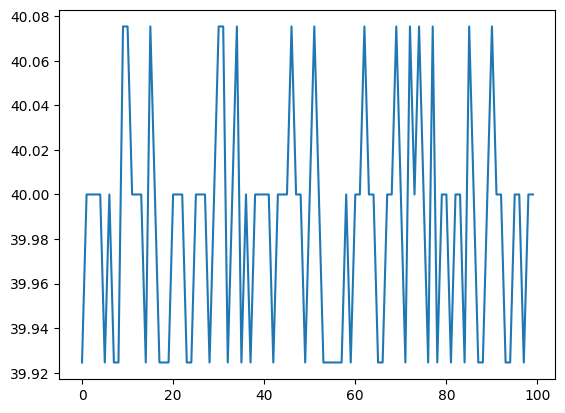

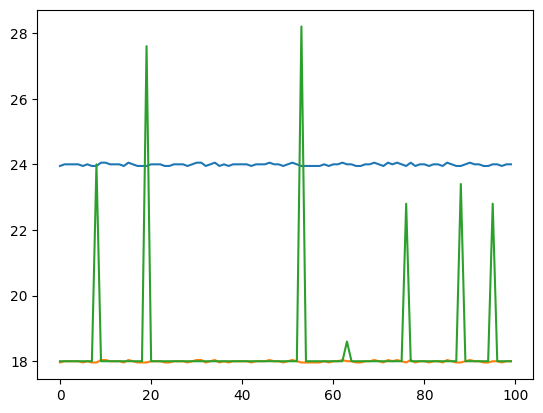

In [76]:
import matplotlib.pyplot as plt
k = 100
plt.plot(u_history[-k:])
plt.show()

plt.plot(qc_history[-k:])
plt.plot(qm_history[-k:])
plt.plot(q1_history[-k:])
plt.show()

### Correlations with shocks

In [72]:
k = 1000
np.corrcoef(u_history[-k:], q1_history[-k:])

array([[ 1.  , -0.08],
       [-0.08,  1.  ]])

### Impulse Response

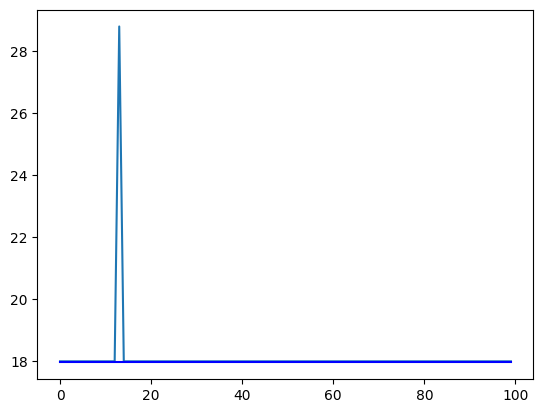

In [90]:
# initialize the state
state1 = int(num_states1/2)
u = 40
uidx = 1
q1_impulse=[]
temperature=0.001
# run Boltzmann Q-learning for a fixed number of episodes
num_episodes = 100
for episode in range(num_episodes):

    if episode in [13]:
        action1 = 24
    else:
        action1 = boltzmann_action_selection(Q1,uidx,temperature)

    quantity1 = action2quantity[action1]

    # rewards
    reward1 = cournot(u,v,w,n).profit(quantity1)

   # generate shock
    #uidx = whichidx(np.random.choice(Z,p=P[uidx]), Z)
    u = 40 + Z[uidx]

    q1_impulse.append(quantity1)
    
import matplotlib.pyplot as plt
plt.plot(q1_impulse)
plt.plot([cournot(u,v,w,n).Qm for i in range(num_episodes)], 'b')
plt.show()

In [74]:
u_history

[39.92462216385556,
 39.92462216385556,
 39.92462216385556,
 39.92462216385556,
 39.92462216385556,
 40.0,
 40.0,
 40.0,
 40.07537783614444,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 39.92462216385556,
 40.0,
 39.84924432771112,
 39.92462216385556,
 40.07537783614444,
 39.92462216385556,
 40.0,
 40.07537783614444,
 40.07537783614444,
 40.15075567228888,
 40.0,
 40.07537783614444,
 40.0,
 40.07537783614444,
 40.07537783614444,
 39.92462216385556,
 39.92462216385556,
 40.0,
 40.07537783614444,
 40.0,
 40.0,
 40.0,
 40.0,
 39.92462216385556,
 40.0,
 40.0,
 40.0,
 39.92462216385556,
 40.07537783614444,
 39.92462216385556,
 40.0,
 40.0,
 40.0,
 40.0,
 40.07537783614444,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 40.0,
 39.92462216385556,
 40.0,
 39.92462216385556,
 40.0,
 40.0,
 40.0,
 39.92462216385556,
 40.0,
 40.07537783614444,
 40.0,
 39.92462216385556,
 40.0,
 40.07537783614444,
 40.0,
 40.07537783614444,
 40.07537783614444,
 40.0,
 39.92462216385556,
 39.92462216385556,
 40.07537783614444,


In [83]:

boltzmann_action_selection(Q1,uidx,temperature)

5